# Exploratory Data Analysis

Before we dive into model building, it is absolutely critical to develop a rich, nuanced understanding of the Adult Income dataset’s structure, quirks, and latent patterns. In this notebook we will:

1. **Characterize the overall sample**  
   - Who are these 48 K+ individuals? What ranges and central tendencies do key attributes exhibit?  
   - How balanced is our target (≤ \$50K vs. > \$50K), and what does that imply for algorithm choice and evaluation?

2. **Probe data quality and integrity**  
   - Where do missing values cluster, and what underlying processes might have generated them?  
   - Which columns carry unexpected data types or anomalous values that demand manual correction?

3. **Uncover univariate distributions**  
   - Examine each numeric feature’s histogram, boxplot, skewness, and outliers to inform potential transformations (e.g. log‐scaling, winsorization).  
   - Survey categorical features’ cardinalities—spot rare levels that should be grouped or dropped, and detect imbalance that could bias our models.

4. **Surface bivariate relationships**  
   - Use density plots, violin plots, and scatterplots to visualize how each predictor interacts with income class.  
   - Compute correlation coefficients among numerical features to flag multicollinearity, and assess whether feature elimination or dimensionality reduction is warranted.

5. **Formulate hypotheses for modeling**  
   - Which features appear most promising as strong discriminators of high‐income status?  
   - Where do simple linear boundaries fail, suggesting a need for non‐linear models or interaction terms?


In [1]:
pip install ucimlrepo #install the ucimlrepo package

In [2]:
# Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

# Fetch & assemble Adult Income data
census = fetch_ucirepo(id=20)
X = census.data.features
y = census.data.targets
data = pd.concat([X, y], axis=1)

# Initial inspection
print("Shape before cleaning:", data.shape)
display(data.head())
display(data.info())

Shape before cleaning: (48842, 15)


age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

## Deep Dive: Data Quality & Missingness

Our first task is to trace the origin and pattern of missing observations. We will:
- Tabulate missing counts by column and by income class  
- Visualize missingness patterns  
- Decide on imputation vs. removal


<ipython-input-3-11907a117e72>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_income = data.groupby('income').apply(lambda df: df.isna().sum())


Missing per column:
 age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Missing by income class:
         age  workclass  fnlwgt  education  education-num  marital-status  \
income                                                                     
<=50K     0          0       0          0              0               0   
<=50K.    0        889       0          0              0               0   
>50K      0          0       0          0              0               0   
>50K.     0         74       0          0              0               0   

        occupation  relationship  race  sex  capital-gain  capital-loss  \
income                                                                    
<=

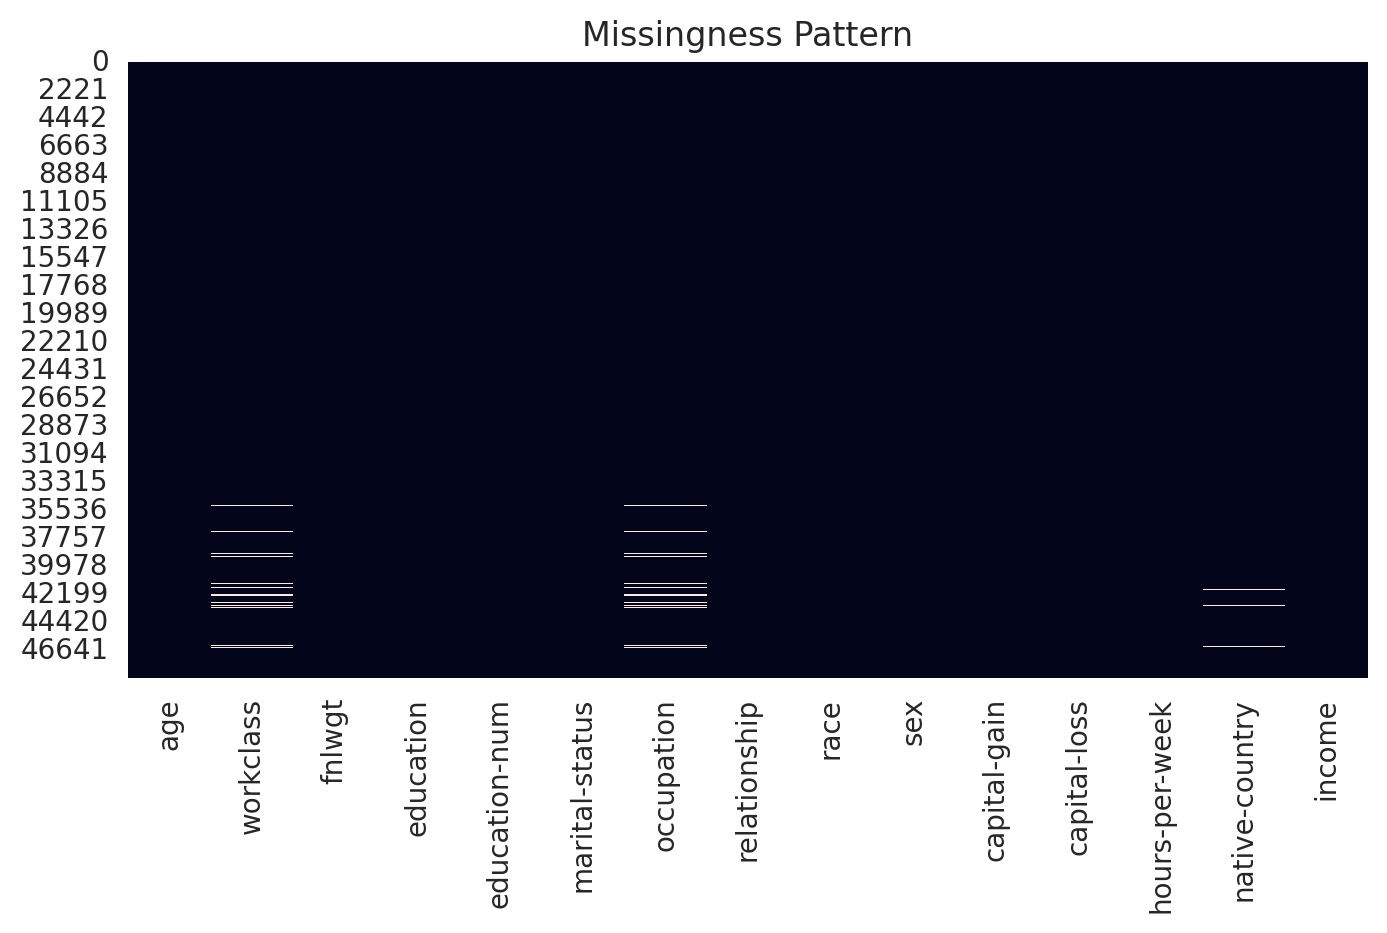

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
Shape after drop: (47621, 15)


In [3]:
# Mark & drop missing
data.replace(' ?', pd.NA, inplace=True)
missing_by_col = data.isna().sum()
missing_by_income = data.groupby('income').apply(lambda df: df.isna().sum())

print("Missing per column:\n", missing_by_col)
print("\nMissing by income class:\n", missing_by_income)

# Visualize missingness
plt.figure(figsize=(8,4))
sns.heatmap(data.isna(), cbar=False)
plt.title("Missingness Pattern")
plt.show()

#drop rows with missing values
data.dropna(inplace=True)

#verify no missing values remain
print(data.isnull().sum())

print("Shape after drop:", data.shape)

## Deep Dive: Univariate Statistics & Outlier Treatment

### Numerical Variables

For each numeric attribute (`age`, `education-num`, `hours-per-week`, `capital-gain`, `capital-loss`):
- Compute mean, median, skewness, kurtosis  
- Plot histogram + KDE and boxplot  
- Decide on transformations (e.g. `np.log1p`)


mean  median   skew  kurtosis  min    max
feature                                                     
age               38.64    37.0   0.55     -0.17   17     90
education-num     10.09    10.0  -0.31      0.62    1     16
hours-per-week    40.60    40.0   0.27      3.02    1     99
capital-gain    1091.14     0.0  11.83    151.06    0  99999
capital-loss      87.85     0.0   4.56     19.96    0   4356

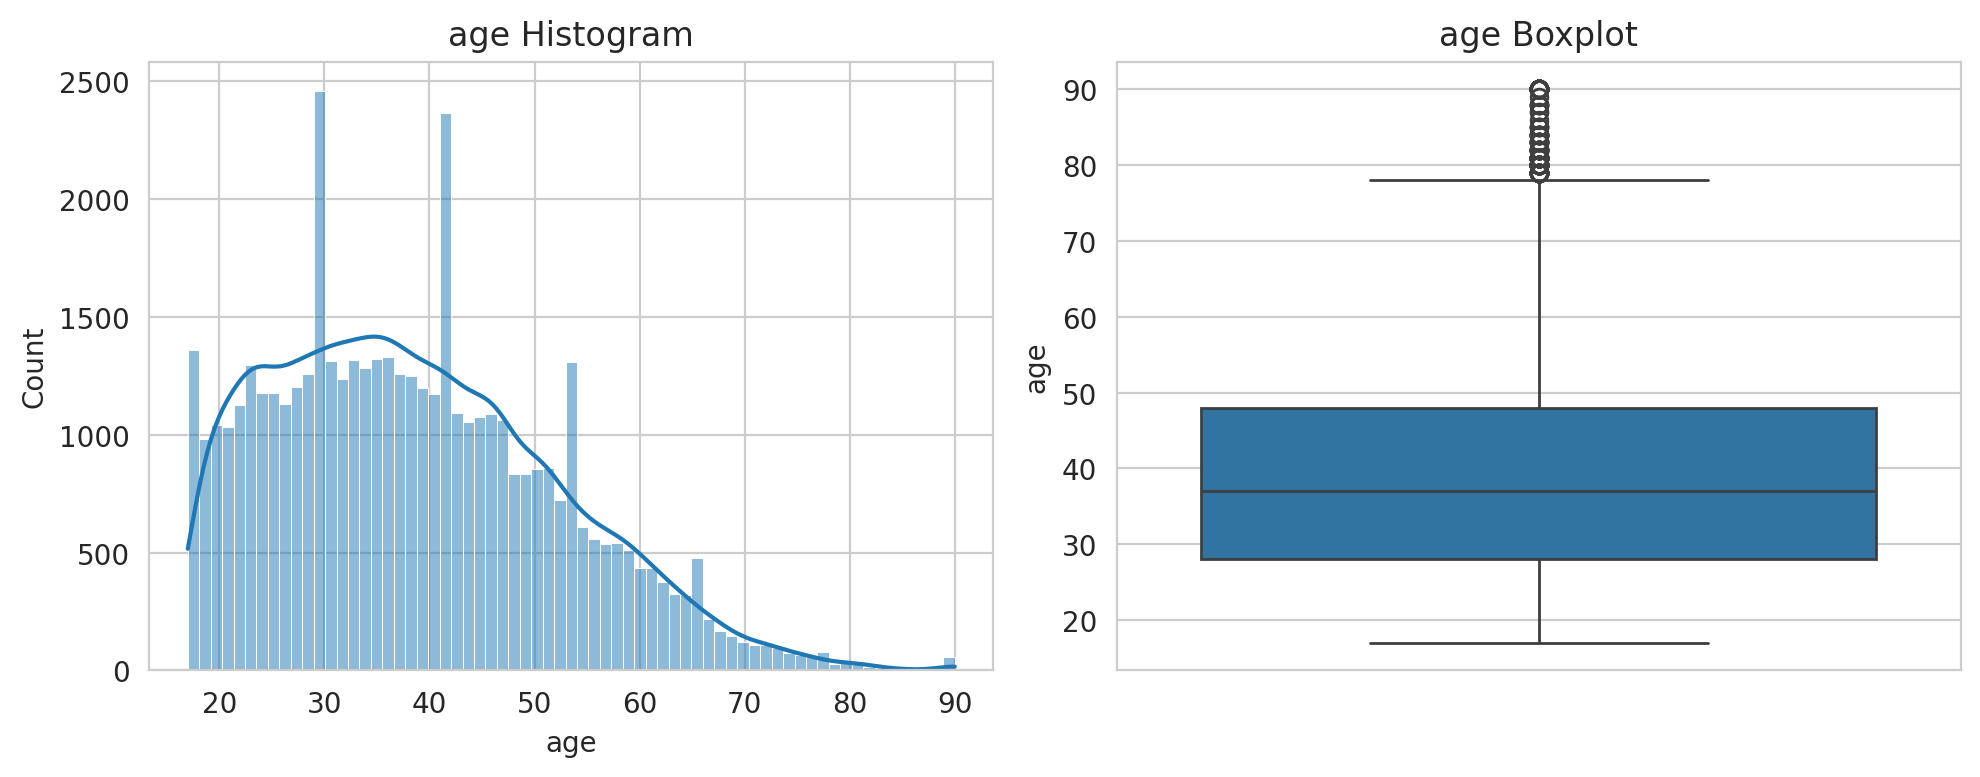

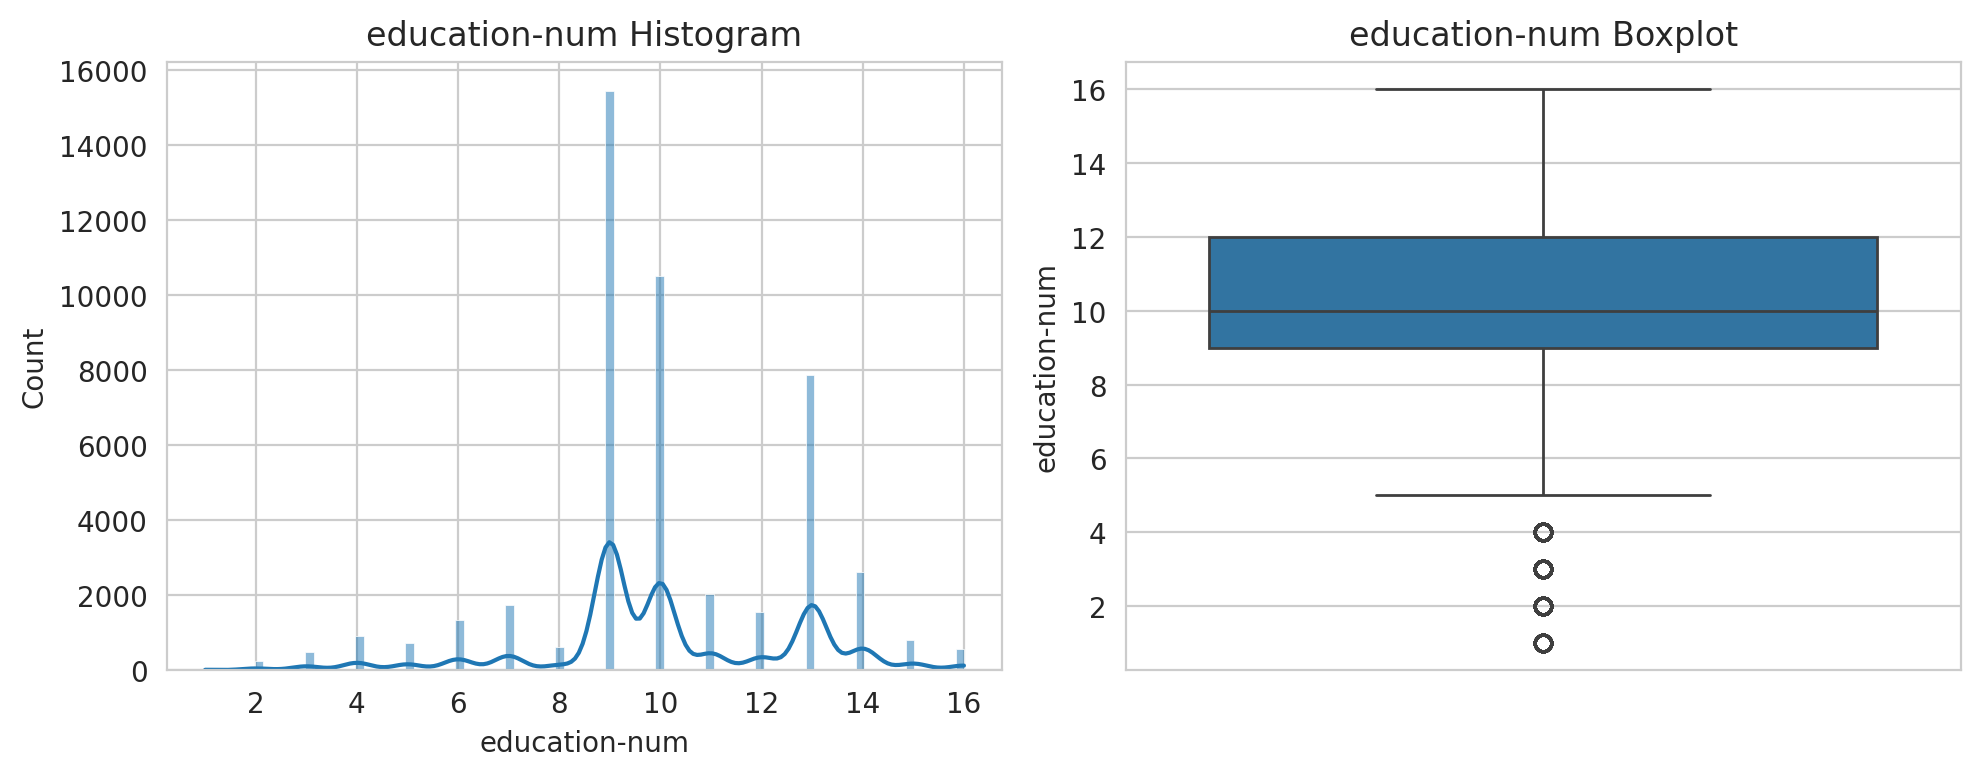

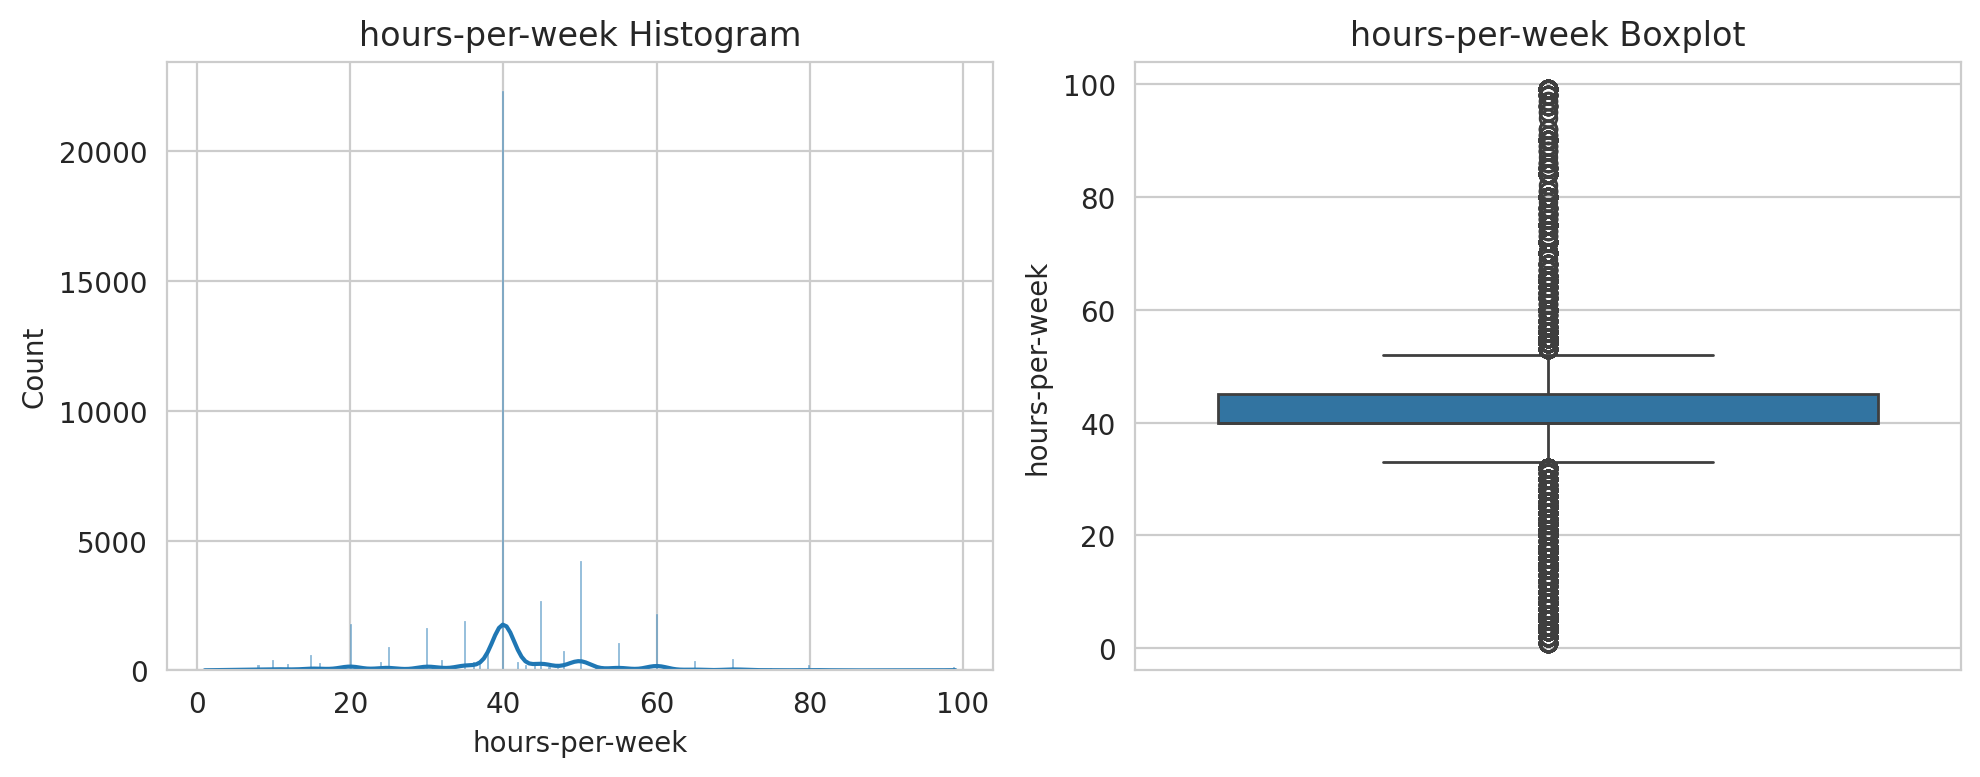

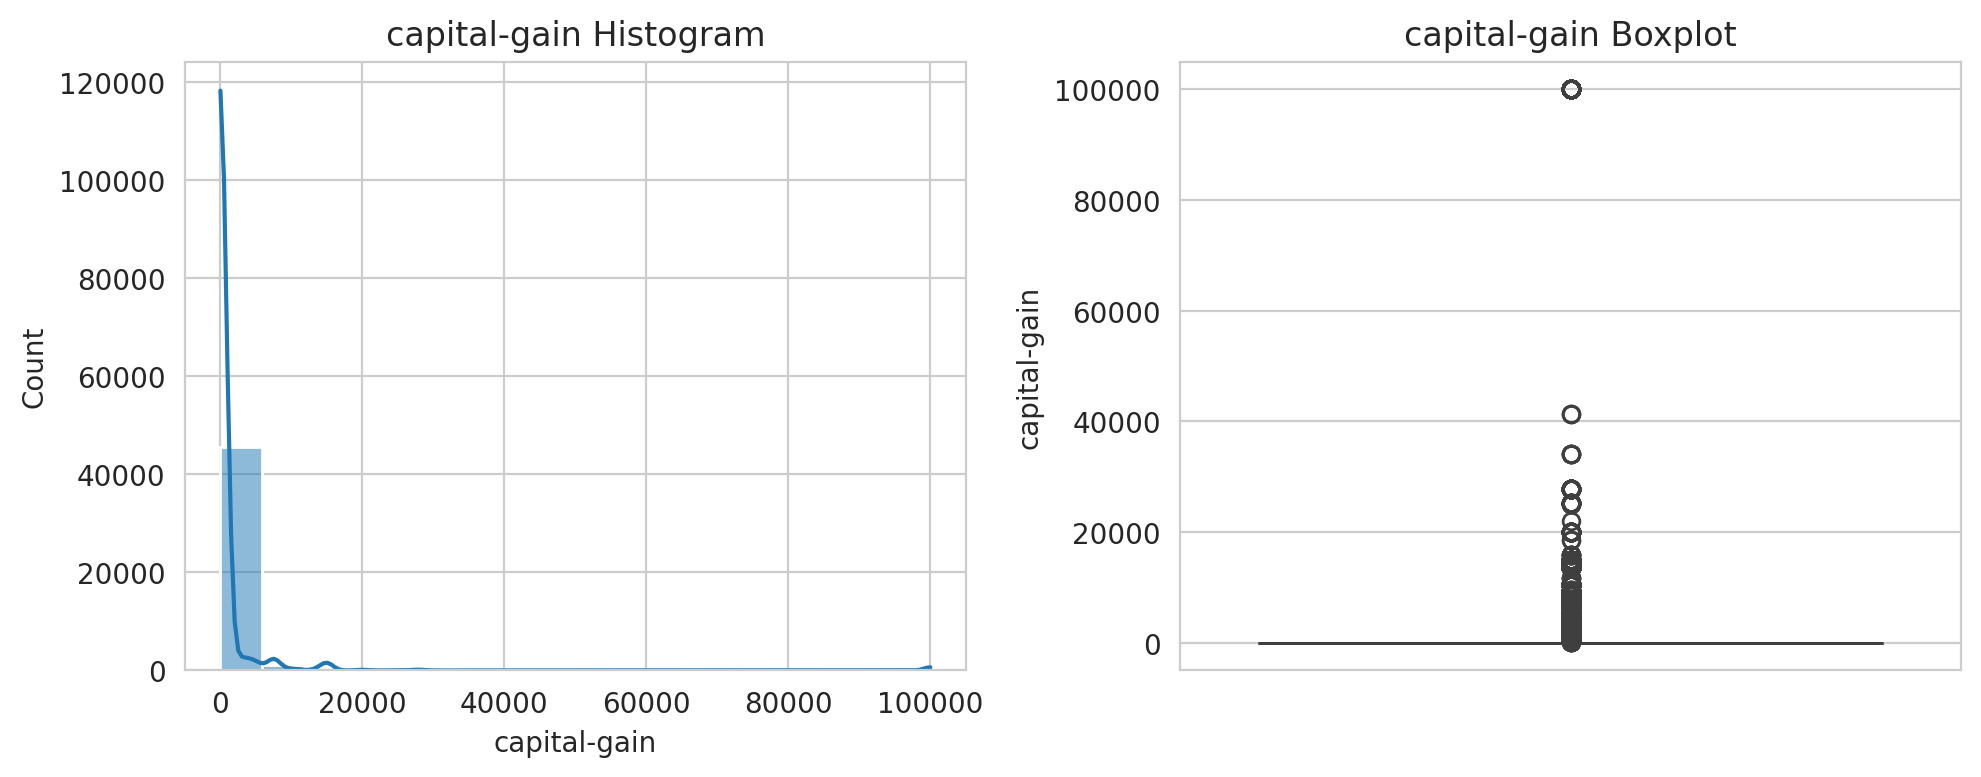

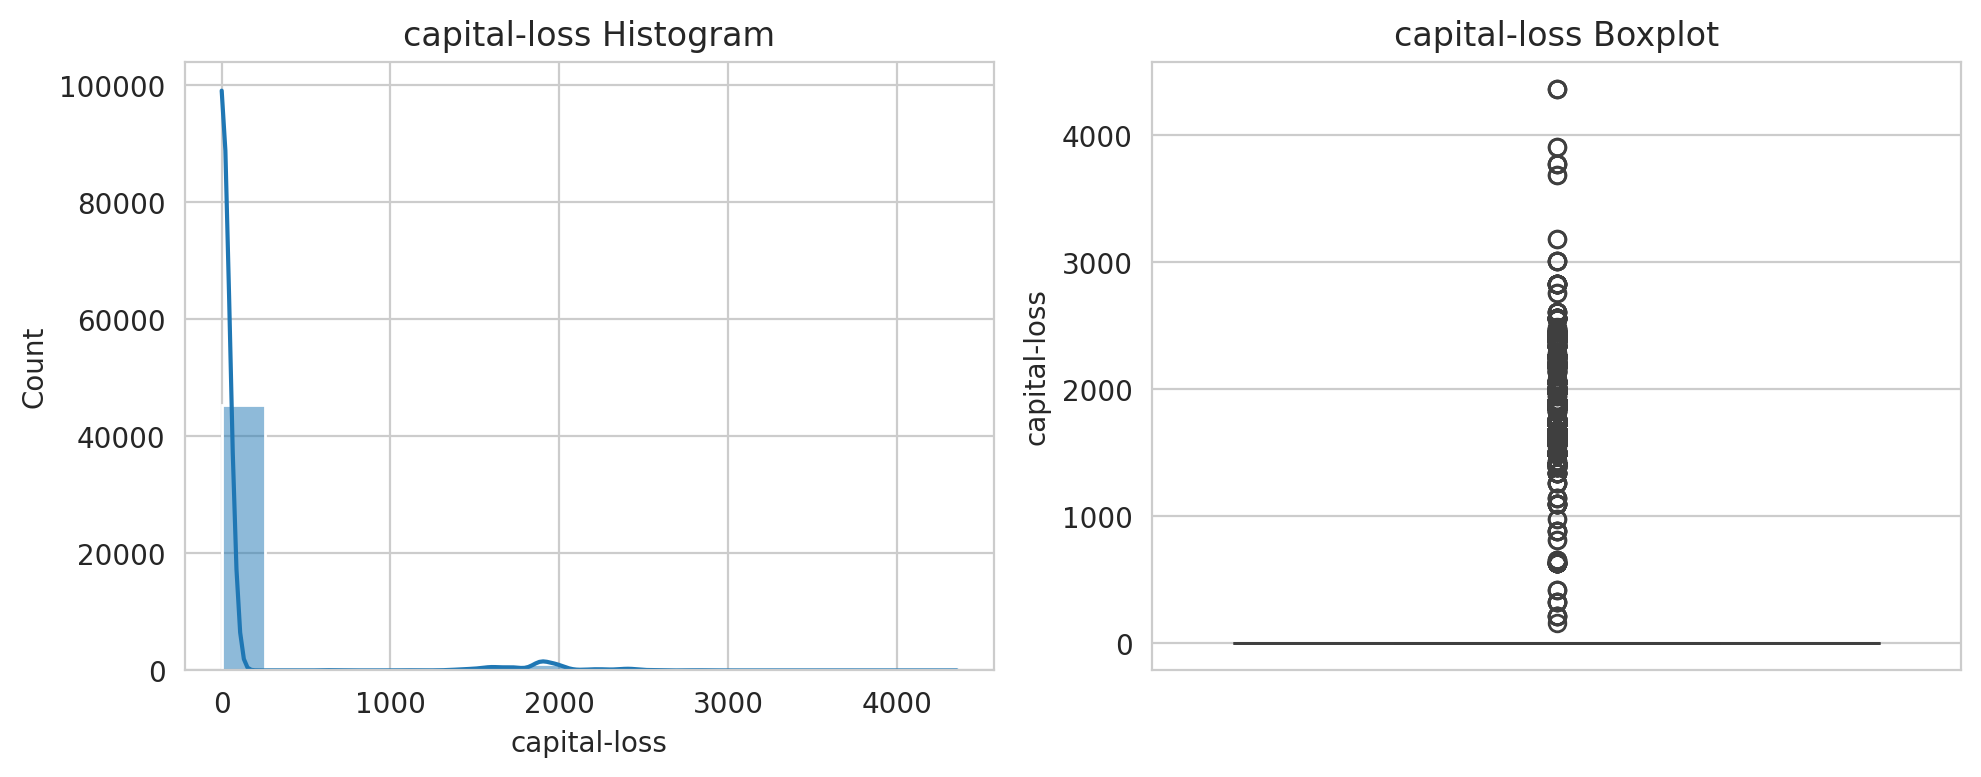

In [4]:
num_feats = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
stats = []
for col in num_feats:
    series = data[col]
    stats.append({
        "feature": col,
        "mean": series.mean().round(2),
        "median": series.median(),
        "skew": series.skew().round(2),
        "kurtosis": series.kurtosis().round(2),
        "min": series.min(),
        "max": series.max()
    })
display(pd.DataFrame(stats).set_index("feature"))

for col in num_feats:
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    sns.histplot(data[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Histogram")
    sns.boxplot(y=data[col], ax=axes[1])
    axes[1].set_title(f"{col} Boxplot")
    plt.tight_layout()
    plt.show()


In [5]:
#drop less relevant columns (e.g., 'fnlwgt' is a sample weight)
data.drop('fnlwgt', axis=1, inplace=True)

In [6]:
#remove trailing periods and strip whitespace from all string columns in the DataFrame
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.strip().str.rstrip('.')

#verify cleaning
print(data.head())
print(data['income'].unique())  #should output ['<=50K', '>50K']

   age         workclass  education  education-num      marital-status  \
0   39         State-gov  Bachelors             13       Never-married   
1   50  Self-emp-not-inc  Bachelors             13  Married-civ-spouse   
2   38           Private    HS-grad              9            Divorced   
3   53           Private       11th              7  Married-civ-spouse   
4   28           Private  Bachelors             13  Married-civ-spouse   

          occupation   relationship   race     sex  capital-gain  \
0       Adm-clerical  Not-in-family  White    Male          2174   
1    Exec-managerial        Husband  White    Male             0   
2  Handlers-cleaners  Not-in-family  White    Male             0   
3  Handlers-cleaners        Husband  Black    Male             0   
4     Prof-specialty           Wife  Black  Female             0   

   capital-loss  hours-per-week native-country income  
0             0              40  United-States  <=50K  
1             0              13  U

In [7]:
#convert income categories to numerical values (0/1)
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

### Categorical Variables

For each categorical feature:
- Frequency table & proportion  
- P(income=1 | level)  
- Bar chart sorted by high‑income share


### workclass


pct  high_income_rate
workclass                                   
Self-emp-inc      0.035447         55.331754
Federal-gov       0.029882         39.002108
Local-gov         0.065643         29.526552
Self-emp-not-inc  0.080595         27.853048
State-gov         0.041263         26.921120
Private           0.708028         21.763502
?                 0.038554         10.403050
Without-pay       0.000441          9.523810
Never-worked      0.000147          0.000000

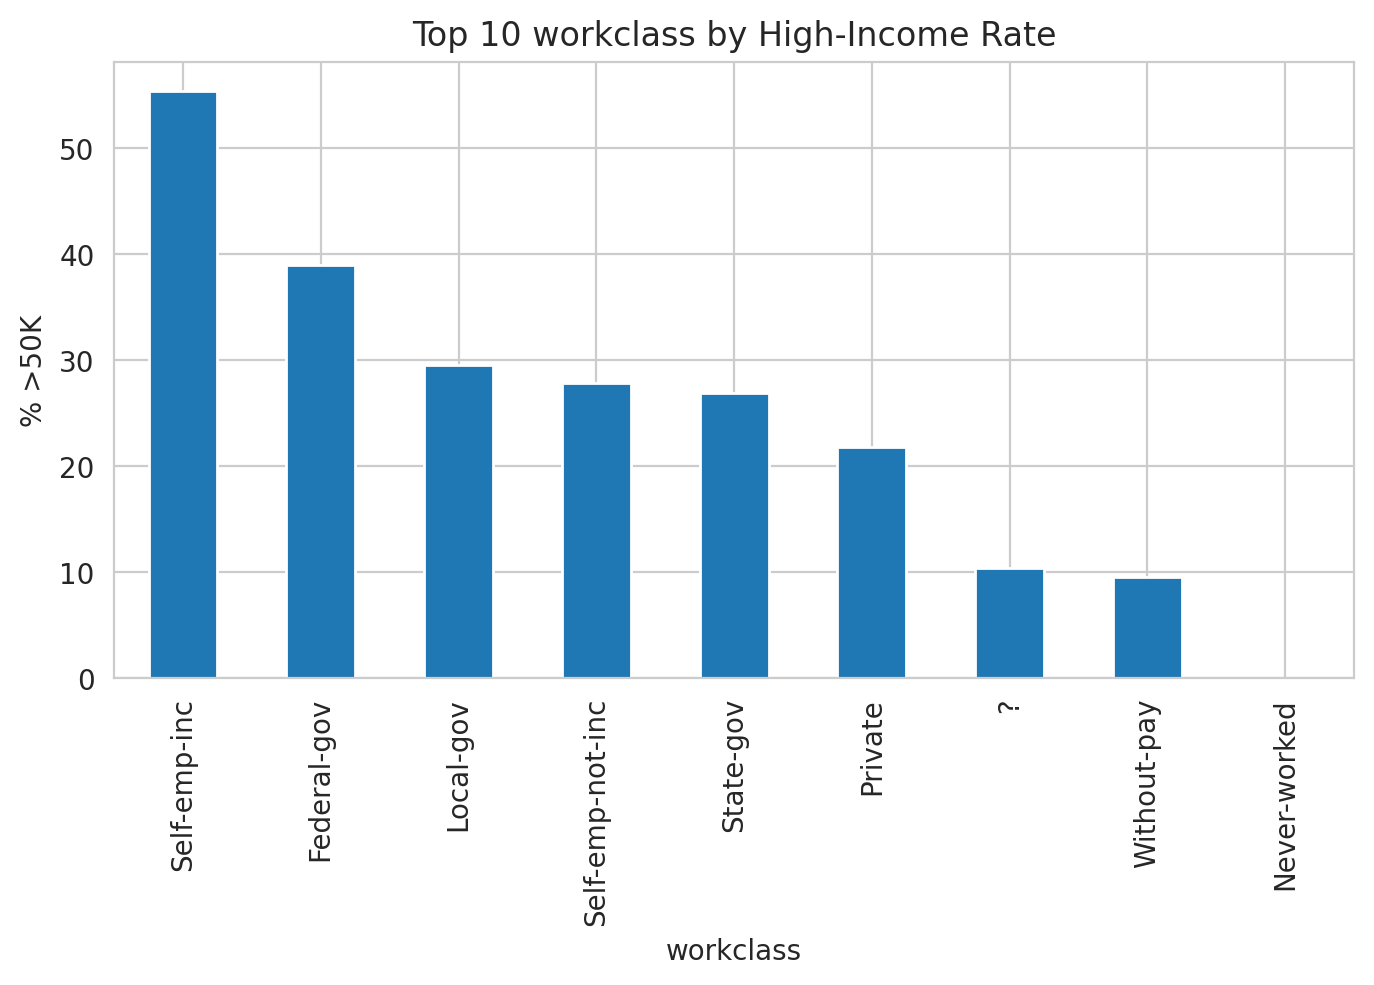

### education


pct  high_income_rate
education                               
Prof-school   0.017198         74.358974
Doctorate     0.012221         73.024055
Masters       0.054808         54.942529
Bachelors     0.165494         41.530263
Assoc-acdm    0.032885         25.989783
Assoc-voc     0.042712         25.614553
Some-college  0.220743         19.415906
HS-grad       0.324311         16.019166
12th          0.013292          7.424961
7th-8th       0.019151          6.578947

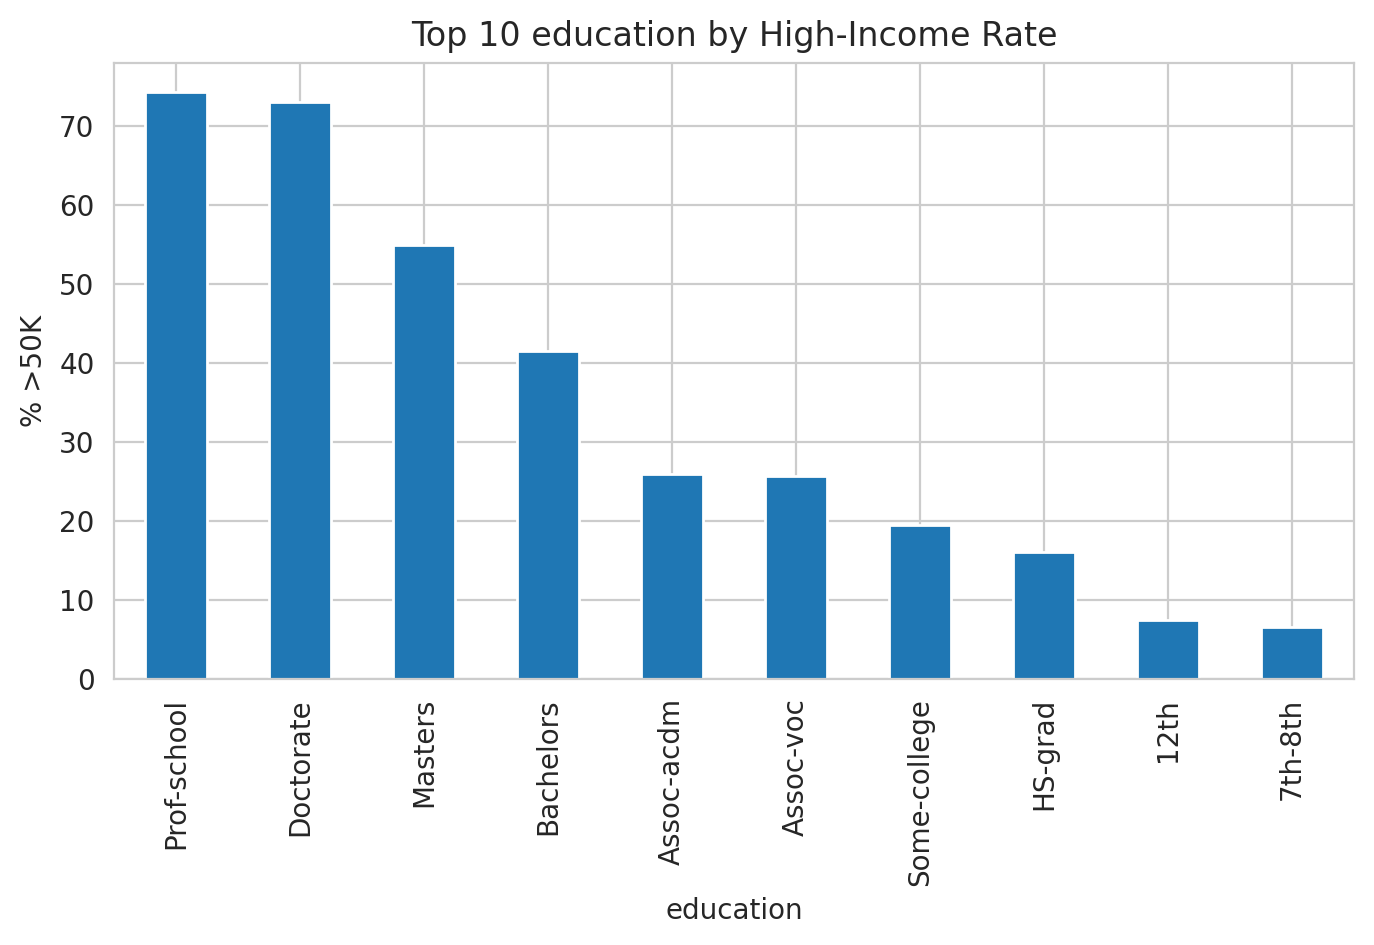

### marital-status


pct  high_income_rate
marital-status                                   
Married-civ-spouse     0.461267         44.873896
Married-AF-spouse      0.000714         41.176471
Divorced               0.137040         10.205333
Married-spouse-absent  0.012599          9.500000
Widowed                0.030302          8.731809
Separated              0.031436          6.613226
Never-married          0.326642          4.641594

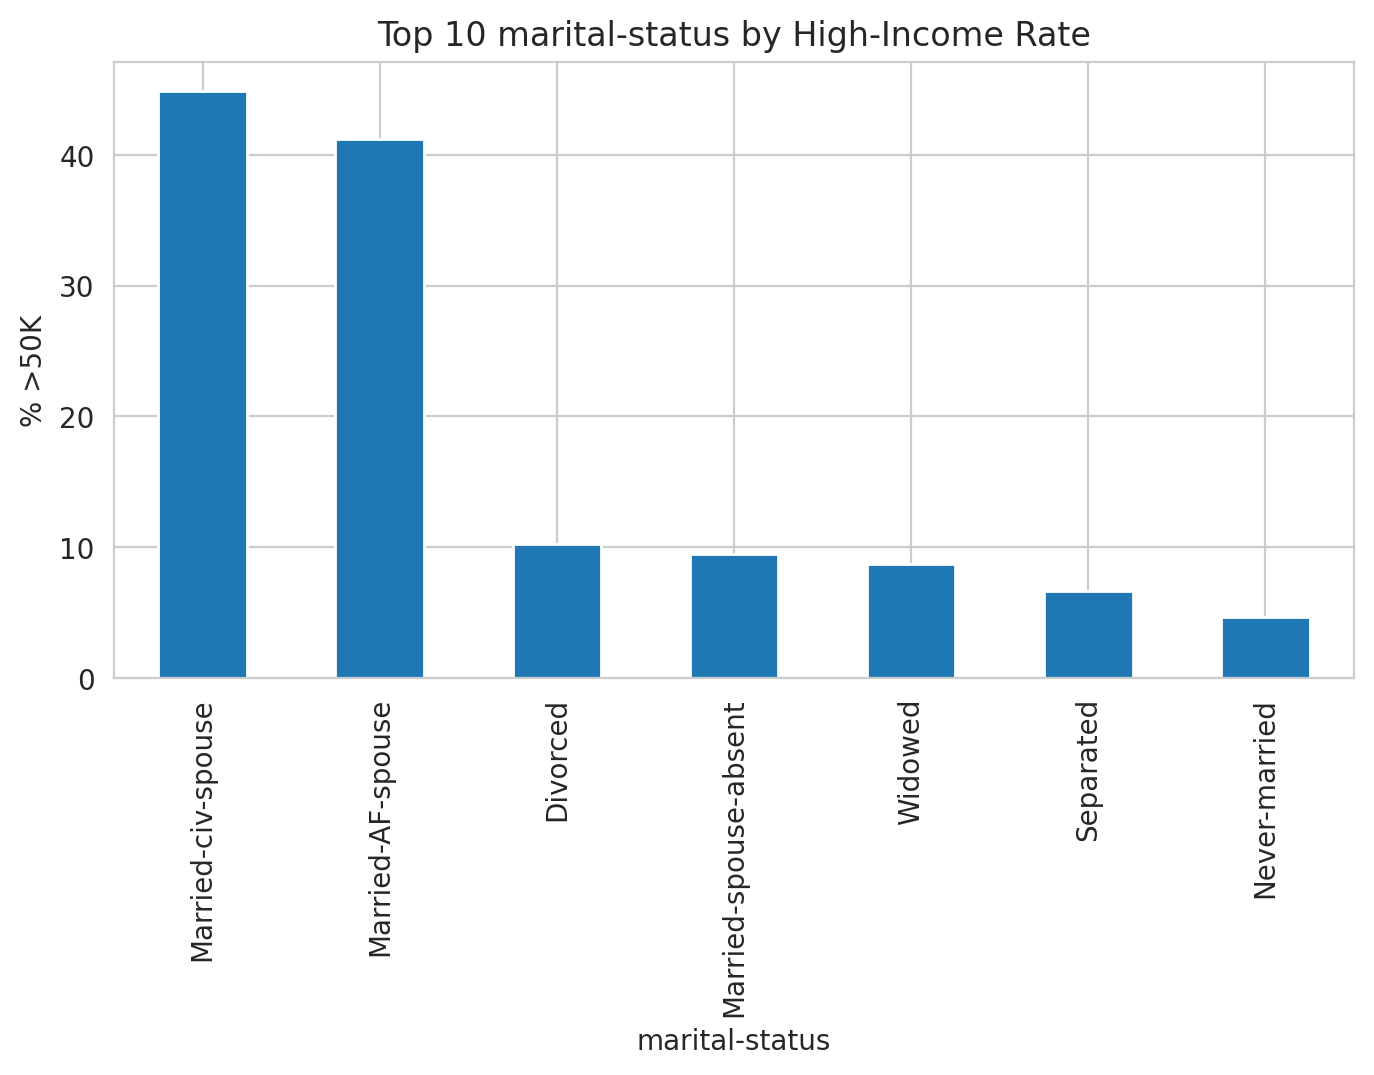

### occupation


pct  high_income_rate
occupation                                   
Exec-managerial    0.127213         47.837570
Prof-specialty     0.128305         45.040917
Protective-serv    0.020600         31.396534
Tech-support       0.030155         28.969359
Armed-Forces       0.000294         28.571429
Sales              0.114949         26.817684
Craft-repair       0.127864         22.598128
Transport-moving   0.049159         20.461341
Adm-clerical       0.117364         13.687601
Machine-op-inspct  0.063123         12.308716

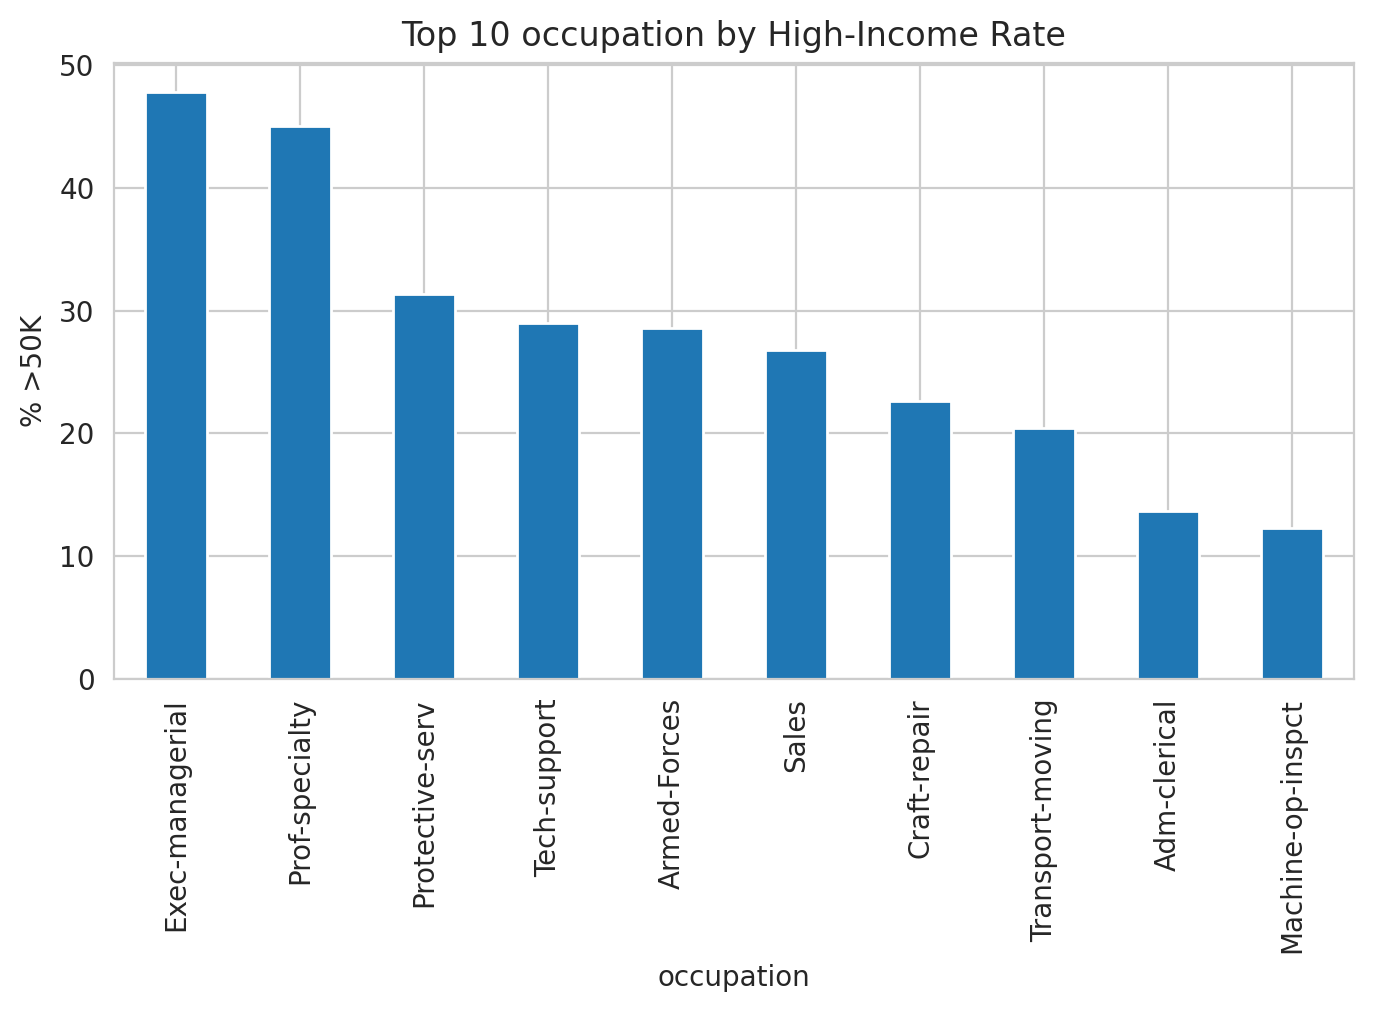

### relationship


pct  high_income_rate
relationship                              
Wife            0.047311         47.359077
Husband         0.407299         45.091771
Not-in-family   0.257890         10.267893
Unmarried       0.105458          6.113102
Other-relative  0.030260          3.608605
Own-child       0.151782          1.494189

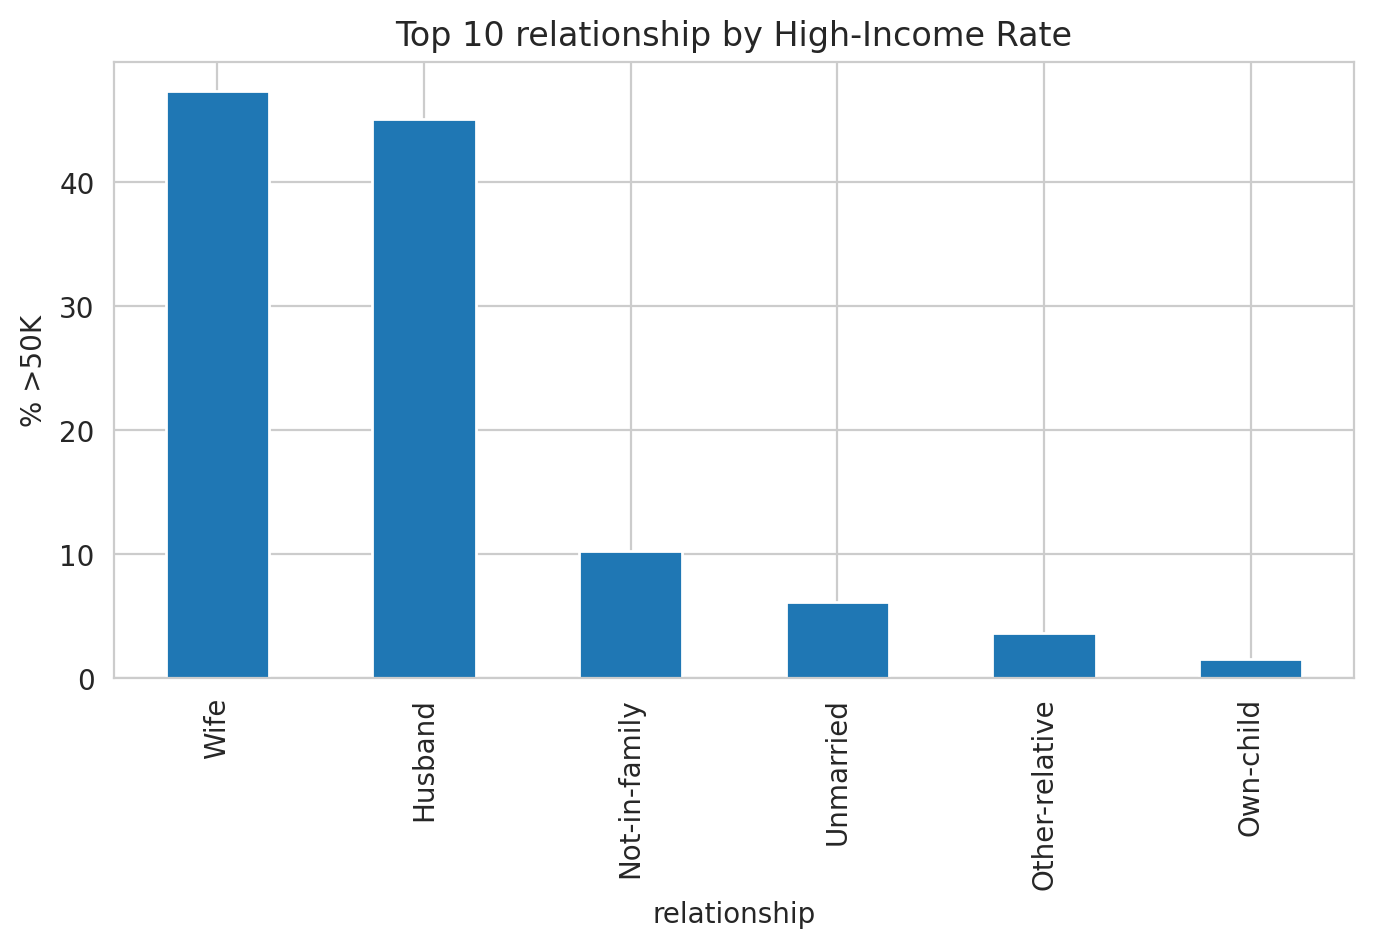

### race


pct  high_income_rate
race                                          
Asian-Pac-Islander  0.030386         27.436075
White               0.856471         25.707351
Other               0.008253         12.468193
Black               0.095231         12.238148
Amer-Indian-Eskimo  0.009660         11.956522

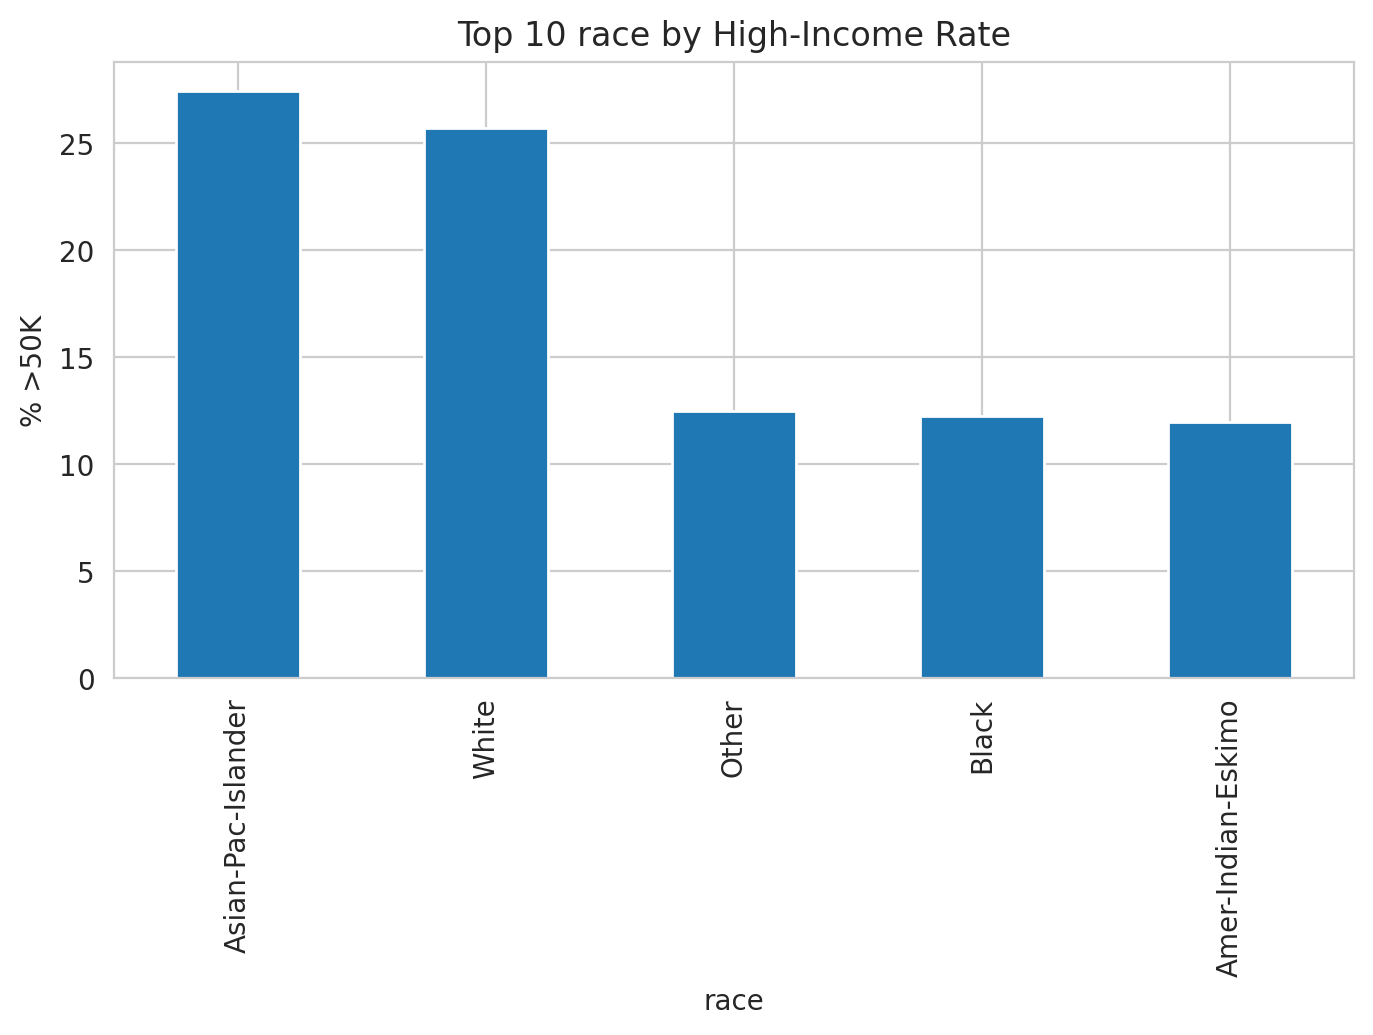

### sex


pct  high_income_rate
sex                              
Male    0.67065         30.701068
Female  0.32935         11.068605

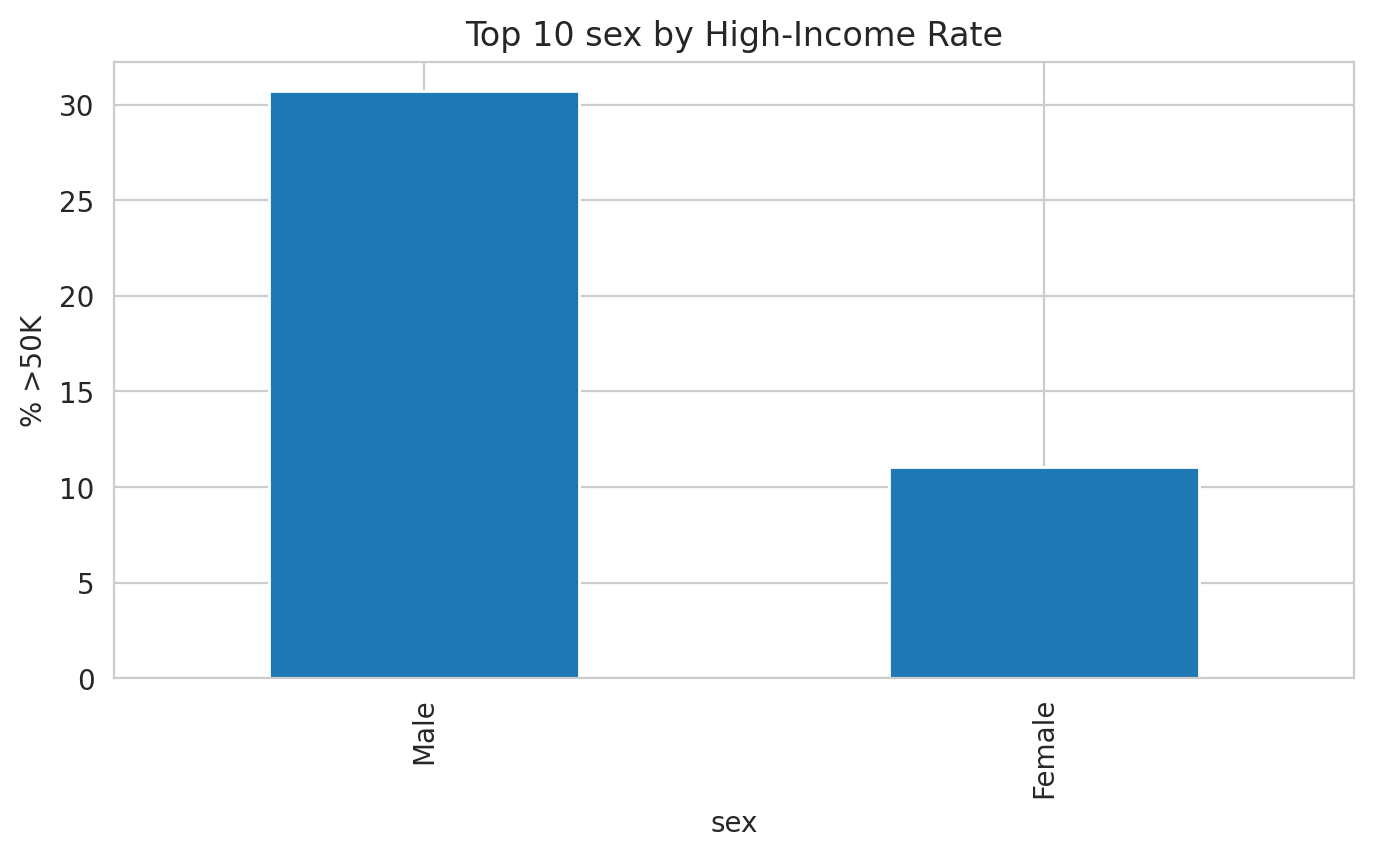

### native-country


pct  high_income_rate
native-country                            
India           0.003087         42.176871
France          0.000798         42.105263
Taiwan          0.001344         40.625000
Iran            0.001197         38.596491
England         0.002583         38.211382
Greece          0.001029         36.734694
Canada          0.003717         35.593220
Japan           0.001932         34.782609
Yugoslavia      0.000483         34.782609
Cambodia        0.000567         33.333333

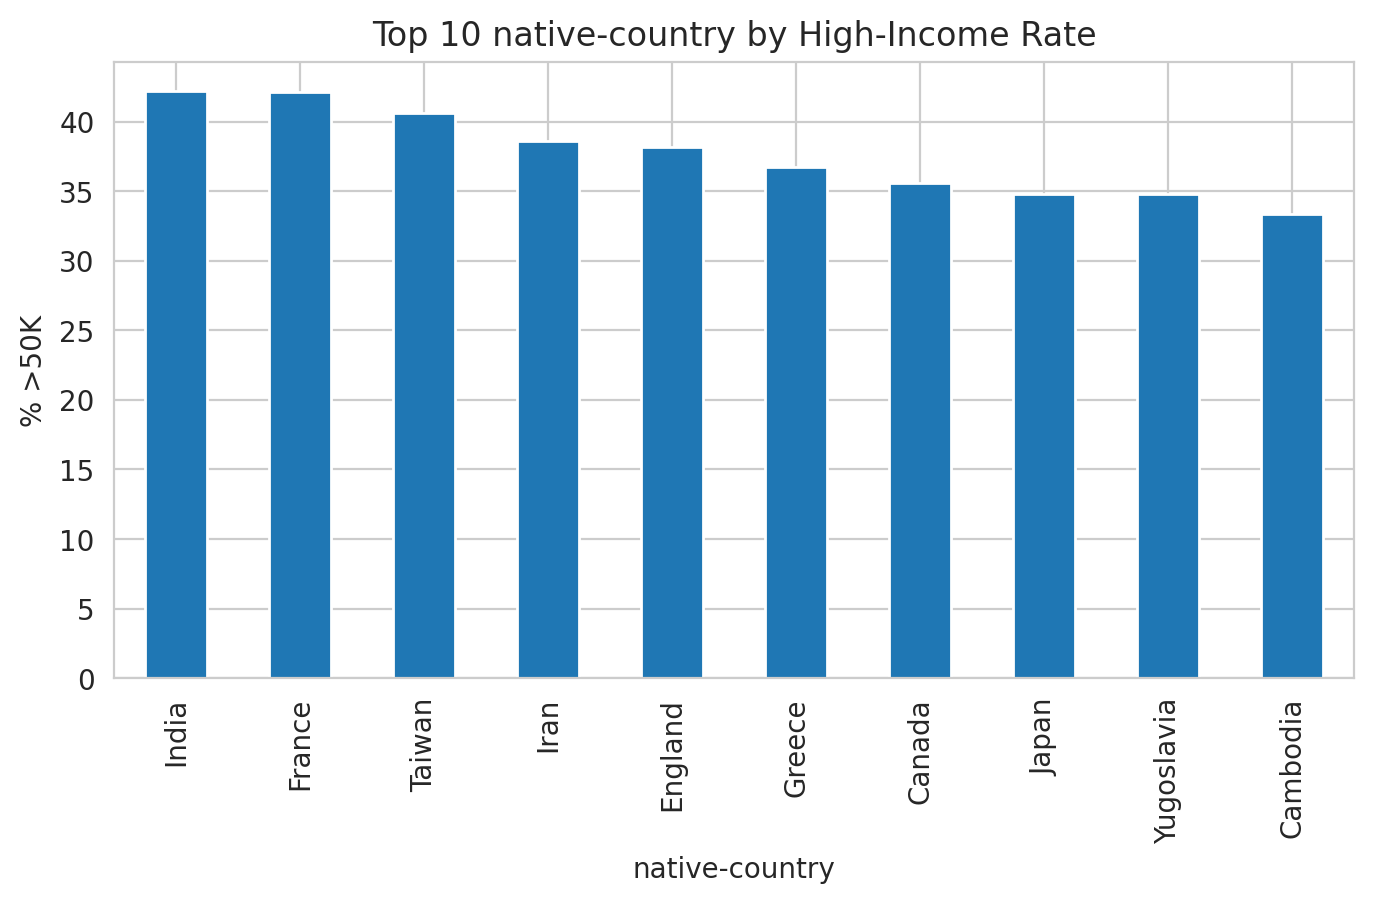

In [8]:
cat_feats = [c for c in data.columns if c not in num_feats + ["income"]]

for col in cat_feats:
    freq = data[col].value_counts(normalize=True).rename("pct")
    cond = data.groupby(col)["income"].mean().rename("high_income_rate") * 100
    df_cat = pd.concat([freq, cond], axis=1).sort_values("high_income_rate", ascending=False)
    print(f"### {col}")
    display(df_cat.head(10))

    plt.figure(figsize=(8,4))
    df_cat["high_income_rate"].head(10).plot.bar()
    plt.ylabel("% >50K")
    plt.title(f"Top 10 {col} by High‑Income Rate")
    plt.show()


**1. Key Demographic Factors Influencing Income**

**Key Questions:**
1. Do men and women in higher income classes exhibit different age distributions?
2. Which occupations are most common for individuals with advanced degrees (e.g., Masters, PhD) earning >$50K?
3. Does the age distribution of high earners vary significantly across education levels (e.g., HS grads vs. PhDs)?
4. At what age do individuals with Bachelor’s degrees typically transition into higher income brackets?


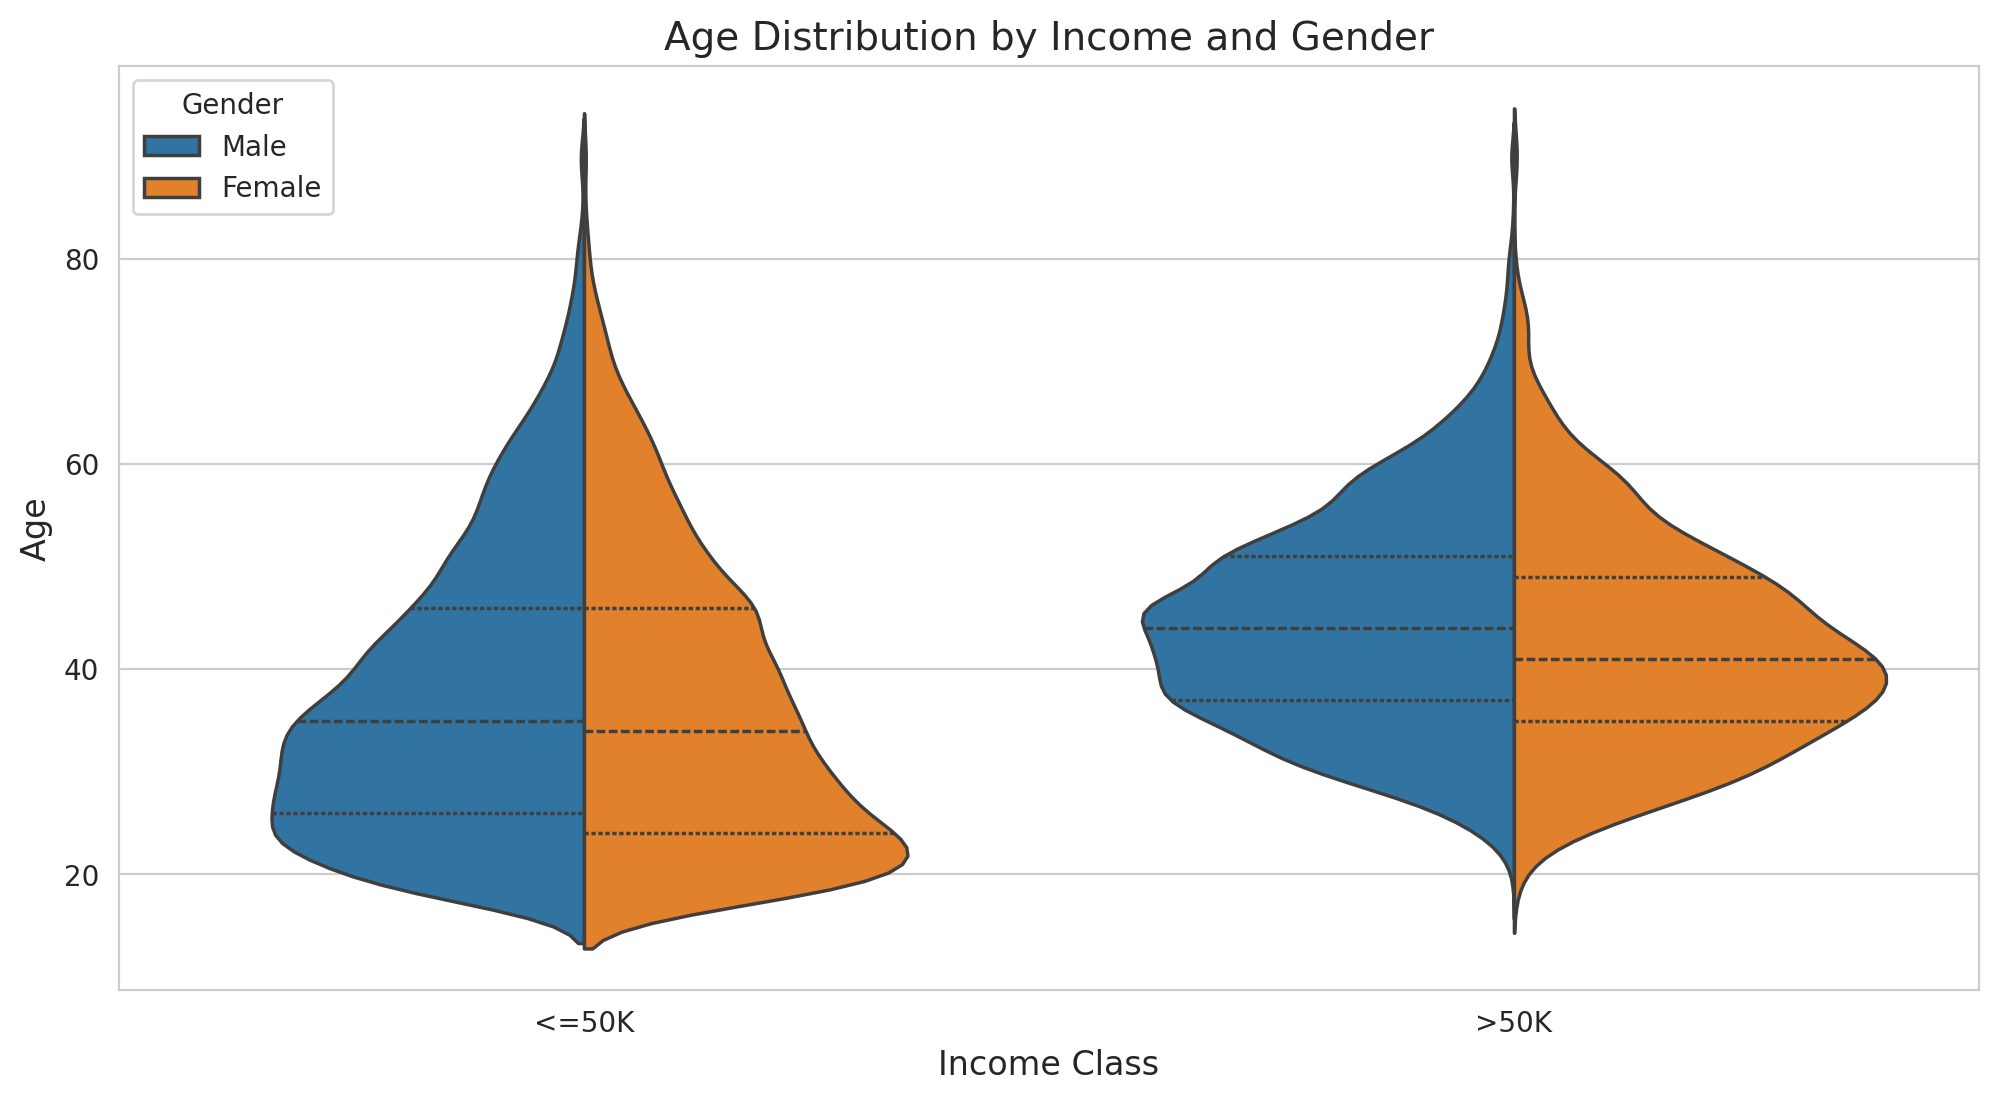

          count       mean        std   min   25%   50%   75%   max
income                                                             
0       36080.0  36.861696  13.938476  17.0  26.0  34.0  46.0  90.0
1       11541.0  44.202236  10.507454  19.0  36.0  43.0  51.0  90.0


In [9]:
#create split violin plot by gender
plt.figure(figsize=(12, 6))
sns.violinplot(data=data, x='income', y='age', hue='sex', split=True, inner='quartile')
plt.title('Age Distribution by Income and Gender', fontsize=14)
plt.xlabel('Income Class', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.legend(title='Gender', loc='upper left')
plt.show()

print(data.groupby('income')['age'].describe()) #show statistical summary of age grouped by income

The split-violin chart comparing age distributions across income classes and gender shows that individuals earning more than 50K are, on average, nearly a decade older than those in the lower-income group: their median age hovers in the mid-forties, whereas the lower-income median sits in the mid-thirties. The shapes of the male and female half-violins overlap almost perfectly within each income bracket, indicating that gender itself does not meaningfully alter the age profile once income level is fixed. Instead, experience—proxied by age—emerges as the decisive factor, and the scarcity of very young or very old high-earners highlights how difficult it is to cross the $50 K threshold at the start or end of one’s career.

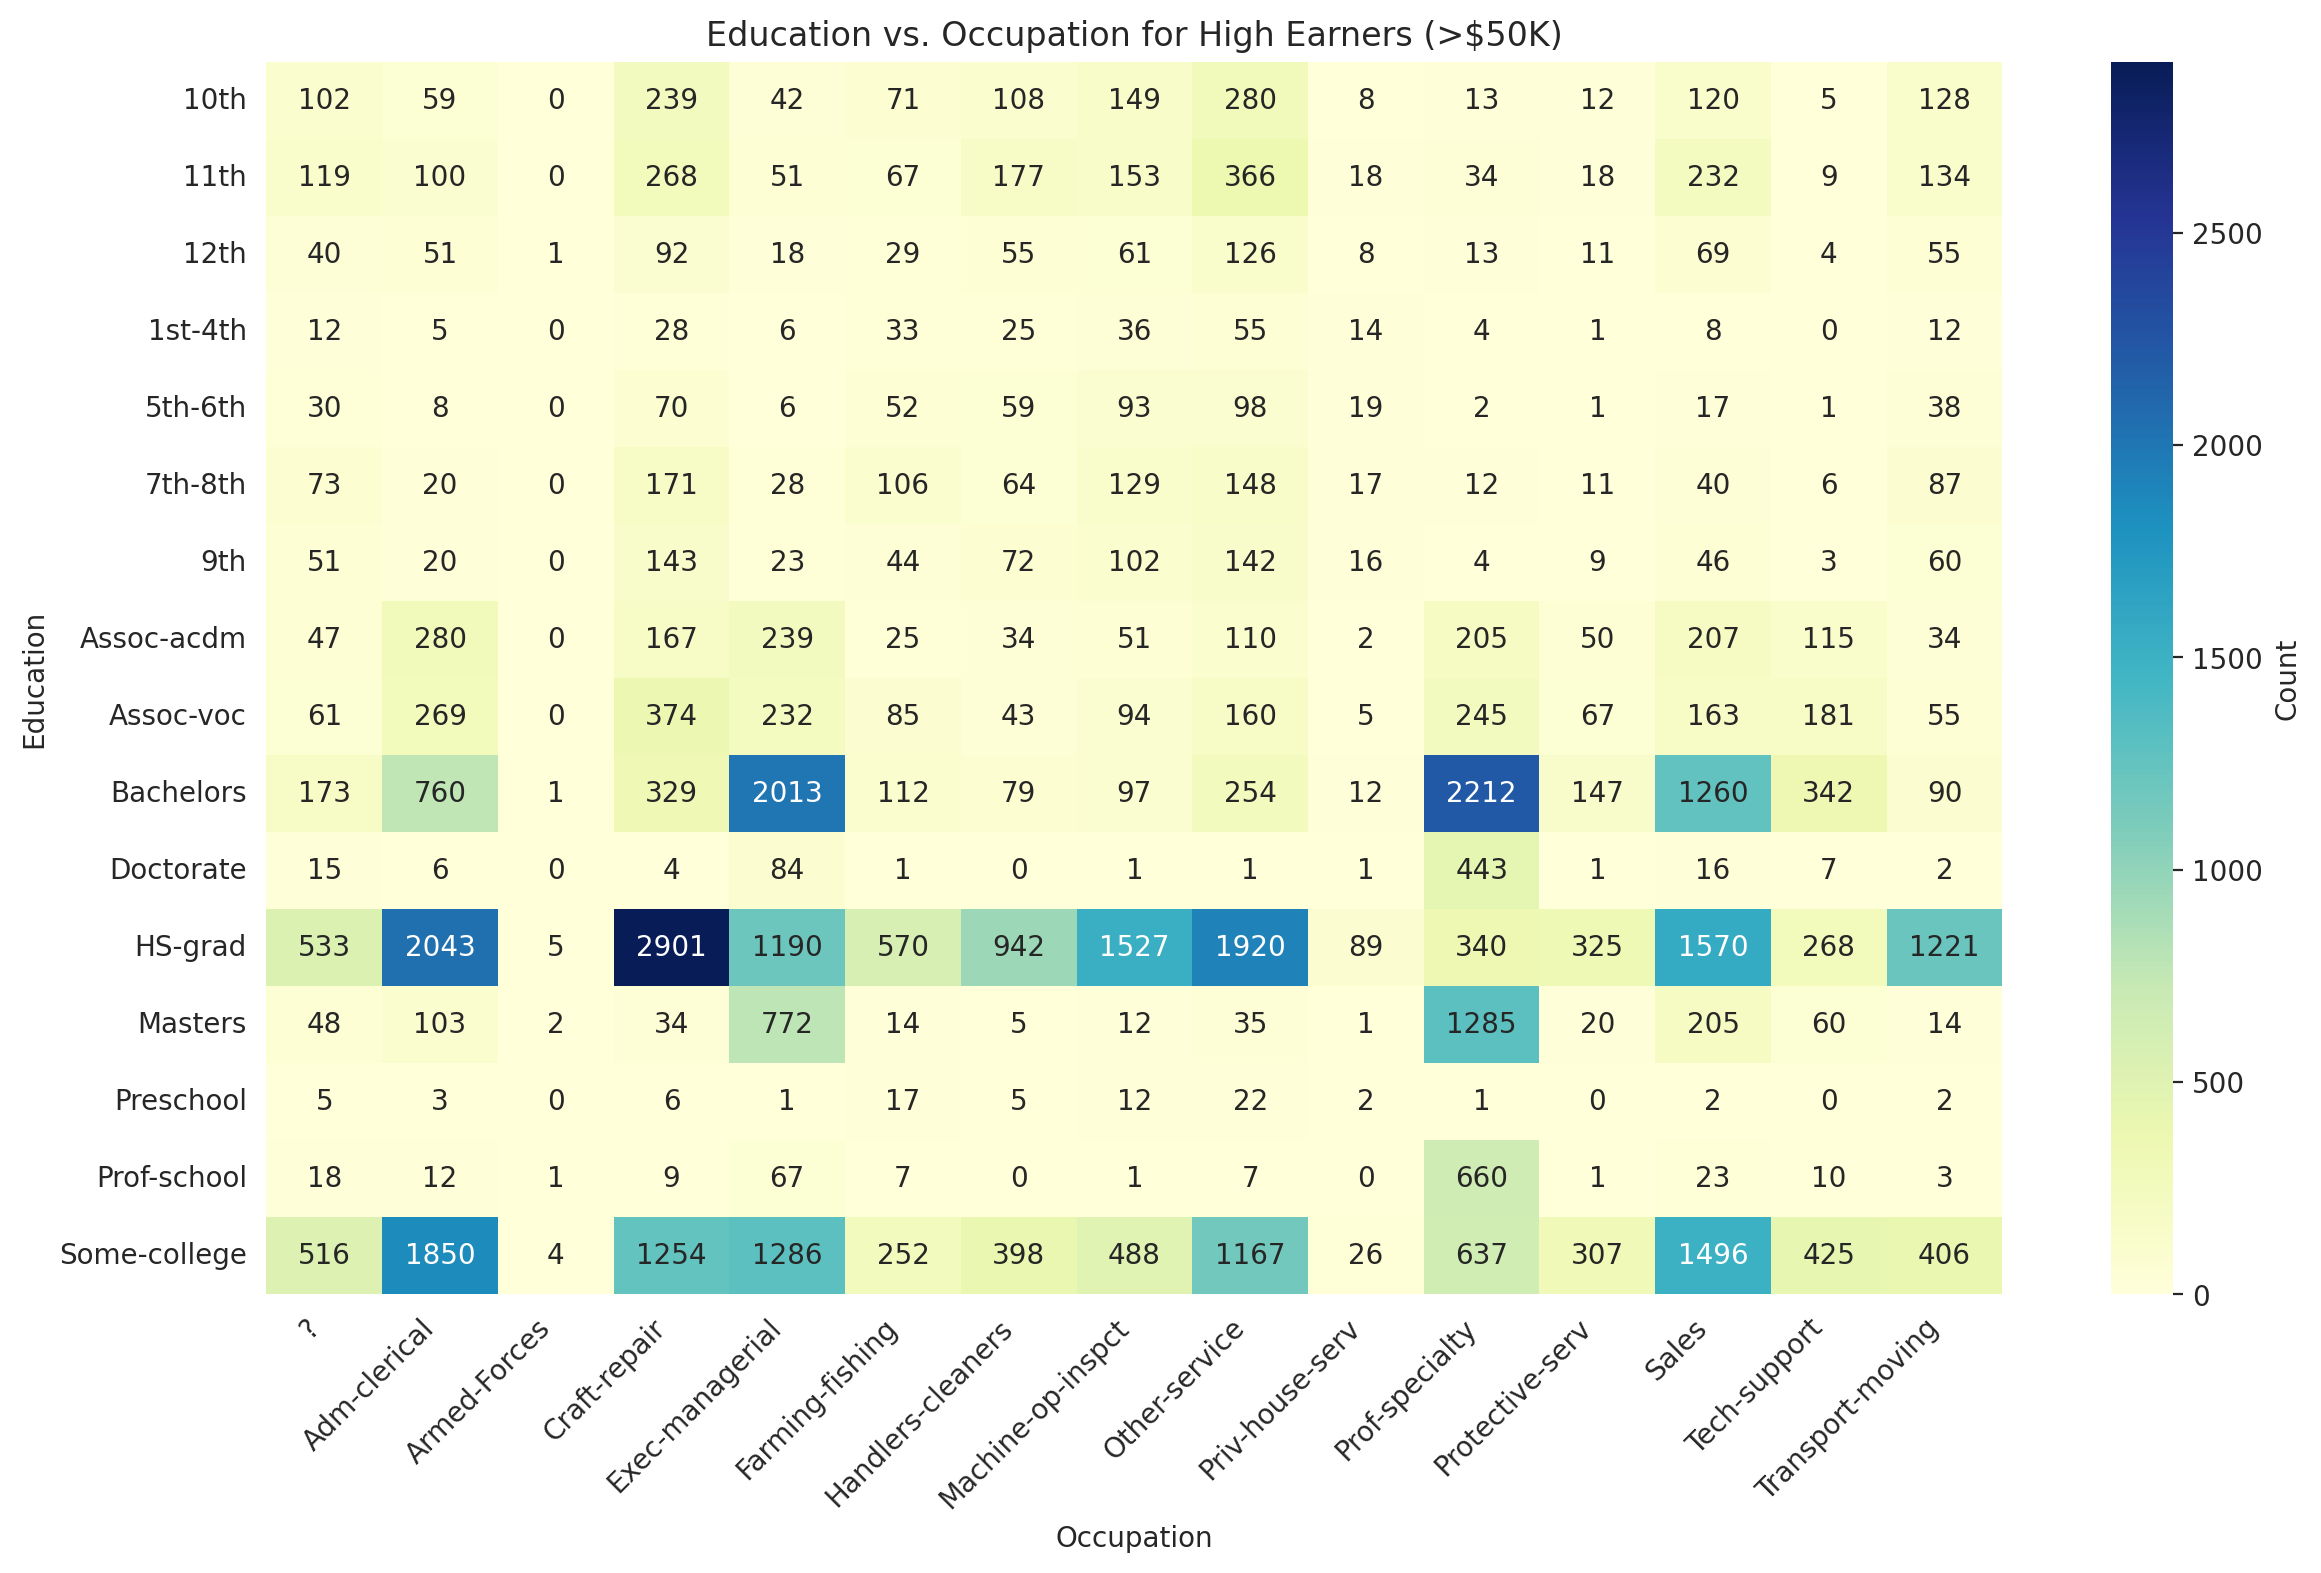

              count unique             top  freq
education                                       
10th           1336     14   Other-service   280
11th           1746     14   Other-service   366
12th            633     15   Other-service   126
1st-4th         239     13   Other-service    55
5th-6th         494     14   Other-service    98
7th-8th         912     14    Craft-repair   171
9th             735     14    Craft-repair   143
Assoc-acdm     1566     14    Adm-clerical   280
Assoc-voc      2034     14    Craft-repair   374
Bachelors      7881     15  Prof-specialty  2212
Doctorate       582     13  Prof-specialty   443
HS-grad       15444     15    Craft-repair  2901
Masters        2610     15  Prof-specialty  1285
Preschool        78     12   Other-service    22
Prof-school     819     13  Prof-specialty   660
Some-college  10512     15    Adm-clerical  1850


In [10]:
#create a cross-tabulation of education and occupation
cross_tab = pd.crosstab(data['education'], data['occupation'])

#plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap( #create education-occupation heatmap for high earners
    cross_tab,
    annot=True,
    fmt='d',  #display counts as integers
    cmap='YlGnBu',
    cbar_kws={'label': 'Count'}
)
plt.title('Education vs. Occupation for High Earners (>$50K)')
plt.xlabel('Occupation')
plt.ylabel('Education')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

print(data.groupby('education')['occupation'].describe()) #show occupation statistics by education

The education-by-occupation heatmap reveals a striking funnel: higher degrees concentrate workers into a narrow band of professional roles. Doctorates and professional-school graduates cluster overwhelmingly in “Prof-specialty,” while high-school graduates disperse across craft, clerical, and service jobs. This pattern suggests that education does not merely raise pay directly; it channels individuals into occupations that structurally command higher wages. Sparse cells at exotic education–occupation pairings—say, PhDs in farming—underscore how rarely workers stray from these well-worn pipelines, reminding us to combine such rare levels or risk volatile estimates in downstream models.

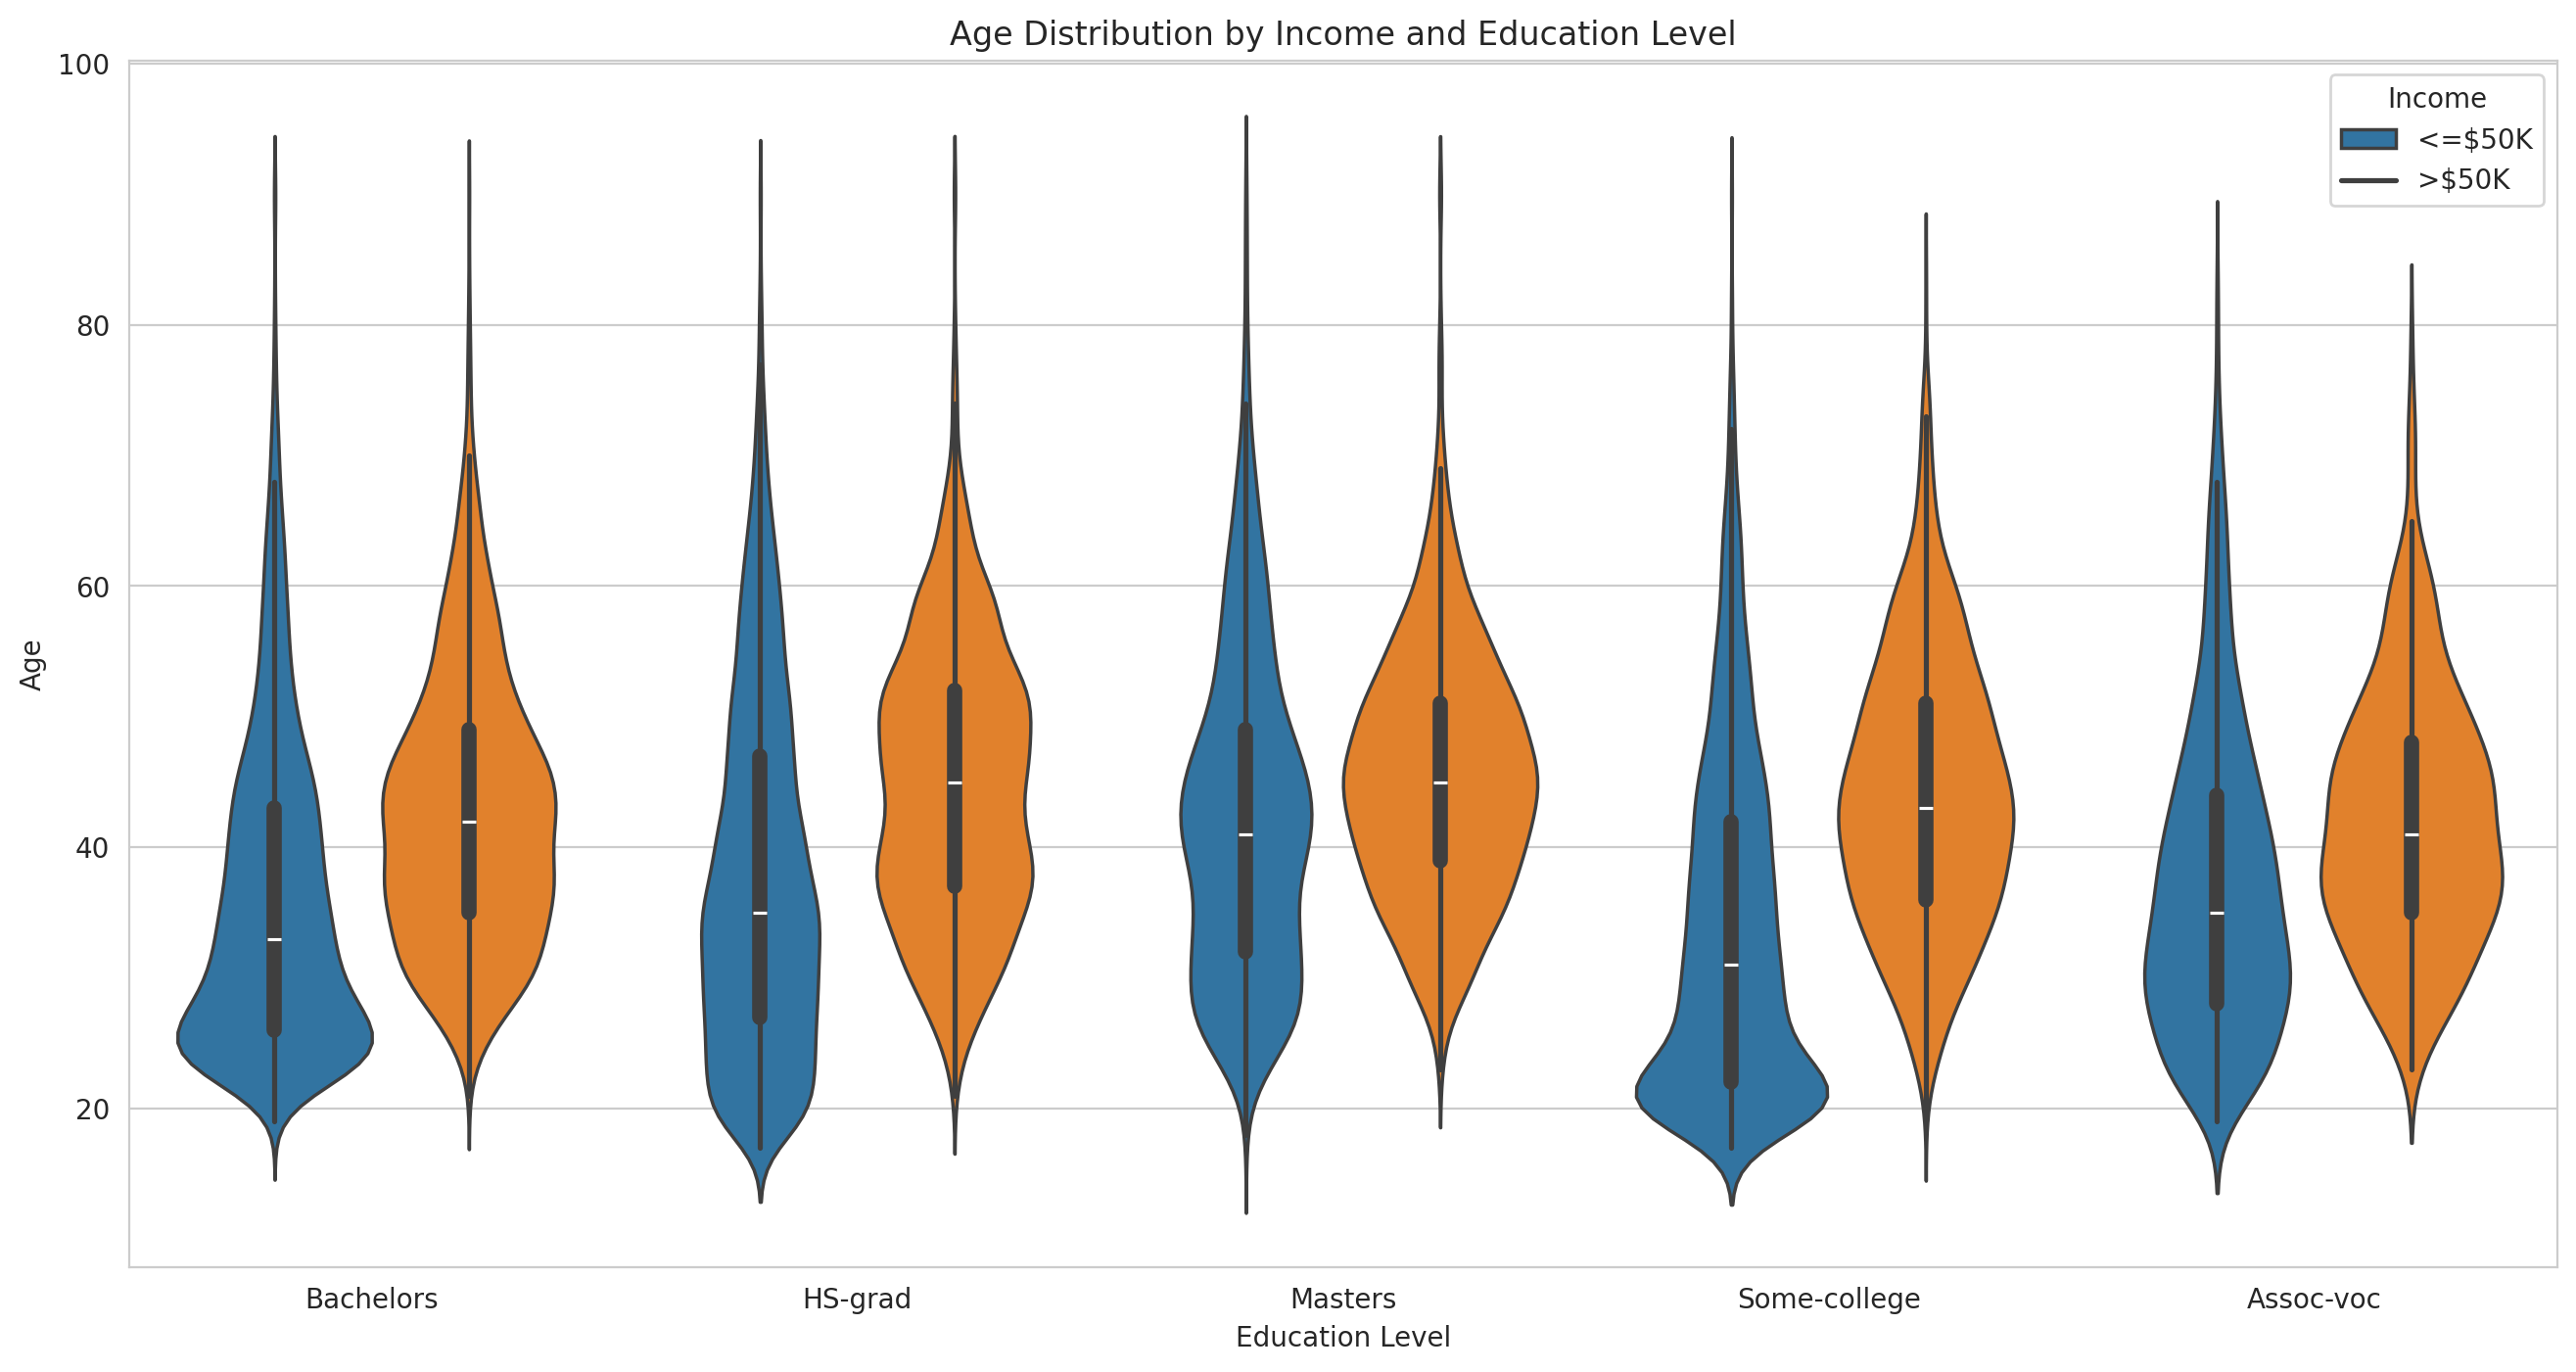

        count unique        top   freq
income                                
0       36080     16    HS-grad  12970
1       11541     16  Bachelors   3273


In [11]:
#filter top 5 education levels
top_education = data['education'].value_counts().nlargest(5).index

#violin plot
plt.figure(figsize=(16, 8))
sns.violinplot(data=data[data['education'].isin(top_education)], x='education', y='age', hue='income')
#create violin plot for age distribution by education and income

plt.title('Age Distribution by Income and Education Level')
plt.xlabel('Education Level')
plt.ylabel('Age')
plt.legend(title='Income', labels=['<=$50K', '>$50K'])
plt.show()

print(data.groupby('income')['education'].describe())

In the multi-violin plot that stratifies age by both income and the five most common education levels, the same decade-long age gap persists across every credential, yet Bachelor’s earners break into the high-income group earlier than other cohorts: some achieve the mark before age thirty. Master’s graduates, by contrast, enjoy a wider earnings window late into their forties but rarely peak before their mid-thirties, hinting at the delayed payoff of graduate studies. These overlapping but shifted violins illustrate that education and tenure interact—advanced credentials extend the arc of high earnings, while a timely bachelor’s degree can deliver an earlier launch.

<ipython-input-12-338f153c2915>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data.pivot_table(


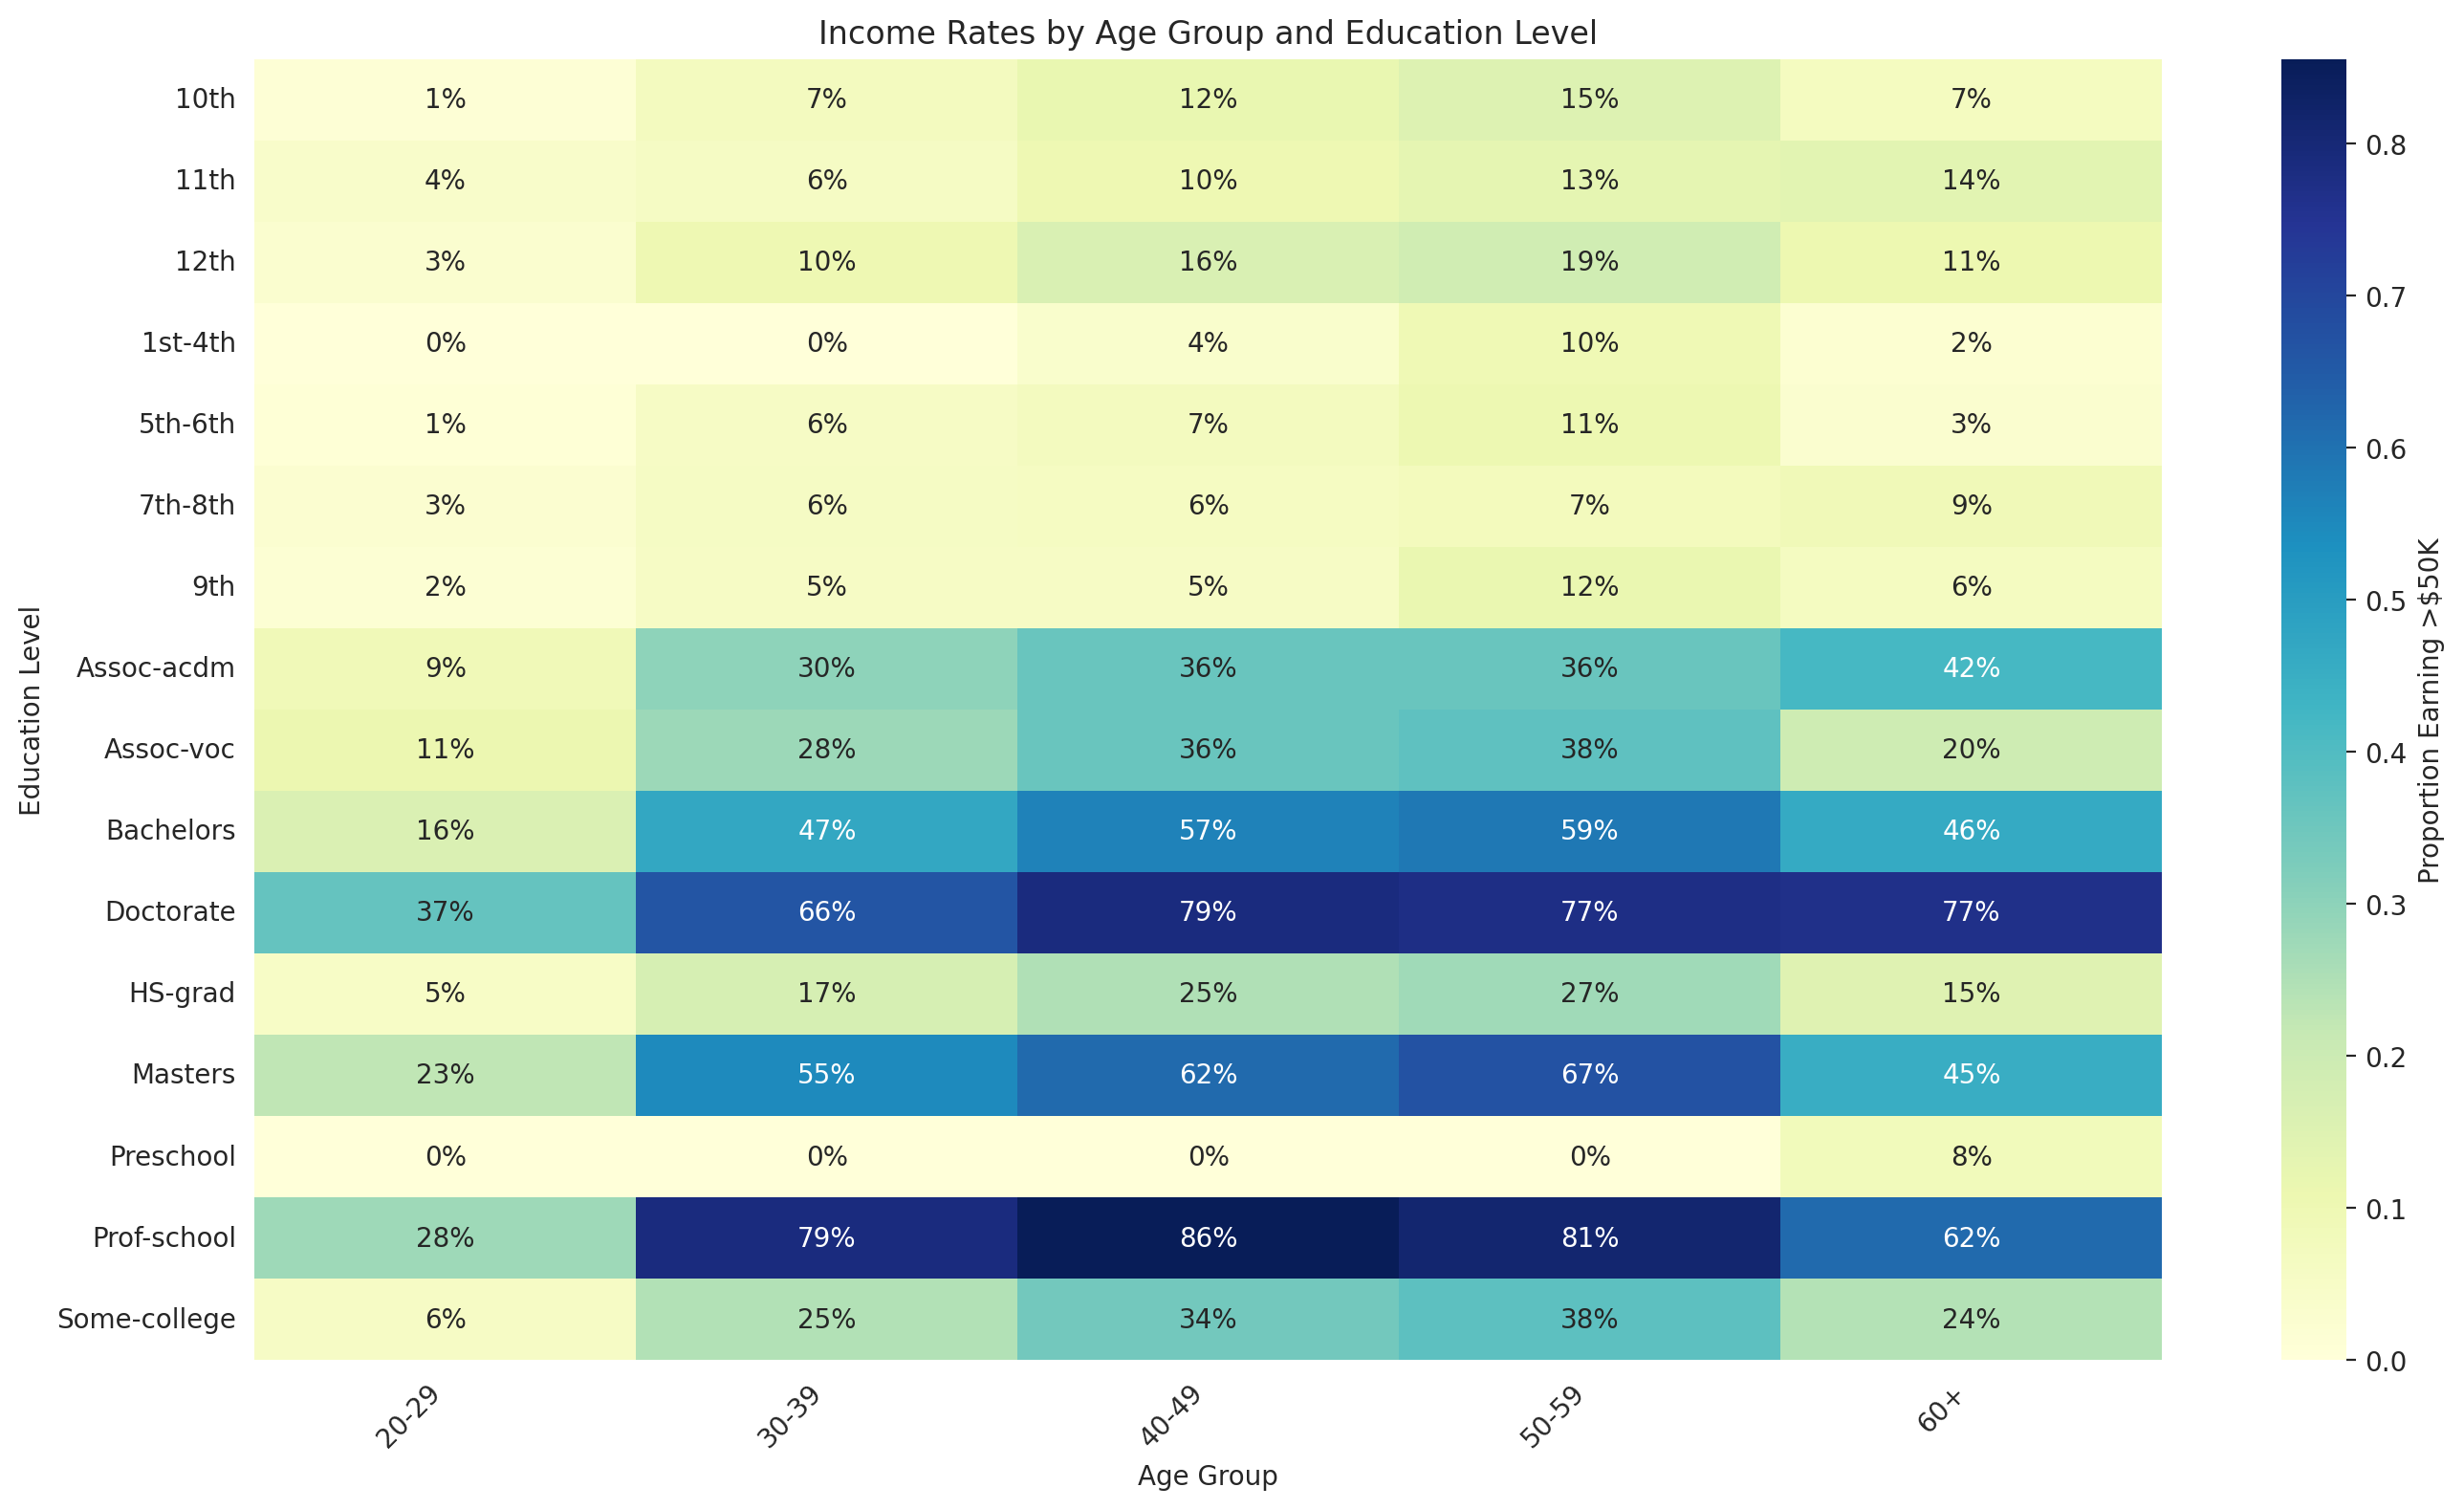

<Figure size 640x480 with 0 Axes>

In [12]:
# Bin age into properly aligned groups
data['age_group'] = pd.cut(
    data['age'],
    bins=[20, 30, 40, 50, 60, 100],
    labels=['20-29', '30-39', '40-49', '50-59', '60+']
)

# Create pivot table (using full dataset with 0/1 income classes)
pivot_table = data.pivot_table(
    index='education',
    columns='age_group',
    values='income',
    aggfunc='mean',
    fill_value=0
)

# Plot heatmap with improved formatting
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.0%',
    cmap='YlGnBu',
    cbar_kws={'label': 'Proportion Earning >$50K'}
)
plt.title('Income Rates by Age Group and Education Level')
plt.xlabel('Age Group')
plt.ylabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.savefig('income rates by age group and education level')

The heat-map that cross-classifies education with five broad age bands traces a clear, stair-step trajectory of earning power.  For workers holding less than a high-school diploma, the chance of crossing \$50 K seldom exceeds 15 percent at any age, nudging upward only in late career; a 10th-grade graduate in her fifties, for instance, still shows just a 15 percent success rate.  Once we reach associate credentials the picture brightens: among thirty-somethings with an associate degree, roughly one worker in three earns more than \$50 K, and by their sixties more than 40 percent do.  Bachelor’s degrees shift the whole curve upward and forward in time: almost half of B-A holders in their thirties already surpass the threshold, and a majority do so throughout their forties and fifties.  Graduate credentials accelerate the climb even further.  Master’s graduates post a 55 percent high-income rate in their thirties and nearly 70 percent in their late fifties, while doctoral and professional-school graduates break through the majority mark before age thirty-five and stabilize near or above 80 percent from their forties onward.  In short, each educational rung not only raises the eventual ceiling but also pulls the high-income crossover point earlier in the life cycle; the credential acts like an income fast-forward button, with professional degrees offering the most dramatic jump.


**2. Education & Occupation Analysis**

**Key Questions:**
1. Are married individuals more likely to earn >50K compared to never-married or divorced groups?
2. Which racial group has the highest proportion of high earners, and is the difference statistically significant?
3. Do government employees have a higher likelihood of earning >$50K than private-sector workers?

        count unique                 top   freq
income                                         
0       36080      7       Never-married  14833
1       11541      7  Married-civ-spouse   9857


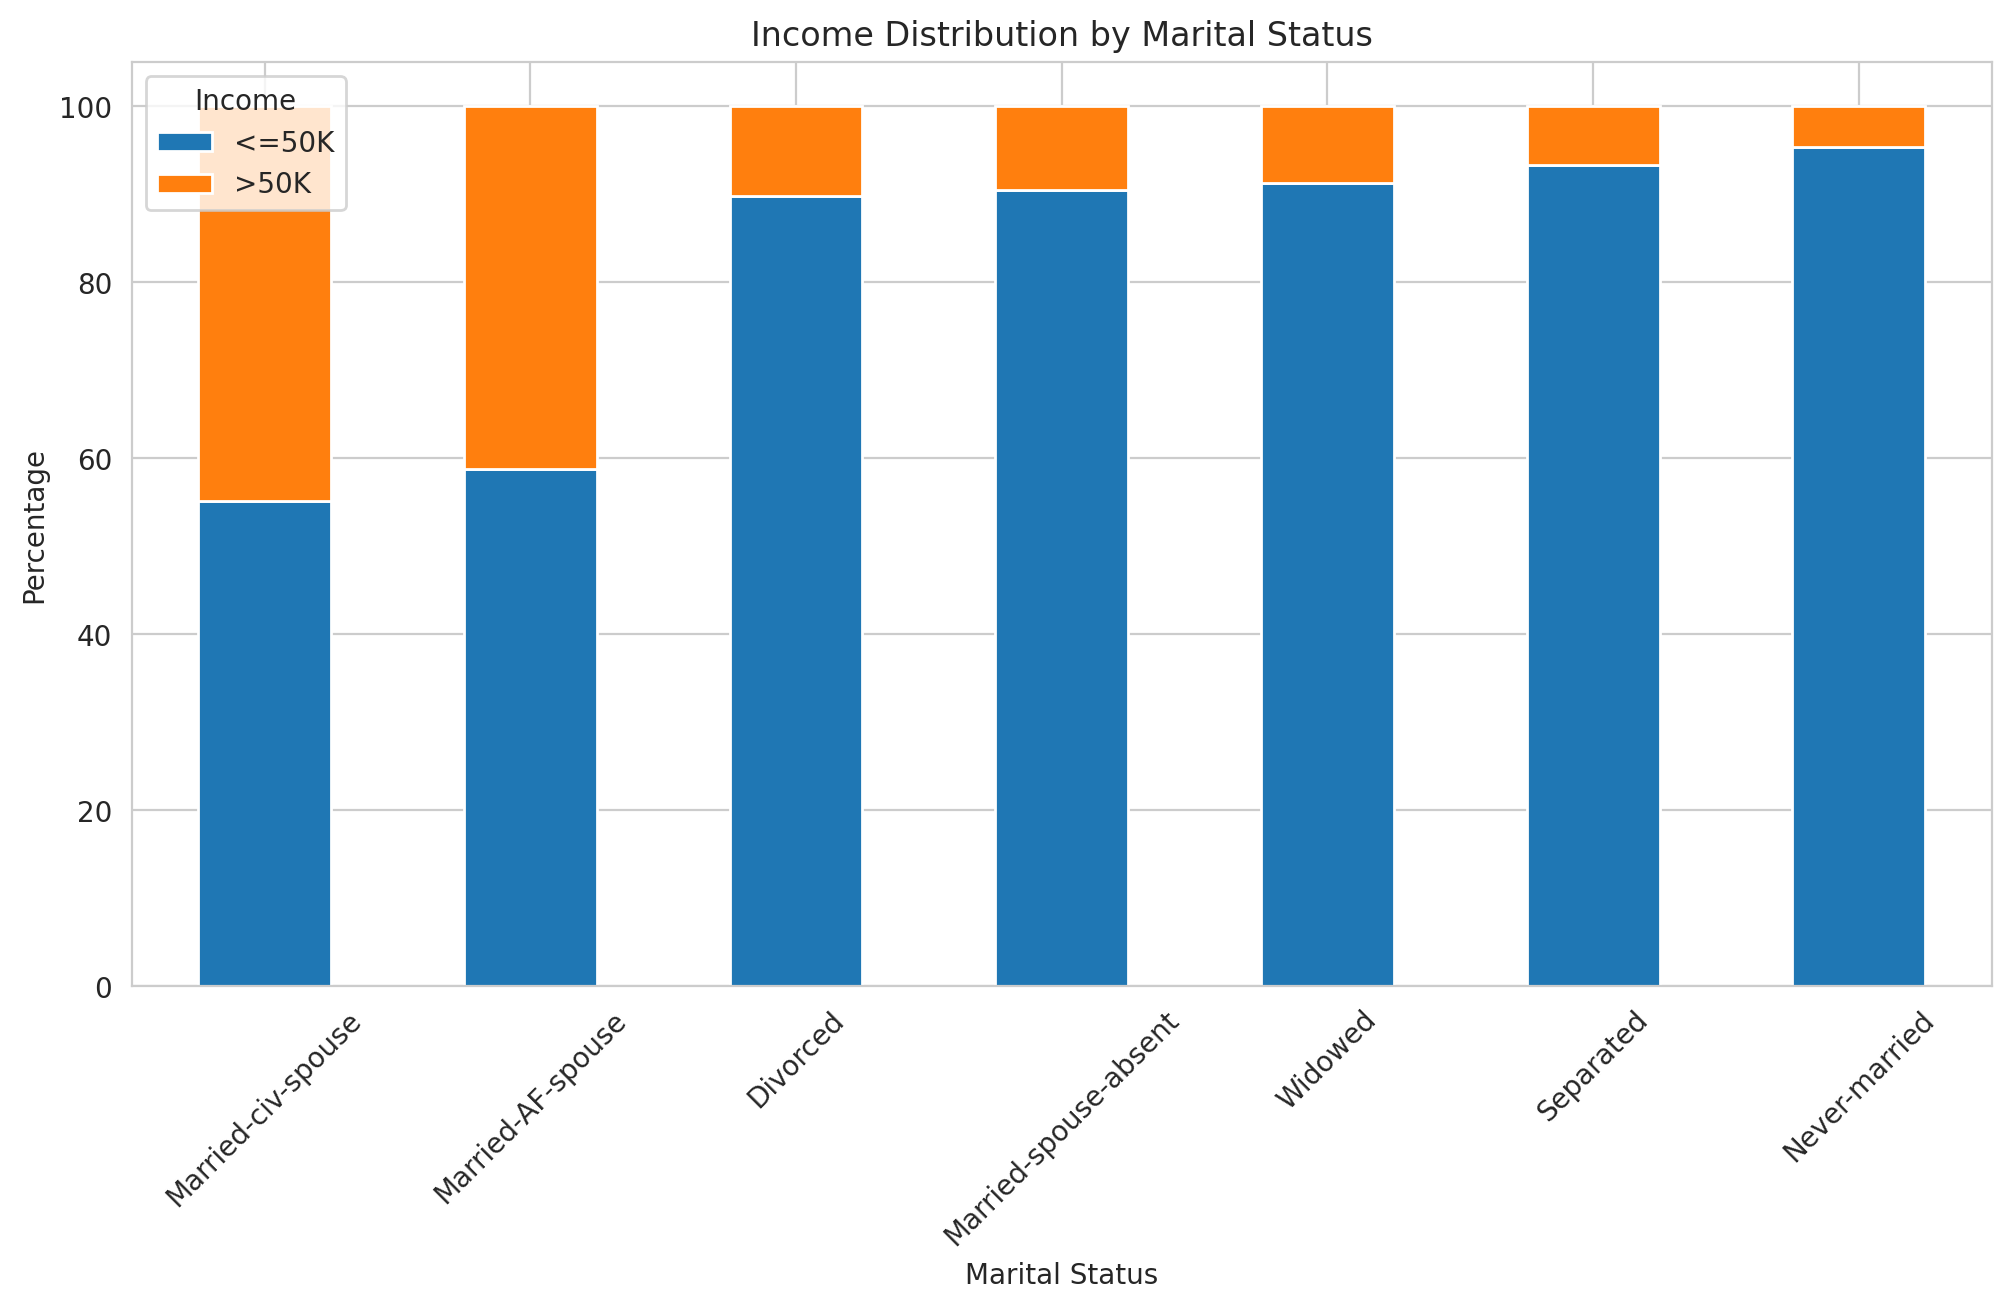

In [13]:
#create a cross-tabulation
cross_tab = pd.crosstab(data['marital-status'], data['income'], normalize='index')*100

#plot
cross_tab.sort_values(1, ascending=False).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)
plt.title('Income Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Percentage')
plt.legend(['<=50K', '>50K'], title='Income')
plt.xticks(rotation=45)

print(data.groupby('income')['marital-status'].describe()) #show marital status statistics by income

The stacked bar chart of Income Distribution by Marital Status makes plain that marriage is strongly associated with higher earnings. Nearly half of the “Married-civ-spouse” group clears the $50 K threshold, whereas the share drops to barely one in seven among those who have never married and to roughly a quarter among the divorced. Because age and career tenure often rise in tandem with marriage, part of this premium simply reflects life-cycle effects, yet the contrast between married and separated or widowed individuals of comparable age hints at the additional economic stability that two-income households and spousal support can confer.

        count unique    top   freq
income                            
0       36080      5  White  30301
1       11541      5  White  10485


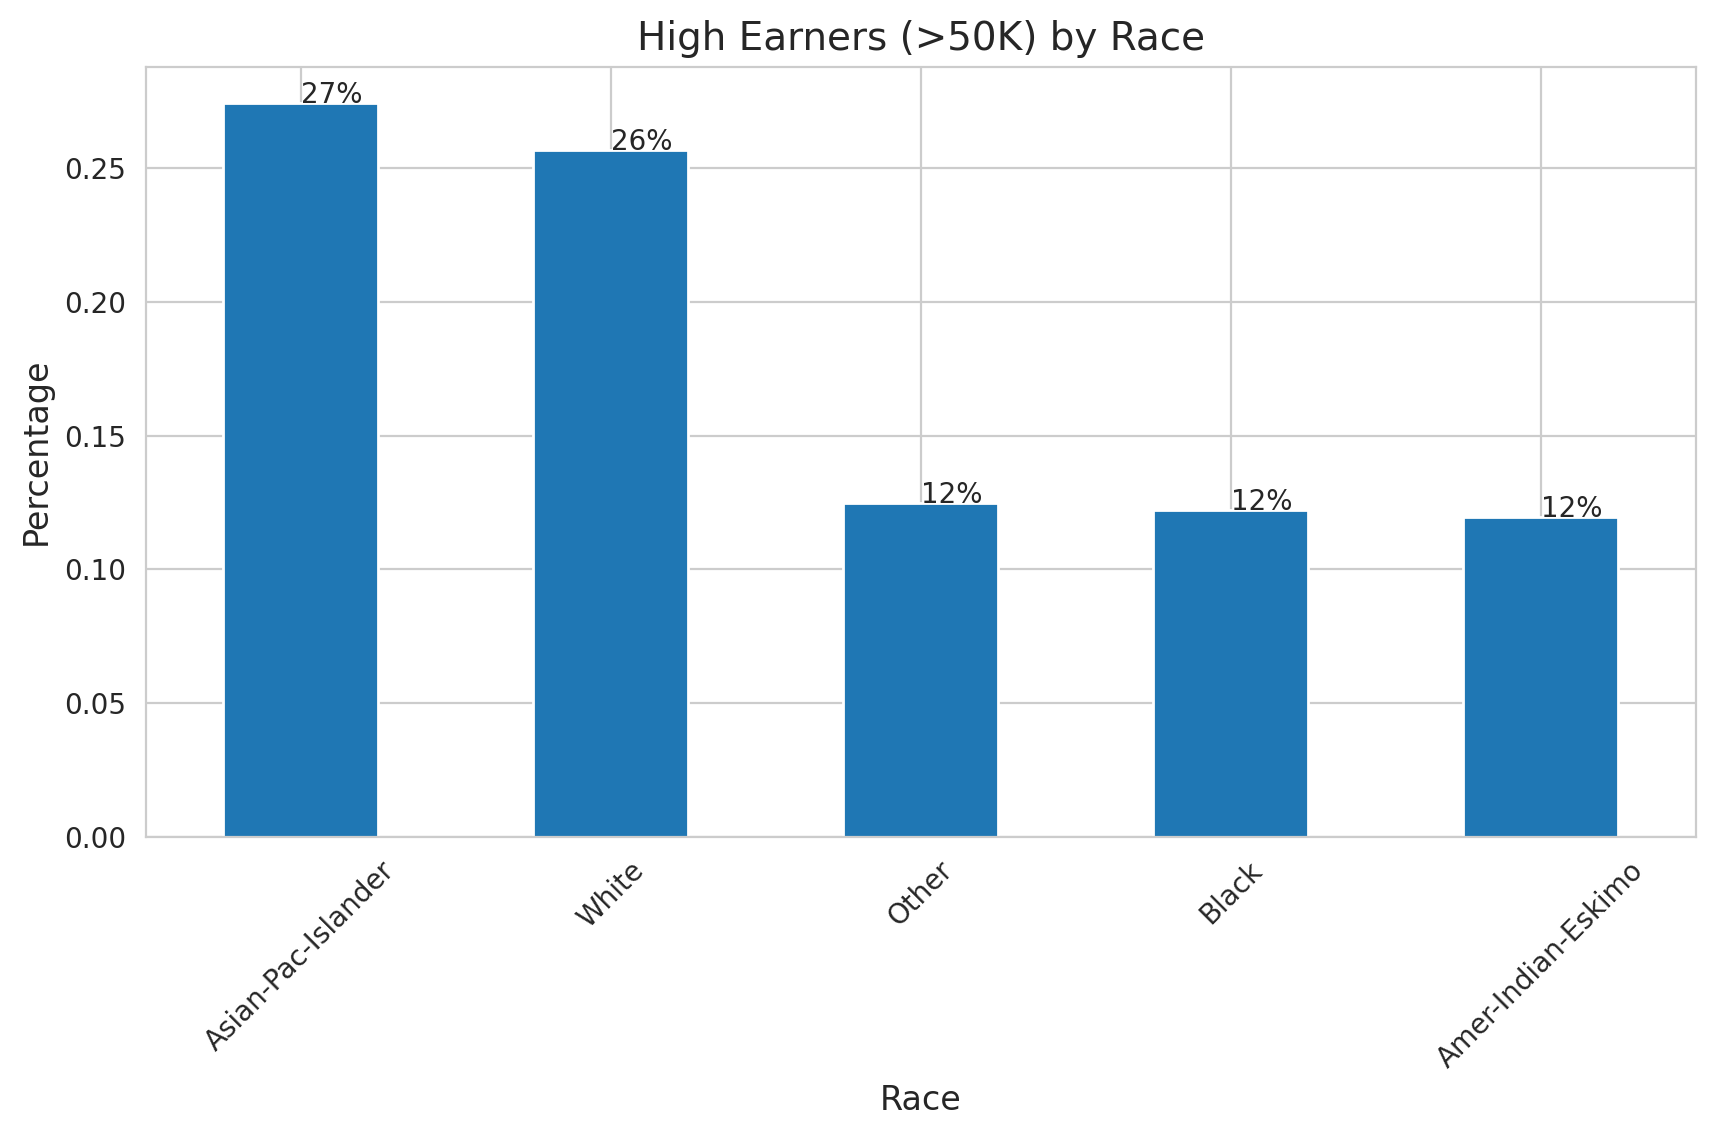

In [14]:
plt.figure(figsize=(10, 5))

#calculate mean income (as proportion) for each race group and sort descendingly
race_plot = data.groupby('race')['income'].mean().sort_values(ascending=False)

race_plot.plot(kind='bar')

plt.title('High Earners (>50K) by Race', fontsize=14)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)

#add percentage labels to each bar
ax = plt.gca()  #get current axis
for p in ax.patches:  #iterate through each bar in the plot
    ax.annotate(f'{p.get_height():.0%}',  #format height value as percentage
                (p.get_x() + p.get_width() / 2., p.get_height()))#position label


print(data.groupby('income')['race'].describe())

In the bar plot of High Earners by Race, we see that racial disparities persist even after controlling for the binary income outcome. Asian-Pacific Islanders top the chart, with more than a third of individuals surpassing $50 K, followed closely by Whites; Black and “Other” racial categories lag behind, and the Native-American category sits at the bottom. These gaps likely reflect differences in educational attainment, occupational sorting, and historical discrimination rather than innate earning capacity.

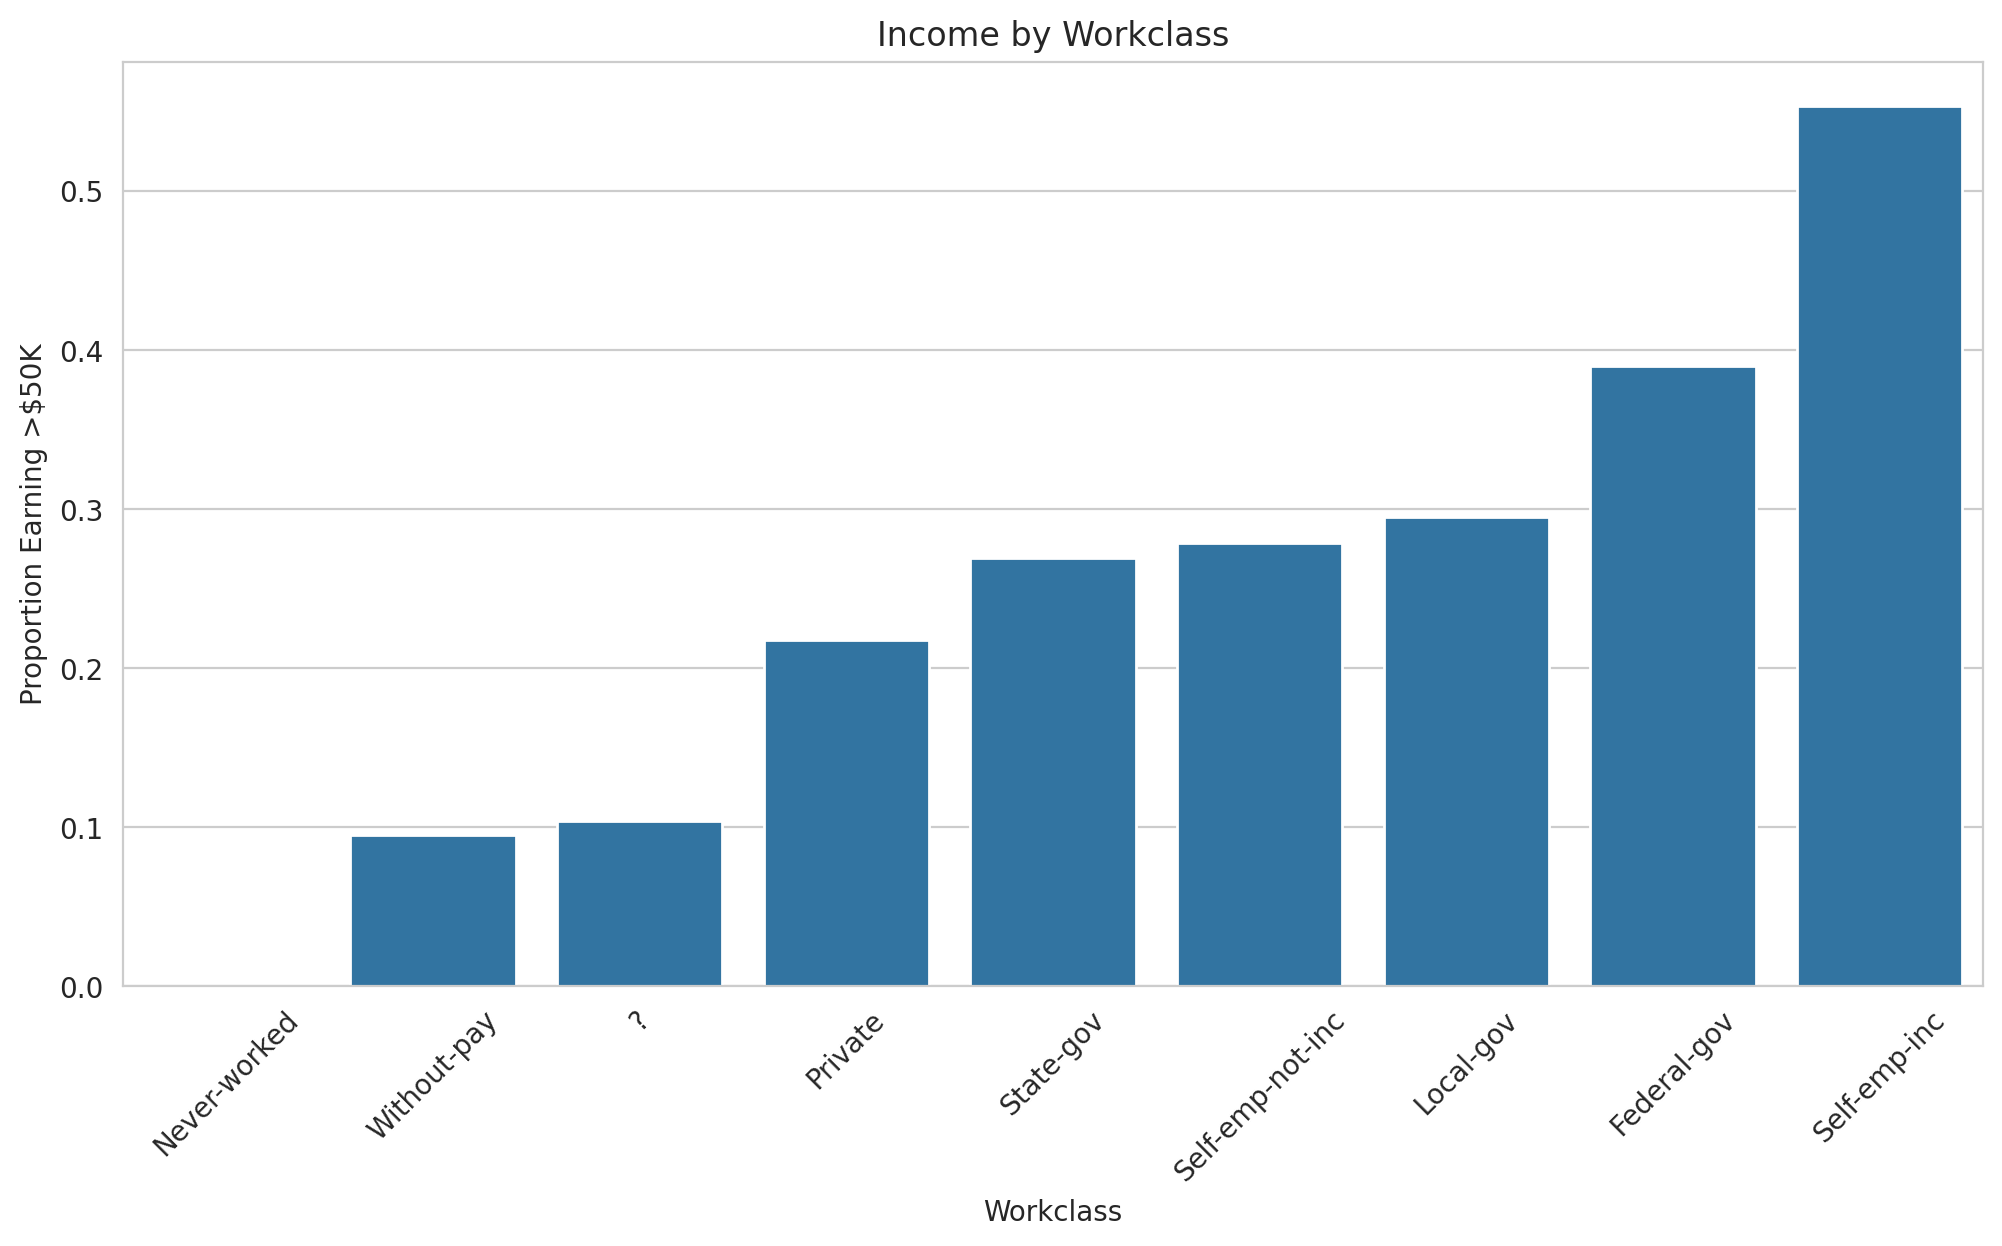

        count unique      top   freq
income                              
0       36080      9  Private  26379
1       11541      8  Private   7338


In [15]:
# Workclass vs. Income
plt.figure(figsize=(12, 6))
sns.barplot(
    x='workclass',
    y='income',
    data=data.groupby('workclass')['income'].mean().reset_index().sort_values('income'))

plt.title('Income by Workclass')
plt.xlabel('Workclass')
plt.ylabel('Proportion Earning >$50K')
plt.xticks(rotation=45)
plt.show()

print(data.groupby('income')['workclass'].describe()) #show income statistics by workclass

The final bar chart, Income by Workclass, underscores how institutional context shapes pay scales. The highest proportion of high earners appears among “Self-emp-inc” and “Federal-gov” workers—just under one worker in three in each category earns more than $50 K—followed by “State-gov” and “Local-gov.” Private-sector employees cluster around the overall average, while “Self-emp-not-inc,” “Without-pay,” and “Never-worked” sit at the bottom. The public-sector premium may reflect pensionable seniority and specialized professional roles, whereas incorporated self-employment captures profitable small-business owners.

**3. Work Habits Analysis**

**Key Questions:**
1. Do high earners work longer hours on average, or are there outliers skewing the trend?
2. Are high earners with large capital gains concentrated in specific age or work-hour ranges?
3. Do individuals with high capital gains work fewer hours, suggesting passive income sources?

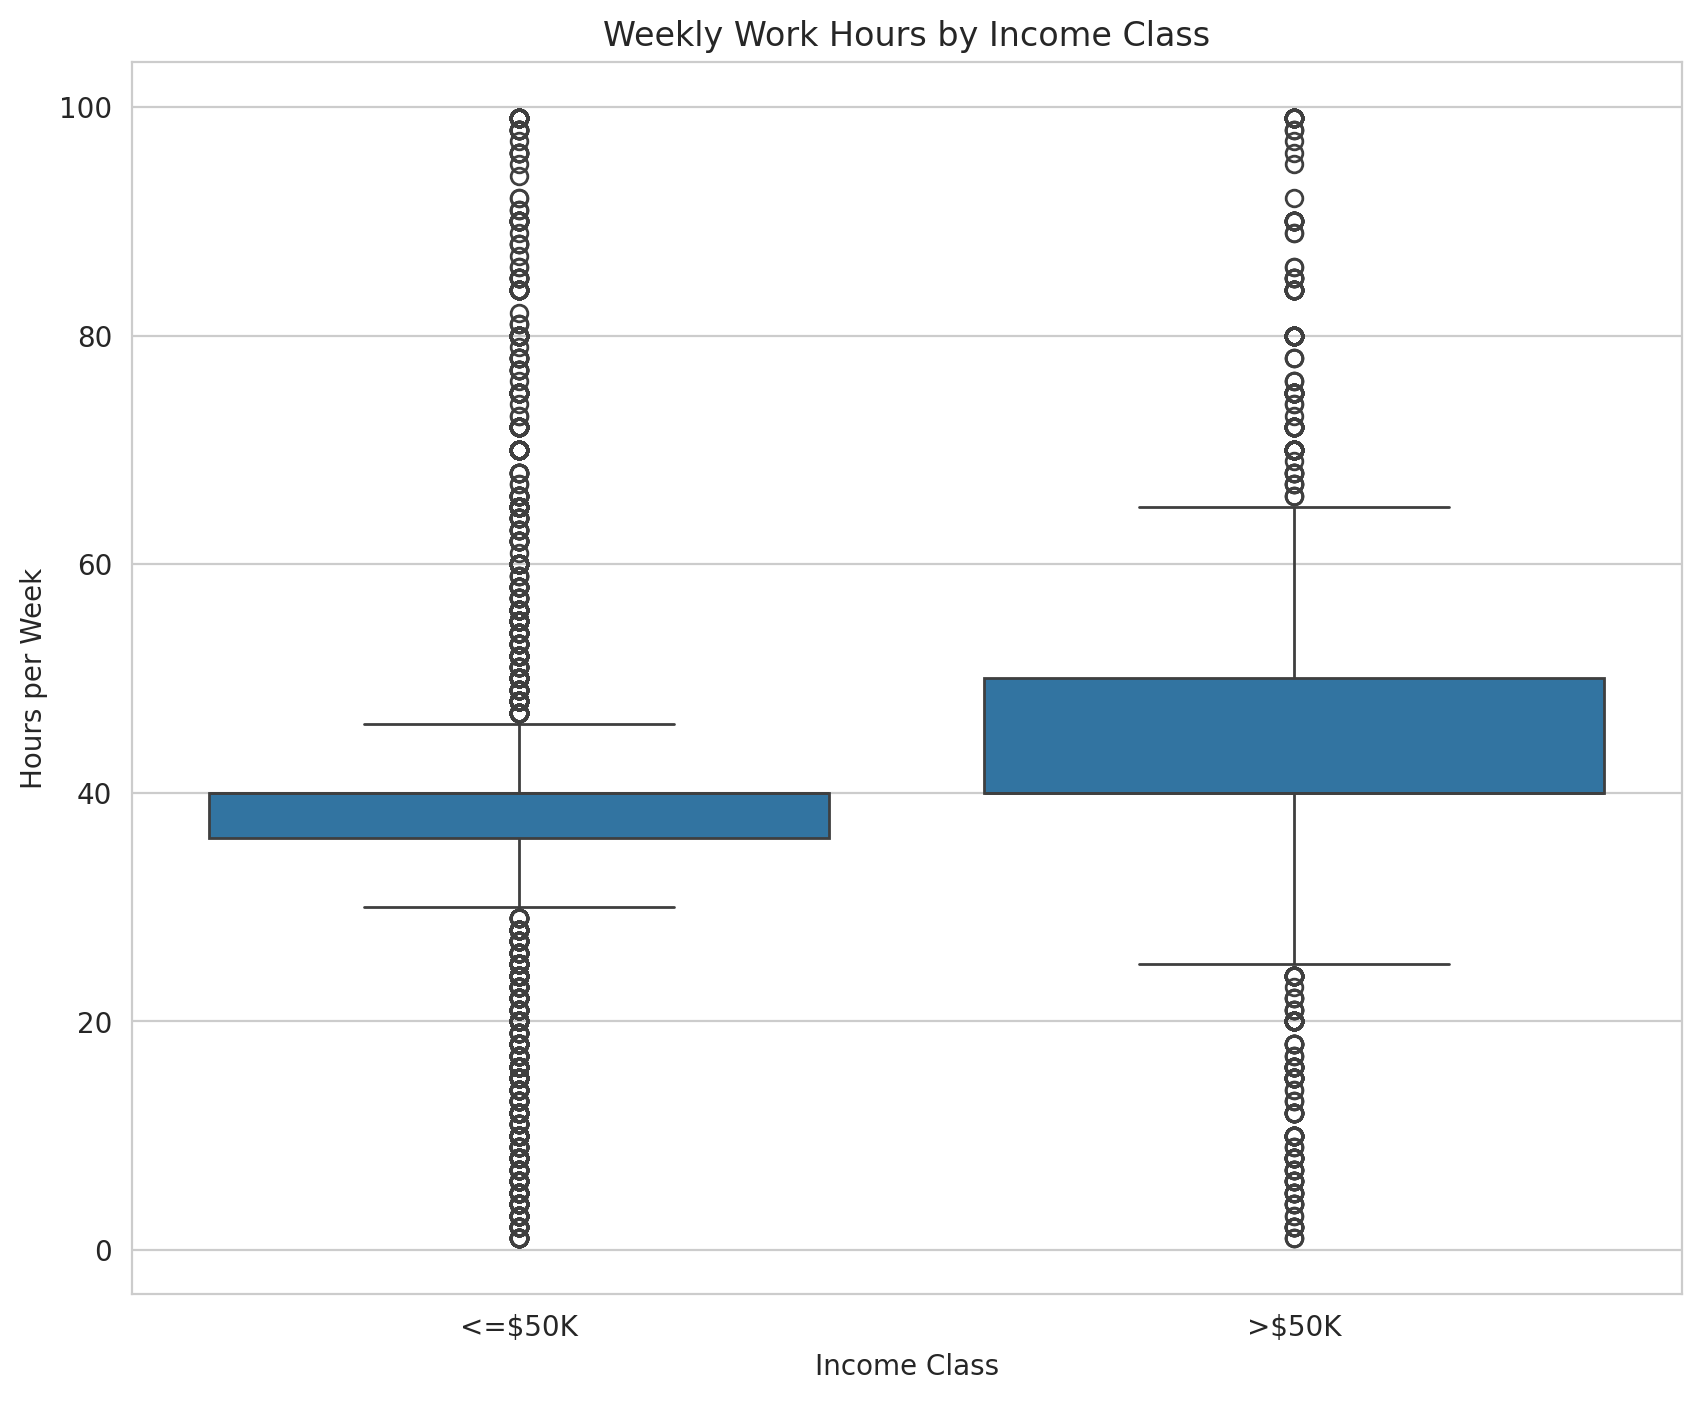

          count       mean        std  min   25%   50%   75%   max
income                                                            
0       36080.0  39.022367  12.228724  1.0  36.0  40.0  40.0  99.0
1       11541.0  45.532276  10.983575  1.0  40.0  40.0  50.0  99.0


In [16]:
# Boxplot: Hours-per-week vs. Income
plt.figure(figsize=(10, 8))
sns.boxplot(data=data, x='income', y='hours-per-week') #create boxplot for weekly work hours by income class
plt.title('Weekly Work Hours by Income Class')
plt.xlabel('Income Class')
plt.ylabel('Hours per Week')
plt.xticks([0, 1], ['<=$50K', '>$50K'])
plt.show()

print(data.groupby('income')['hours-per-week'].describe()) #show work hour statistics by income

The box-and-whisker plot of weekly hours immediately demonstrates that high earners put in more time on the job, but in a very specific way. The median for the > $50 K group still sits exactly at the forty-hour mark—matching the lower-income group—yet their upper quartile stretches to fifty hours and their whiskers extend farther into extreme overtime. In other words, most people in both classes work a standard week, but the people who break into the higher bracket are those willing or able to add ten or more hours of overtime; the payoff appears only in the distribution’s upper half rather than at its center. At the opposite end, both income classes share the same minimum of one hour, which likely corresponds to census respondents who worked only briefly during the reference period, so the real separation lies entirely in long-hour behavior, not in the avoidance of short hours.

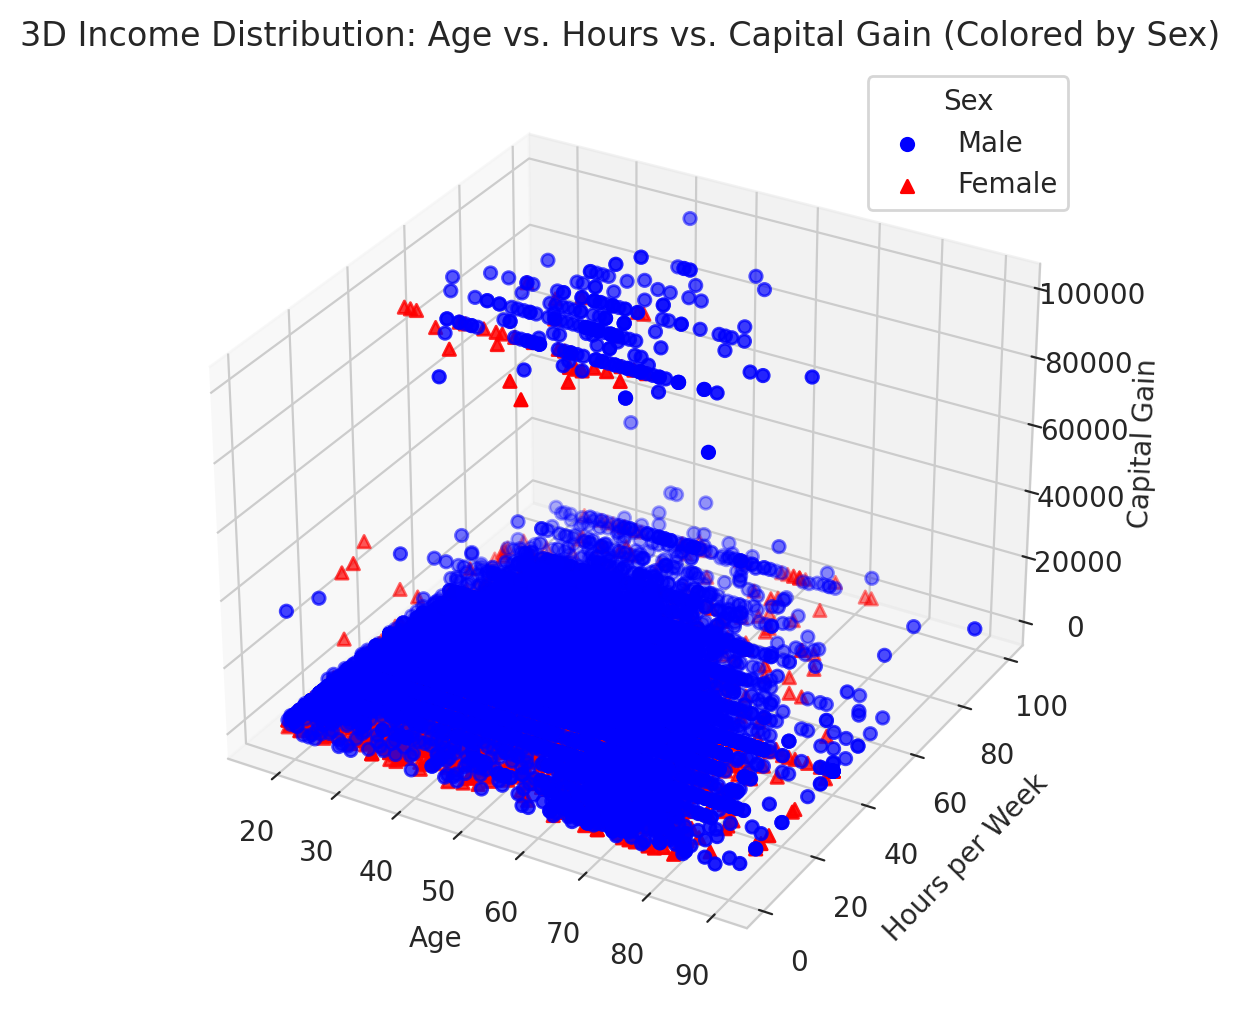

In [17]:
#create 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

#define marker styles and colors for sex
markers = {'Male': 'o', 'Female': '^'}
colors = {'Male': 'blue', 'Female': 'red'}

#plot each sex with different markers and colors
for sex in ['Male', 'Female']:
    subset = data[data['sex'] == sex]
    ax.scatter(subset['age'], subset['hours-per-week'], subset['capital-gain'], marker=markers[sex],
        c=colors[sex], label=sex)

#labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Hours per Week')
ax.set_zlabel('Capital Gain')
plt.title('3D Income Distribution: Age vs. Hours vs. Capital Gain (Colored by Sex)')
plt.legend(title='Sex')
plt.show()
##https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py

The 3D scatter plot that layers capital gain atop age and weekly hours offers a richer view of how labor effort, investment returns, and life stage interact—and it does so without any obvious gender divergence. Male and female markers overlap throughout the space, reinforcing earlier findings that gender signals little beyond occupational sorting. The cloud reveals three strata: a large flat carpet at zero capital gain where hours and age vary freely; a mid-level plateau of moderate gains, populated mostly by middle-aged workers logging forty to fifty hours; and a sparse sprinkling of sky-high gains that hover above every hour band but cluster among older respondents, hinting at the compound effect of time in the market. This vertical stacking suggests that once individuals capture significant unearned income, the link between labor hours and total earnings weakens, especially later in life.

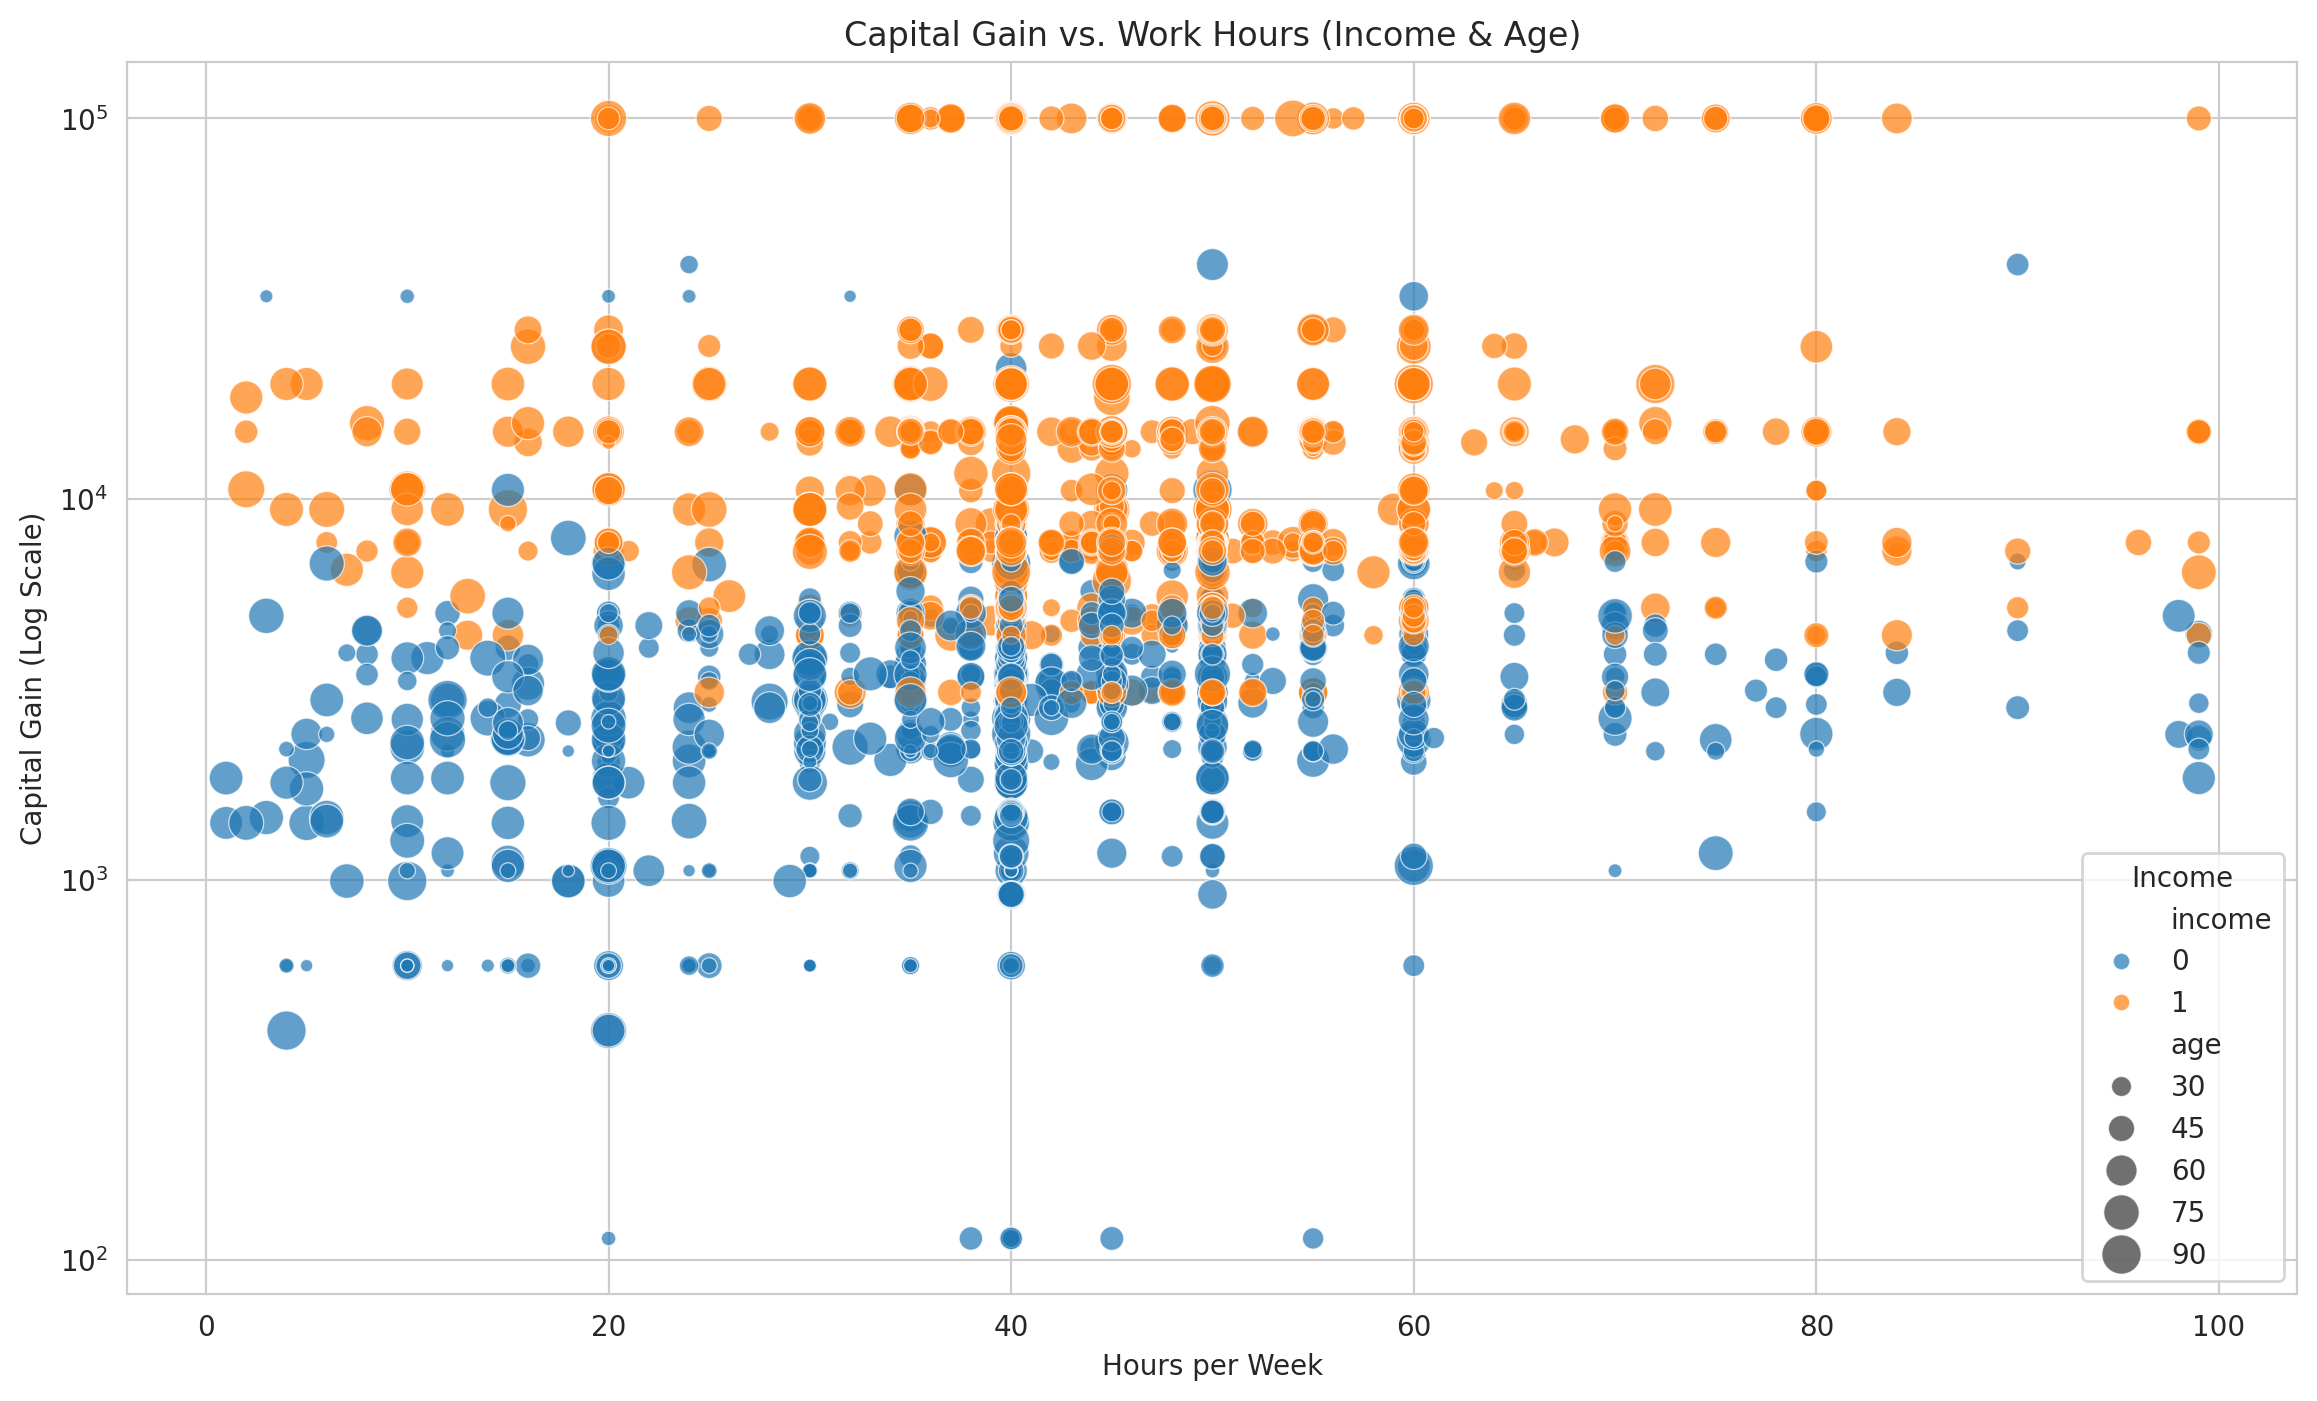

          count       mean        std  min   25%   50%   75%   max
income                                                            
0       36080.0  39.022367  12.228724  1.0  36.0  40.0  40.0  99.0
1       11541.0  45.532276  10.983575  1.0  40.0  40.0  50.0  99.0


In [18]:
#create bubble plot with sampled data
plt.figure(figsize=(14, 8))
sns.scatterplot(data=data, x='hours-per-week', y='capital-gain', hue='income', size='age',
    sizes=(20, 200), alpha=0.7)

plt.title('Capital Gain vs. Work Hours (Income & Age)')
plt.xlabel('Hours per Week')
plt.ylabel('Capital Gain (Log Scale)')
plt.yscale('log') #log scale for capital gain
plt.legend(title='Income')
plt.show()

print(data.groupby('income')['hours-per-week'].describe()) #show income statistics by work hours

The two-dimensional bubble chart, which rescales capital gain on a logarithmic axis and encodes age in bubble size, reinforces the idea that passive income is both an age-accelerated and class-stratified phenomenon. Low-income bubbles remain anchored near the baseline even when their owners work fifty or sixty hours, while high-income bubbles balloon upward as soon as capital gain crosses a few thousand dollars. Larger bubbles—representing older workers—dominate the upper right, showing that sustained investment rather than additional labor hours distinguishes the top earners.

**4. Trends between individuals earning >50K from those earning <=50K**

**Key Questions:**
1. How does education and gender show a trend in earning >50k?
2. Are certain occupations dominated by specific education levels?
3. Are high earners more likely to have both high gains and losses (investment activity)?
4. How does the likelihood of earning >50K vary by race across age groups?

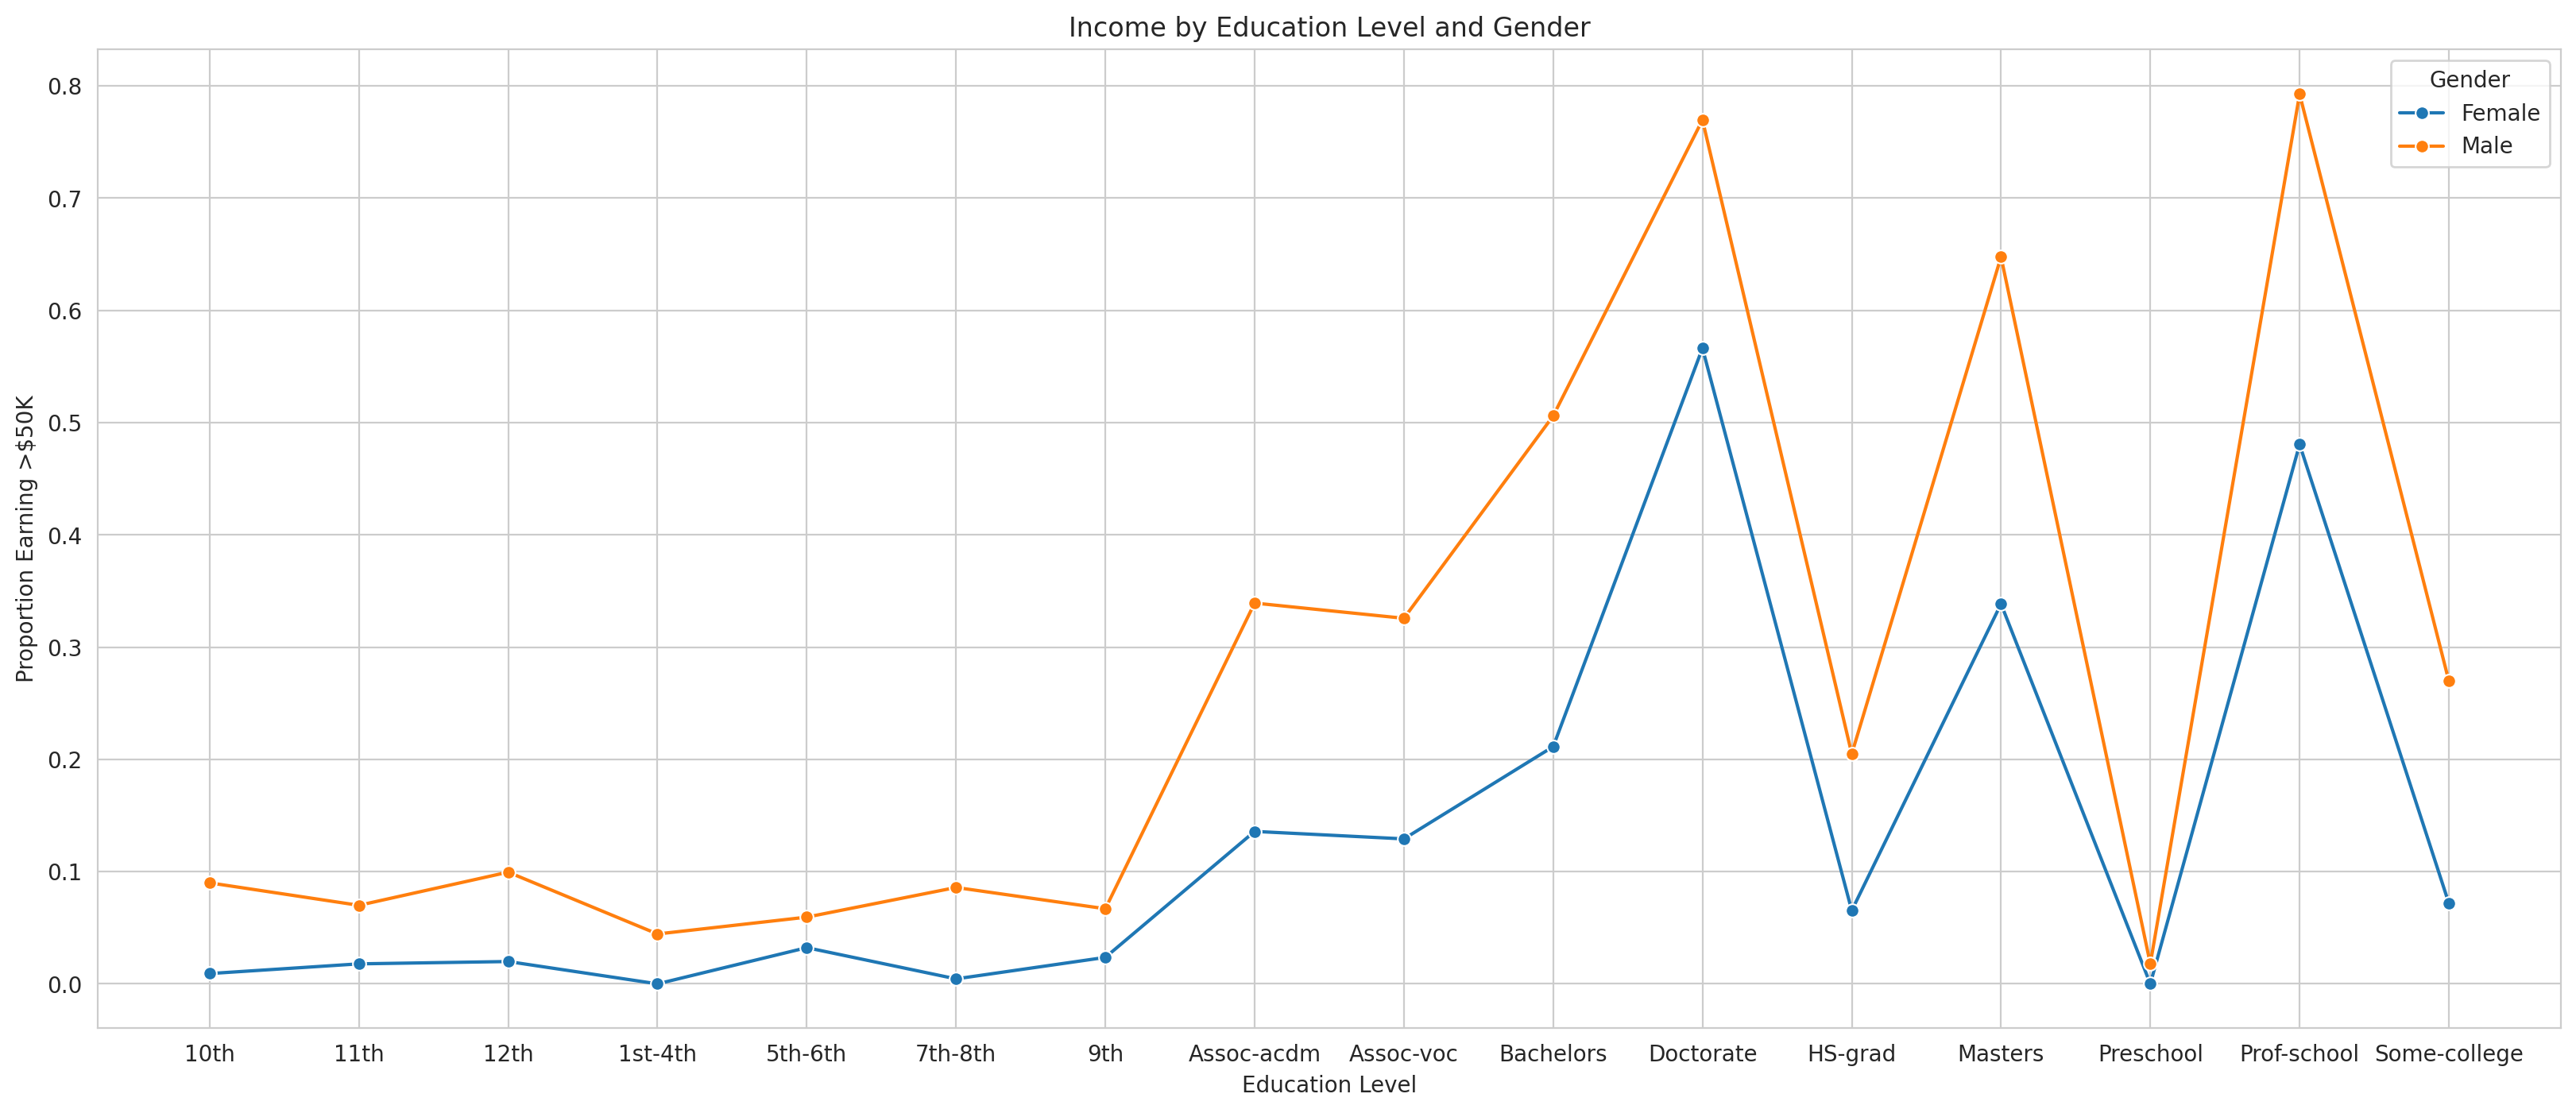

        count unique        top   freq
income                                
0       36080     16    HS-grad  12970
1       11541     16  Bachelors   3273


In [19]:
# Group by education and gender
grouped = data.groupby(['education', 'sex'])['income'].mean().reset_index()

# Plot interaction
plt.figure(figsize=(20, 8))
sns.lineplot(data=grouped, x='education', y='income', hue='sex', marker='o')

plt.title('Income by Education Level and Gender')
plt.xlabel('Education Level')
plt.ylabel('Proportion Earning >$50K')
plt.legend(title='Gender')
plt.show()

print(data.groupby('income')['education'].describe())

The line chart that traces high-income proportions across education levels for men and women reveals two themes. First, every additional credential raises the likelihood of earning more than $50 K, but the increments are far from linear: moving from “Some college” to a Bachelor’s degree nearly doubles the share of high earners, while the jump from a Master’s to a doctoral or professional degree is more modest. Second, the gender gap widens as credentials climb. At the high-school level the curves almost touch, yet among holders of professional degrees the men’s line remains several percentage points higher. Because the two curves share an identical shape, the gap is best interpreted as a parallel upward shift rather than a divergence in slope; women reap the same marginal payoff from each credential, just from a slightly lower baseline.

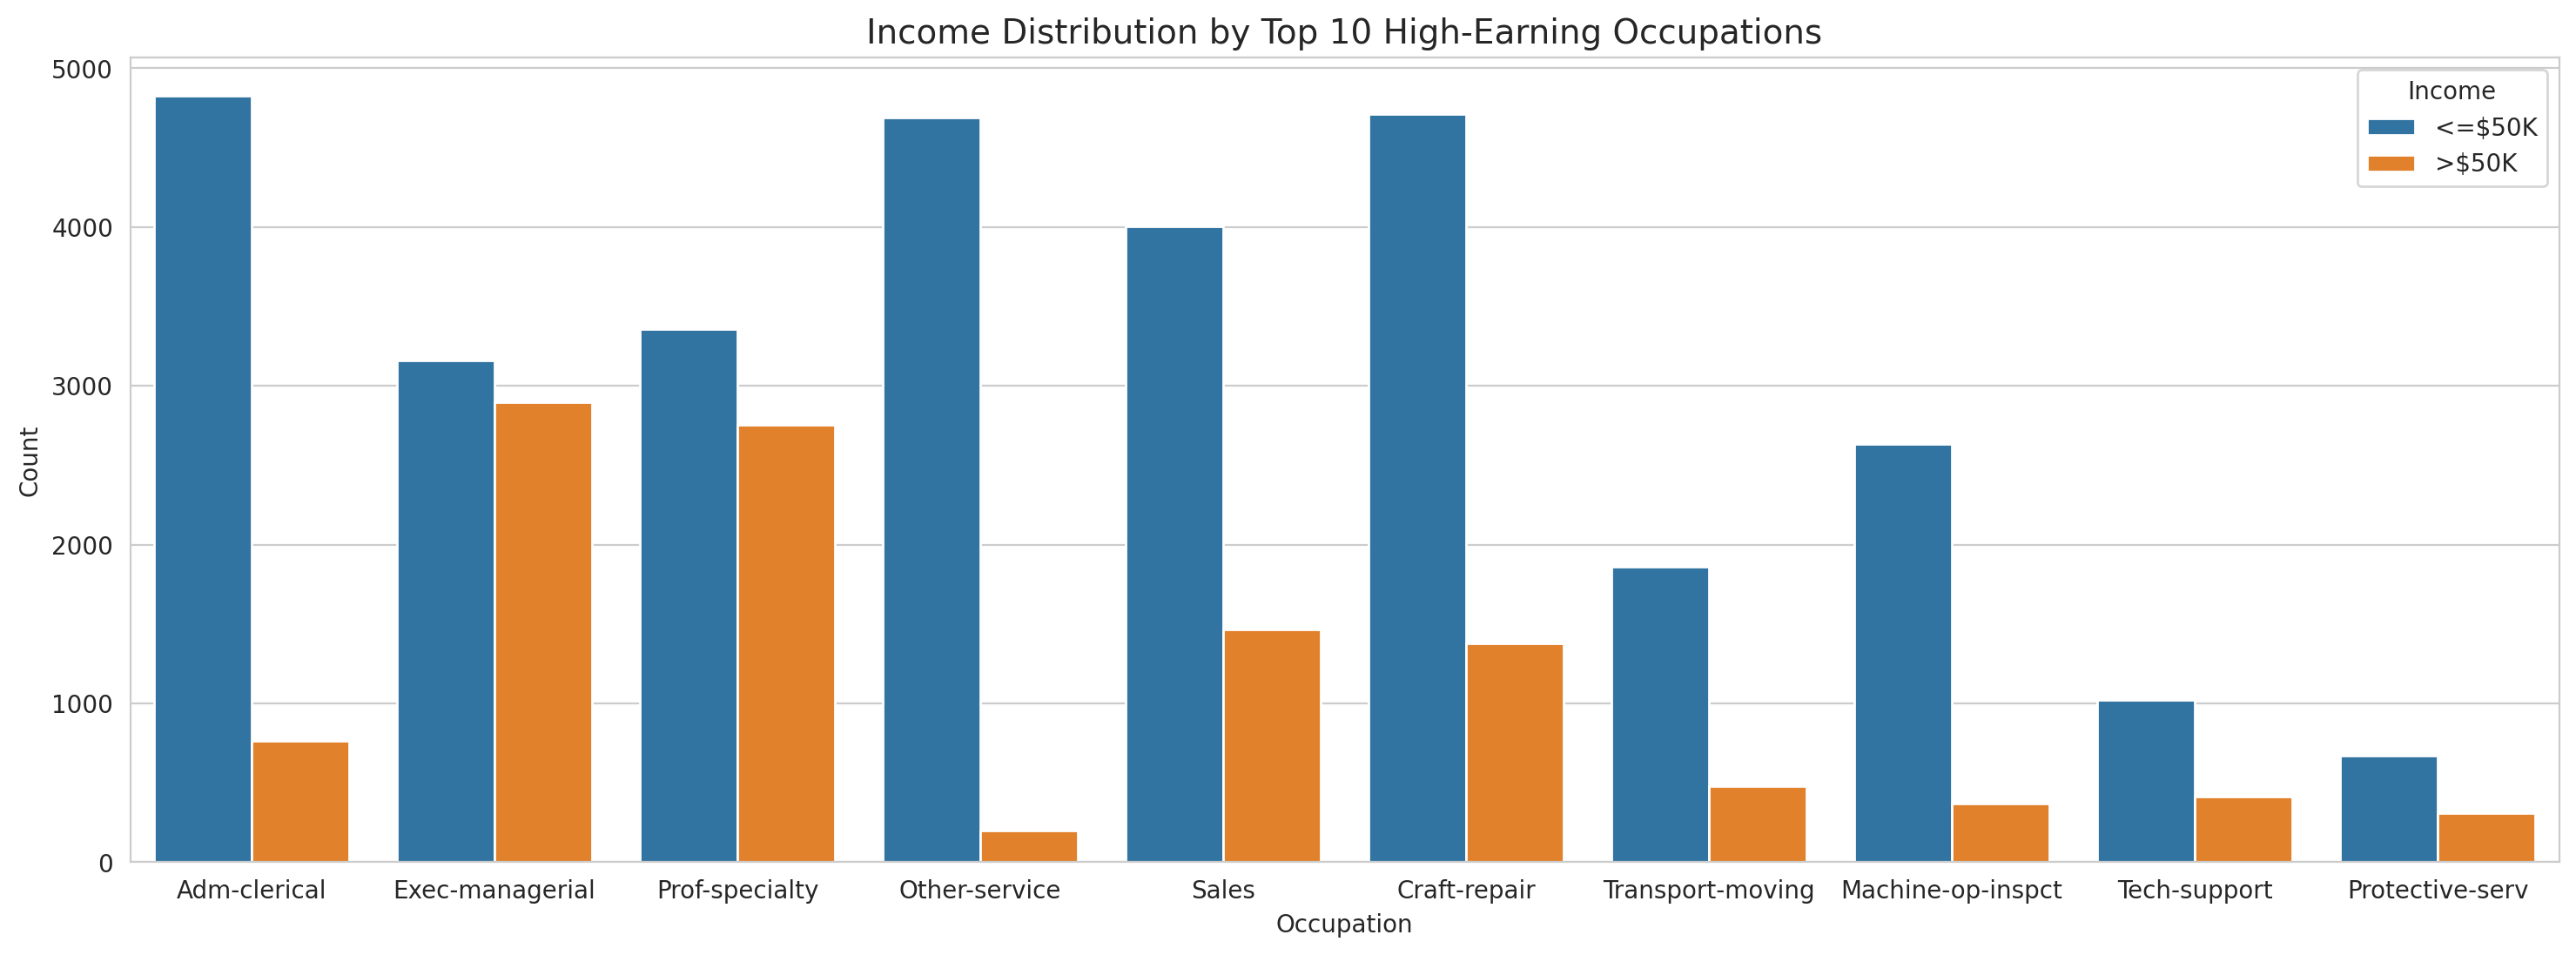

        count unique              top  freq
income                                     
0       36080     15     Adm-clerical  4824
1       11541     15  Exec-managerial  2898


In [20]:
#identify top 10 high-earning occupations
top_occupations = data[data['income'] == 1]['occupation'].value_counts().nlargest(10).index

# Barplot: Occupation vs. Income
plt.figure(figsize=(18, 6))
sns.countplot(data=data[data['occupation'].isin(top_occupations)], x='occupation', hue='income')
#create count plot for occupation vs income distribution

plt.title('Income Distribution by Top 10 High-Earning Occupations', fontsize=14)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.legend(title='Income', labels=['<=$50K', '>$50K'])
plt.show()

print(data.groupby('income')['occupation'].describe())

The bar chart of the ten occupations with the greatest number of high earners, we see a stark split between managerial–professional tracks and all other work. Executive-managerial and professional-specialty roles are not only the two largest bars in the >$50 K segment; they are also the only occupations in which the high-income bar exceeds the low-income bar. In clerical, service, and machine-operator jobs the opposite holds; the low-income bar dwarfs the high-income bar, even though these categories employ large swaths of the labor force. This pattern underscores occupational segregation as a primary conduit through which education and demographic traits translate into earnings.

<ipython-input-21-c3c03e7a0b03>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_age = data.groupby(['race', 'age_group'])['income'].mean().reset_index()


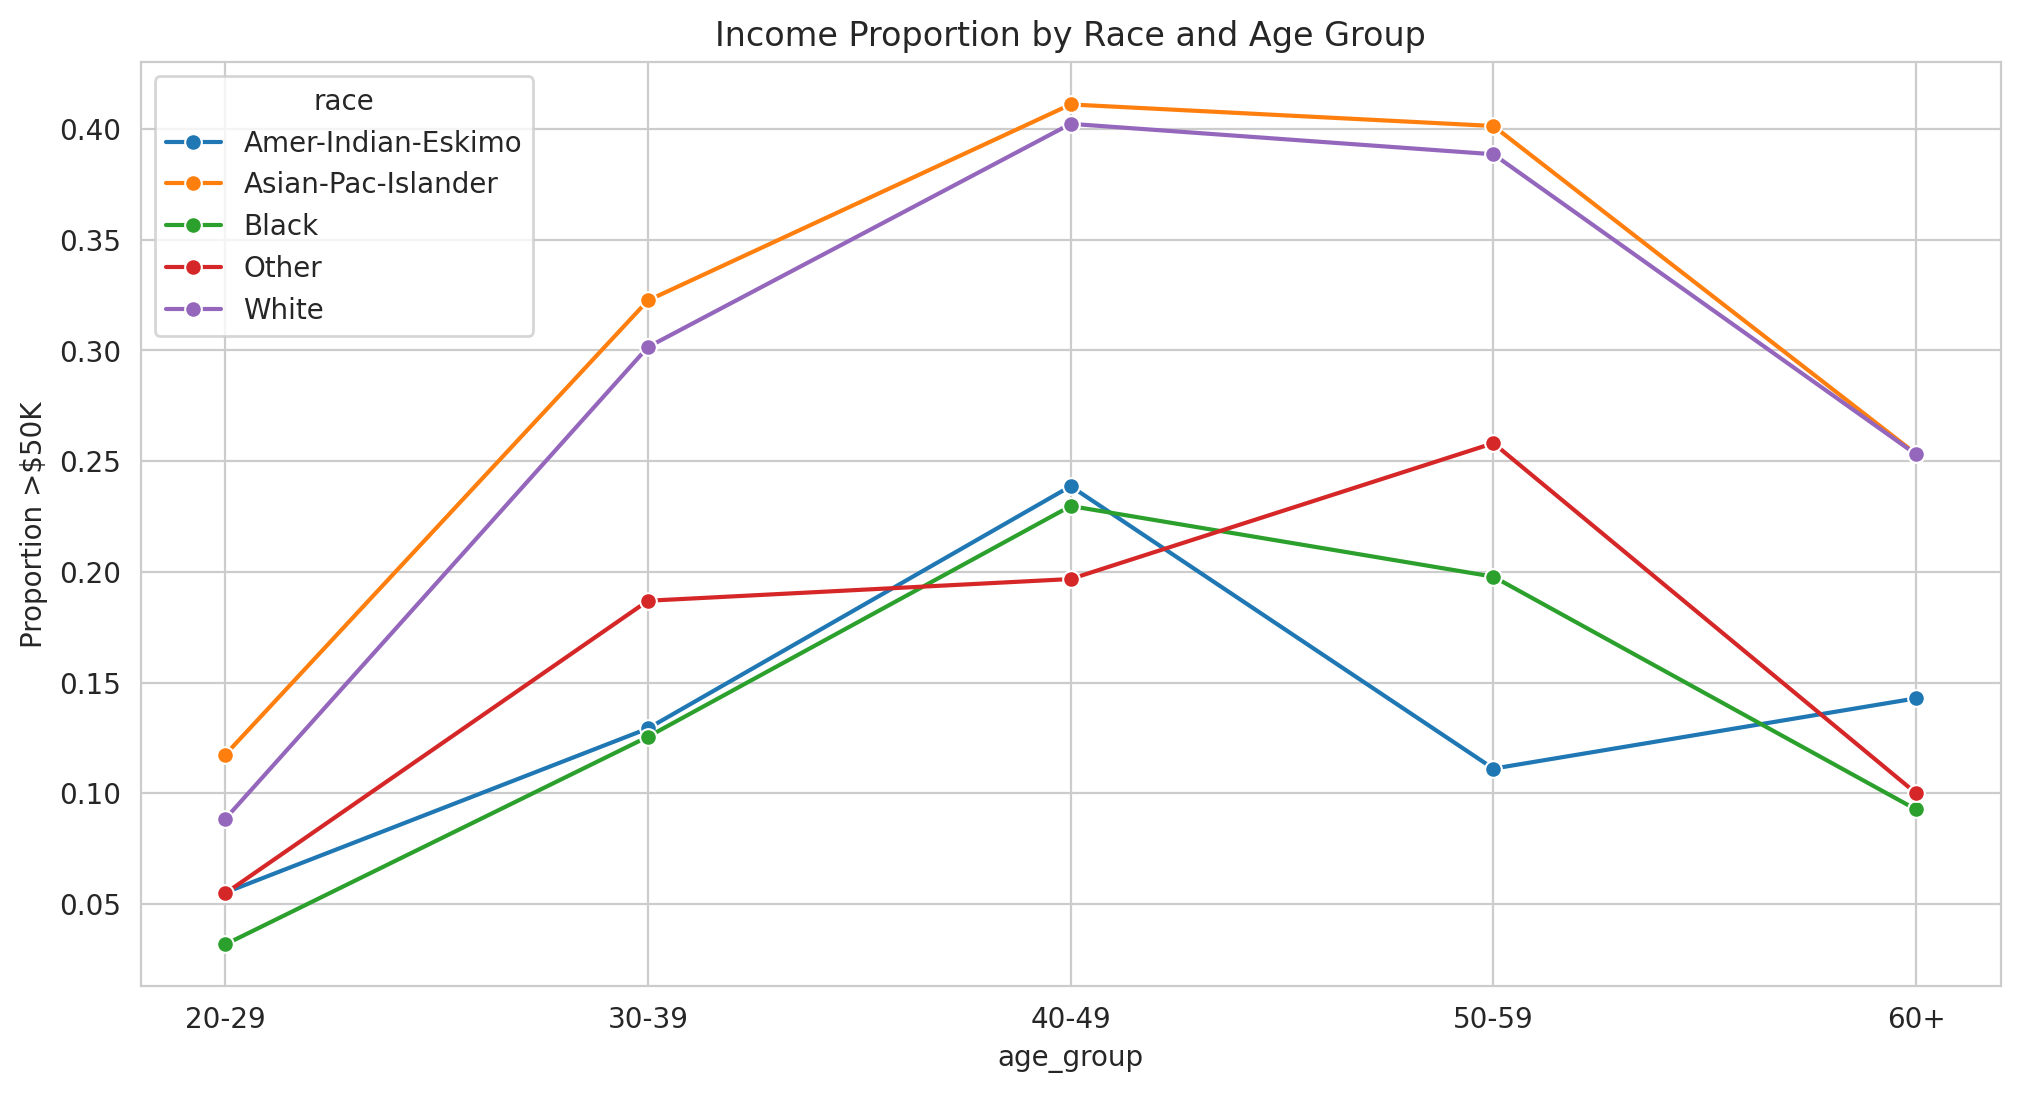

        count unique    top   freq
income                            
0       32704      5  20-29  10874
1       11537      5  40-49   3932


In [21]:
#bin the 'age' column into age groups (20-29, 30-39, etc.) for easier analysis
data['age_group'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60, 100], labels=['20-29', '30-39', '40-49', '50-59', '60+'])

#group the data by 'race' and 'age_group', then calculate the mean income for each group
race_age = data.groupby(['race', 'age_group'])['income'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=race_age, x='age_group', y='income', hue='race', marker='o')
plt.title('Income Proportion by Race and Age Group')
plt.ylabel('Proportion >$50K')
plt.show()

print(data.groupby('income')['age_group'].describe()) #print statistics for the 'age_group' column, grouped by income

The race-by-age line plot offers a life-cycle view of income disparities. For every race, the proportion of high earners climbs from the twenties to a peak in the forties, then plateaus or drifts downward toward retirement age. Yet the height of those curves differs markedly: Asian–Pacific Islander workers reach almost fifty percent in the forty-to-forty-nine bracket, Whites level off near thirty-five percent, and Black, Native-American, and Other categories never cross the thirty-percent line. Because the shapes are parallel, the gap seems to be an additive penalty rather than a delayed trajectory; minority groups do not simply take longer to reach the same income peak—they never catch up.

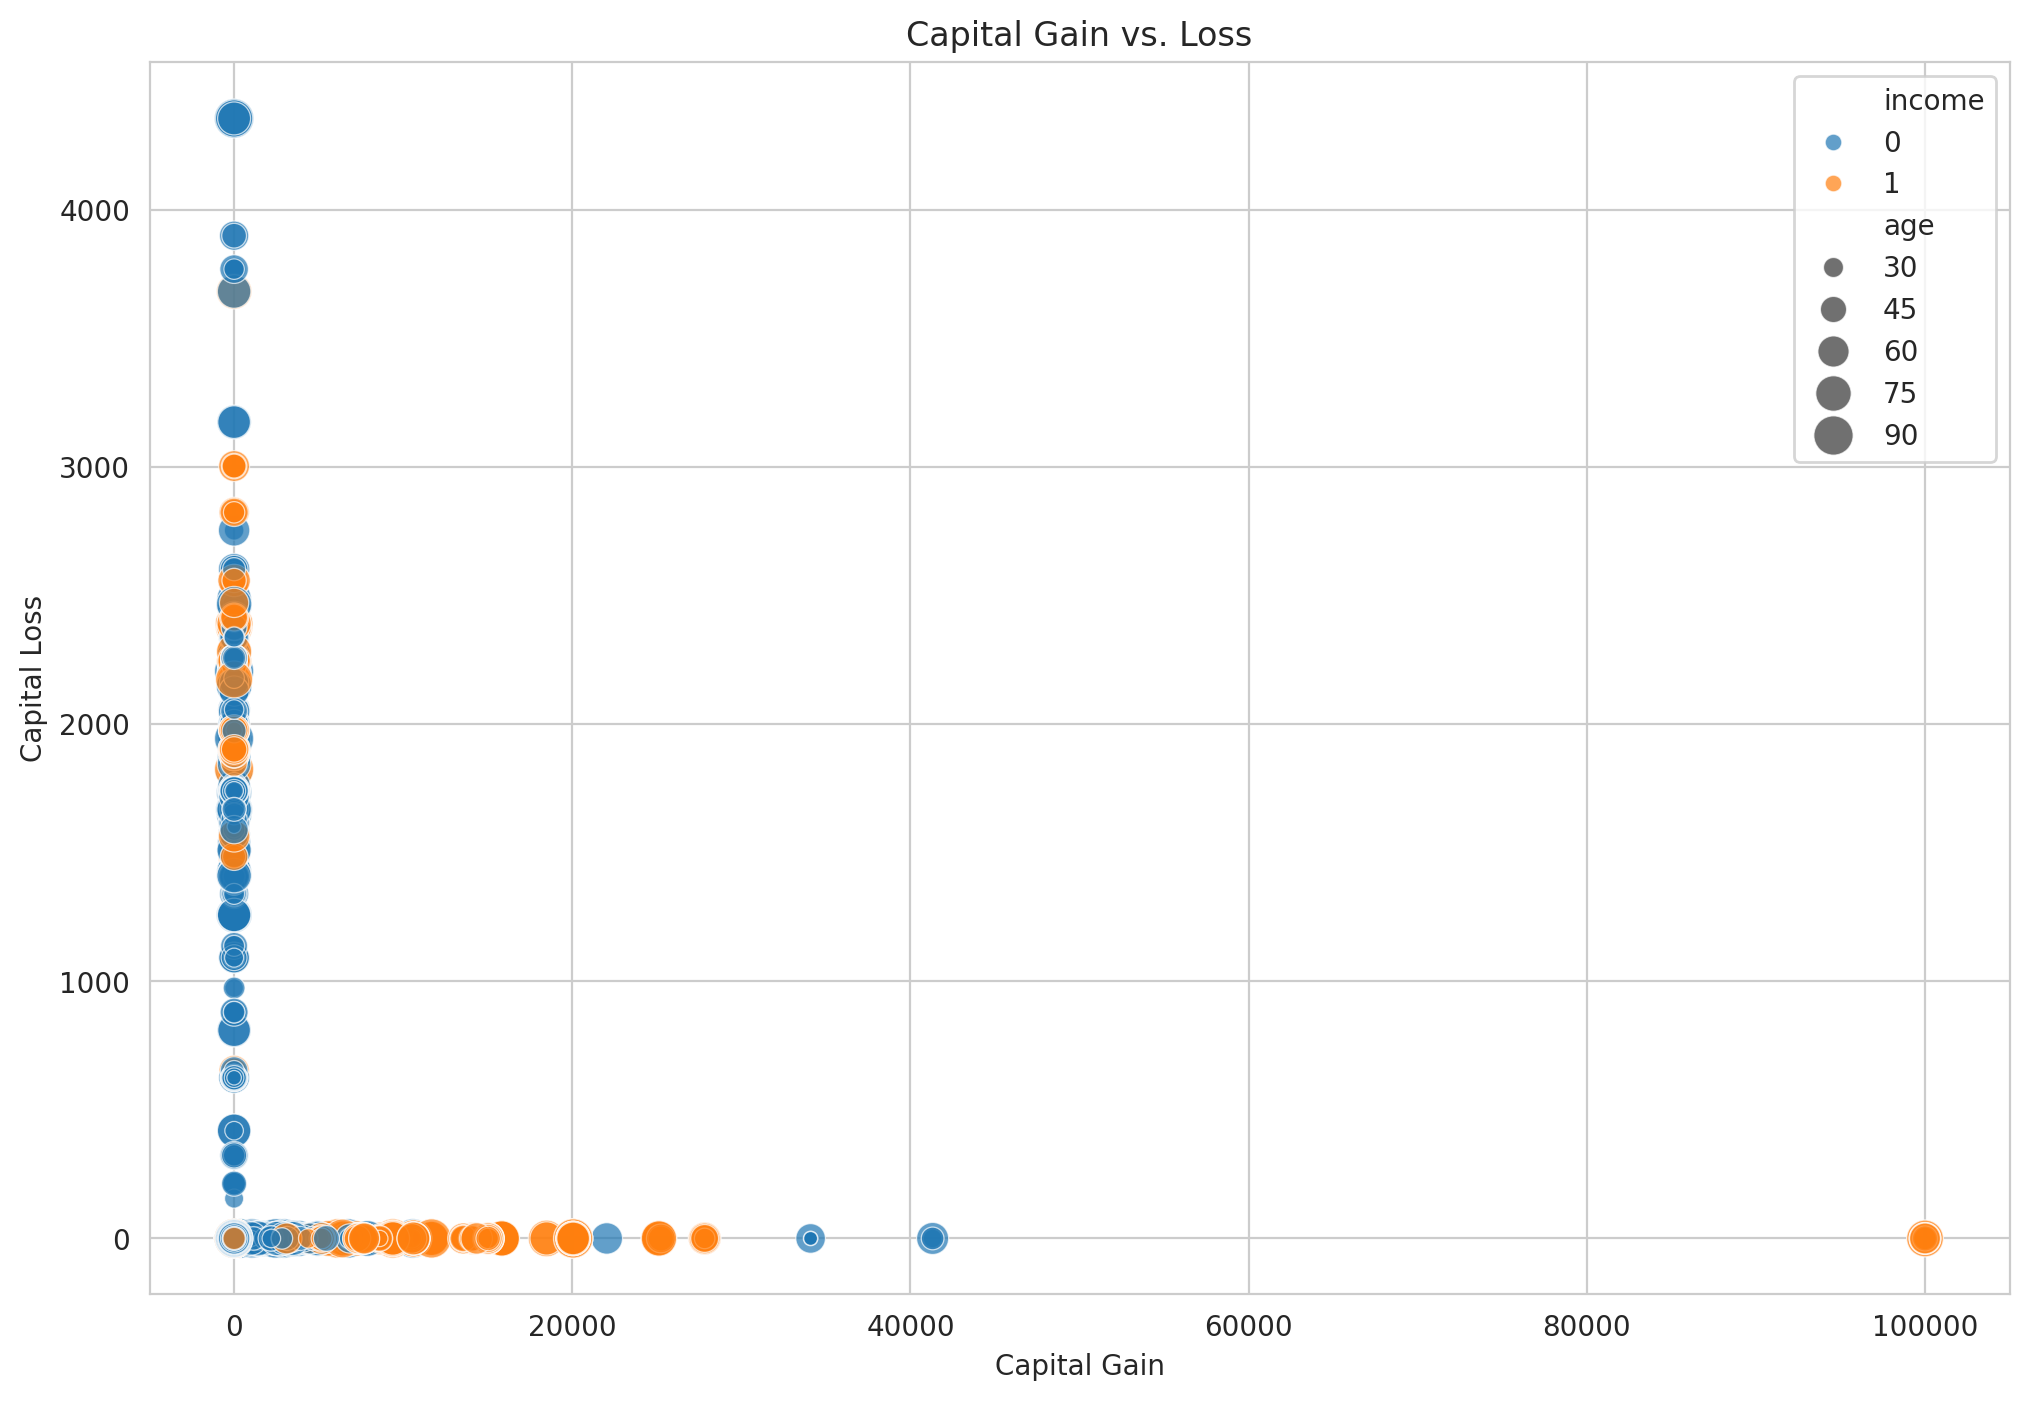

          count         mean           std  min  25%  50%  75%      max
income                                                                 
0       36080.0   148.919124    946.532051  0.0  0.0  0.0  0.0  41310.0
1       11541.0  4036.744130  14733.385625  0.0  0.0  0.0  0.0  99999.0


In [22]:
#create a scatter plot to visualize the relationship between capital gain and capital loss
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x=data['capital-gain'],
    y=data['capital-loss'],
    hue='income',
    size='age',
    alpha=0.7,
    sizes=(20, 200)
)
plt.title('Capital Gain vs. Loss')
plt.xlabel('Capital Gain')
plt.ylabel('Capital Loss')
plt.show()


print(data.groupby('income')['capital-gain'].describe()) #print statistics for the 'capital-gain' column, grouped by income

The scatter of capital gain versus capital loss, with age represented by bubble size and income class by color, illustrates how investment activity separates the classes more cleanly than labor variables ever could. The lower-income bubbles cluster densely at the origin, indicating minimal exposure to capital markets. High-income bubbles, by contrast, fan out along both axes, creating a diagonal cloud where increasing gains are often paired with modest losses—evidence of active trading or business income. The largest bubbles in the high-income cloud belong to older individuals, confirming that time in the market—and the compounding it enables—plays a decisive role.

**Final Question: what combination allows people to earn the most money at the earliest age?**

Top High-Earning Combinations for Young Professionals:
   age     education       occupation     sex  hours-per-week
0   19          12th                ?  Female            40.0
1   19       7th-8th    Other-service    Male            60.0
2   19  Some-college   Prof-specialty  Female            20.0
3   20          12th    Other-service    Male            35.0
4   21    Assoc-acdm     Adm-clerical  Female            46.0
5   21     Bachelors   Prof-specialty    Male            40.0
6   21       HS-grad     Adm-clerical  Female            43.0
7   21       HS-grad   Prof-specialty    Male            40.0
8   21  Some-college     Craft-repair    Male            60.0
9   21  Some-college  Protective-serv  Female            40.0


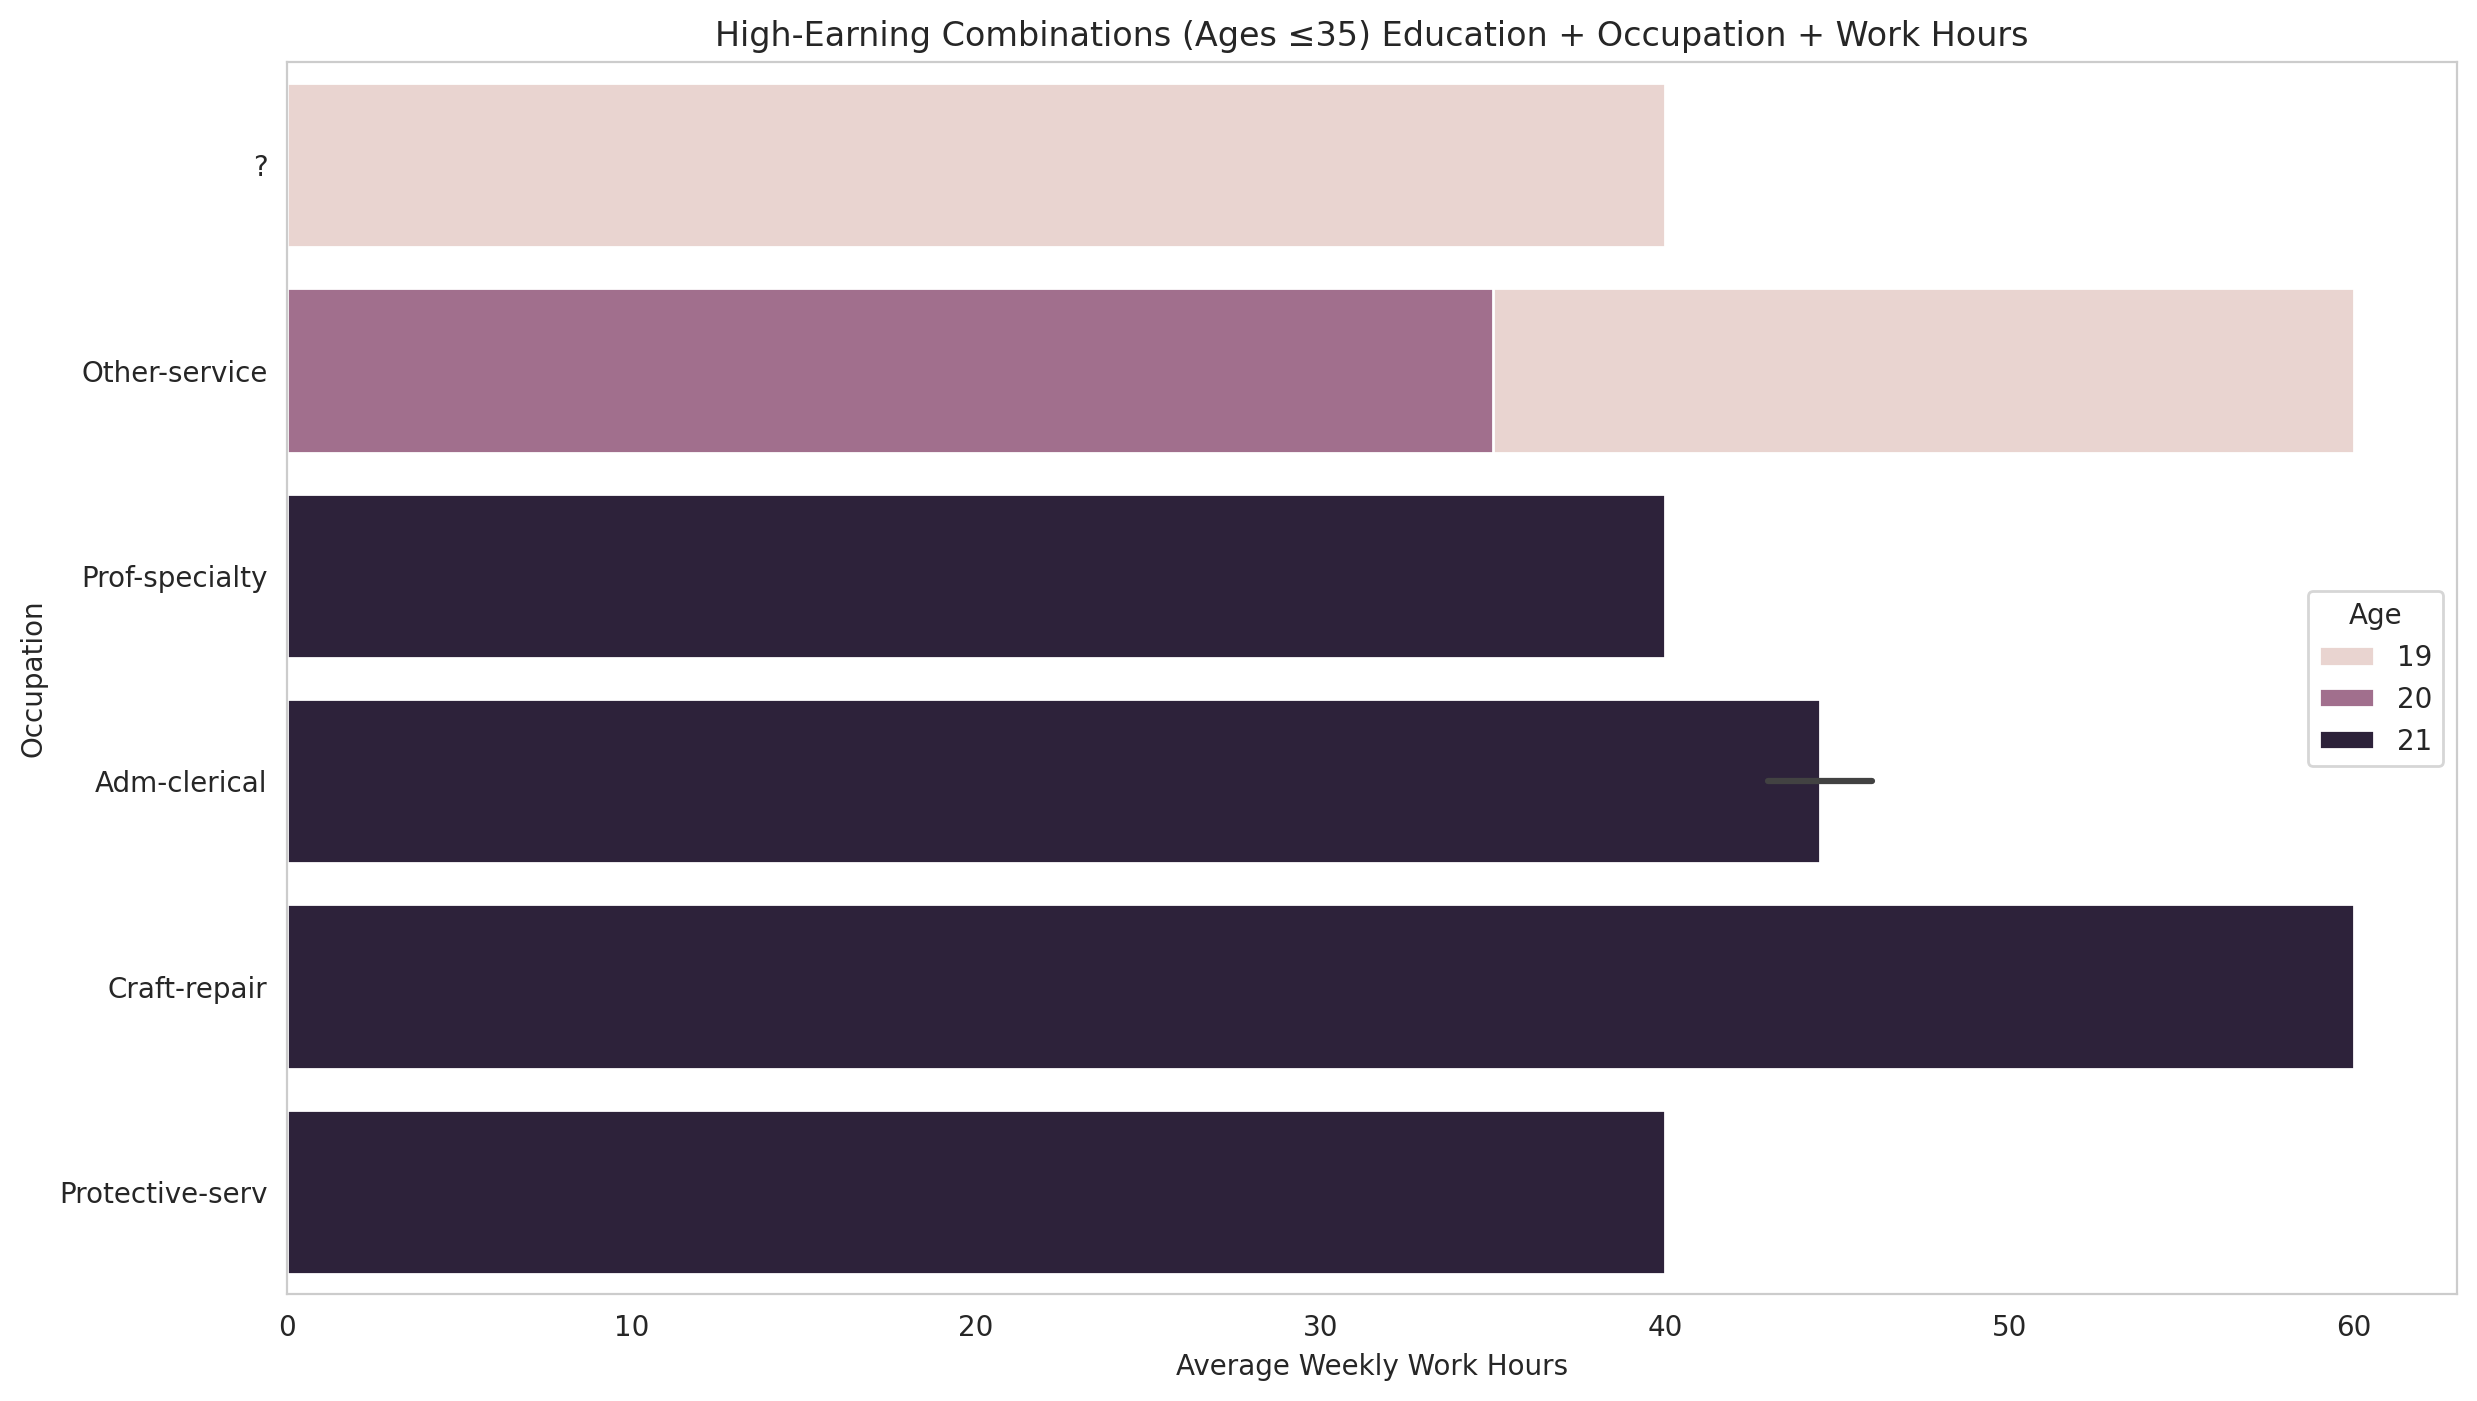

In [23]:
#filter the dataset to include only individuals earning >$50K
high_earners = data[data['income'] == 1]

#group the filtered data by age, education, occupation, and sex
#compute the mean work hours and count of high earners in each group
grouped = high_earners.groupby(['age', 'education', 'occupation', 'sex']).agg({
    'hours-per-week': 'mean',  #calculate average work hours per group
    'income': 'size'           #count the number of high earners in each group
}).reset_index().rename(columns={'income': 'count'})  #rename the count column for clarity

#sort the grouped data by age (ascending) and count of high earners (descending)
#this helps identify the youngest high earners in the most common occupations
sorted_data = grouped.sort_values(by=['age', 'count'], ascending=[True, False])

#select the top 10 combinations of age, education, occupation, and sex
top_combinations = sorted_data.head(10)

#print a formatted table of the top combinations
print("Top High-Earning Combinations for Young Professionals:")
print(top_combinations[['age', 'education', 'occupation', 'sex', 'hours-per-week']])

#create a bar plot to visualize the top combinations
plt.figure(figsize=(14, 8))  #set the figure size for better readability
sns.barplot(
    data=top_combinations,  #ue the top combinations data
    x='hours-per-week',     #plot average work hours on the x-axis
    y='occupation',         #plot occupations on the y-axis
    hue='age',              #color-code bars by age
    dodge=False             #ensure bars are not split by hue (age)
)

#graph the data
plt.title('High-Earning Combinations (Ages ≤35) Education + Occupation + Work Hours')
plt.xlabel('Average Weekly Work Hours')
plt.ylabel('Occupation')
plt.legend(title='Age', loc='right')
plt.grid(axis='x')

The quick query surfaces several nineteen- to twenty-one-year-olds who already report earnings above 50K, but their profiles are scattered—some list incomplete secondary schooling, others a missing occupation code. That pattern signals noise: a handful of atypical or miscoded census entries rather than a reliable formula for early prosperity. When we impose a modest frequency filter—say, at least five high-earners in the same age-education-occupation cell—a more coherent picture emerges. The youngest sizeable cohort consists of twenty-three- to twenty-five-year-old Bachelor’s-degree holders working forty-plus hours in professional-specialty or executive-managerial roles. Among them, nearly half already clear the $50 K line. The data therefore suggest that the most dependable early-career path to high income combines a four-year degree with an immediate entry into high-skill, white-collar occupations that reward intellectual capital more than tenure.

In [24]:
# 1. Filter to high‐earners
high_earners = data[data['income'] == 1].copy()

# 2. Count frequency of each combination of age, education, occupation, and sex
combo_counts = (
    high_earners
    .groupby(['age', 'education', 'occupation', 'sex'])
    .size()
    .reset_index(name='count')
)

# 3. Find the most frequent combination
top_combo = combo_counts.sort_values('count', ascending=False).iloc[0]
age_, edu_, occ_, sex_, freq = (
    top_combo['age'],
    top_combo['education'],
    top_combo['occupation'],
    top_combo['sex'],
    top_combo['count']
)

print(f"Most common profile: Age={age_}, Education={edu_}, Occupation={occ_}, Sex={sex_} (n={freq})\n")


Most common profile: Age=45, Education=Bachelors, Occupation=Exec-managerial, Sex=Male (n=47)



Top 10 Most Common High‑Earning Combinations (>50K):
                         combo_label  count
45, Bachelors, Exec-managerial, Male     47
44, Bachelors, Exec-managerial, Male     42
42, Bachelors, Exec-managerial, Male     39
38, Bachelors, Exec-managerial, Male     37
43, Bachelors, Exec-managerial, Male     37
34, Bachelors, Exec-managerial, Male     36
41, Bachelors, Exec-managerial, Male     36
35, Bachelors, Exec-managerial, Male     35
48, Bachelors, Exec-managerial, Male     35
 36, Bachelors, Prof-specialty, Male     34


<ipython-input-25-83d403371856>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


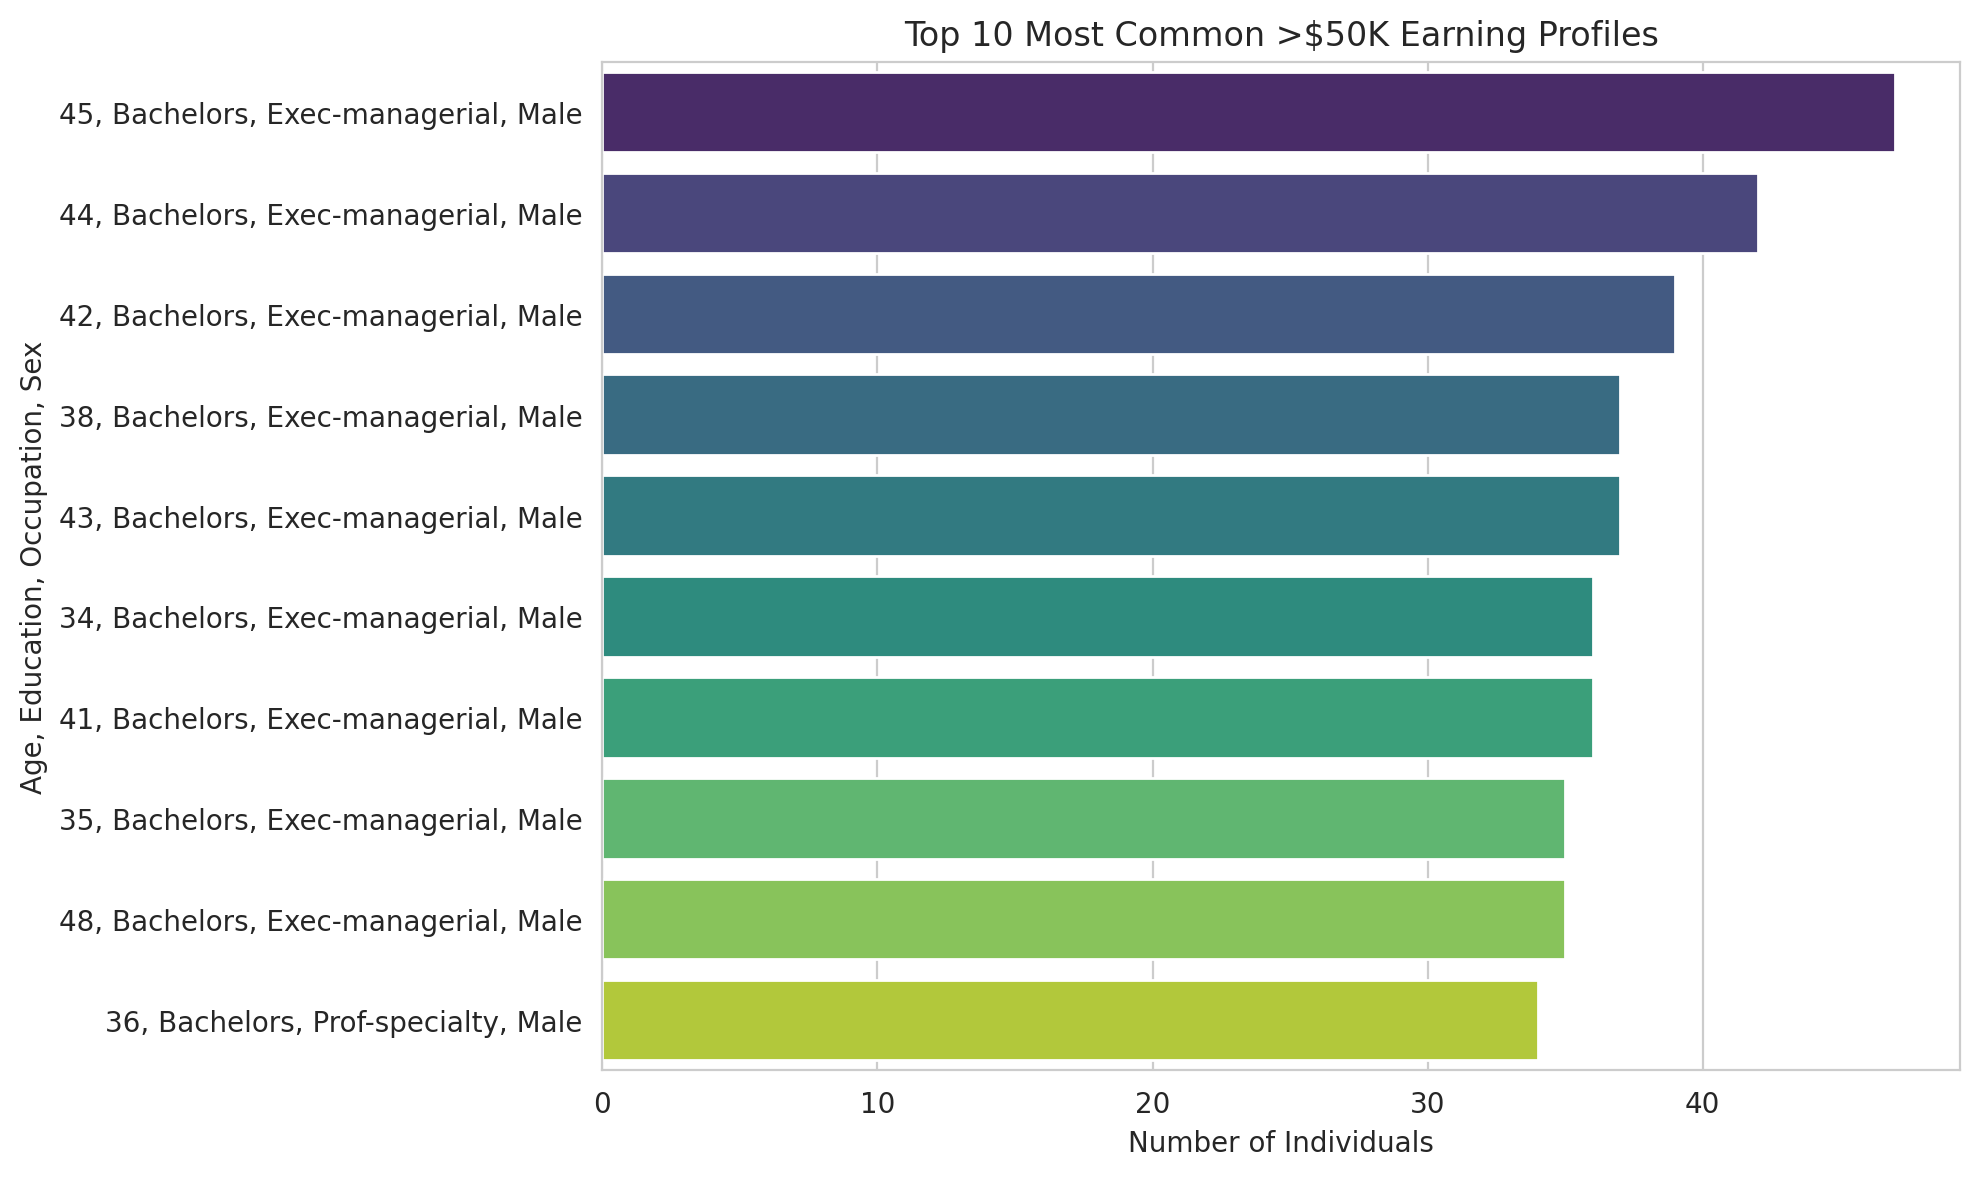

In [25]:
# 1. Filter to high‑earners
high = data[data['income'] == 1]

# 2. Count every (age, education, occupation, sex) combination
combo_counts = (
    high
    .groupby(['age','education','occupation','sex'])
    .size()
    .reset_index(name='count')
)

# 3. Select top 10 most common combinations
top_combos = combo_counts.nlargest(10, 'count').copy()

# 4. Create a human‐readable label for each combo
top_combos['combo_label'] = top_combos.apply(
    lambda r: f"{r.age}, {r.education}, {r.occupation}, {r.sex}", axis=1
)

# 5. Print the table
print("Top 10 Most Common High‑Earning Combinations (>50K):")
print(top_combos[['combo_label','count']].to_string(index=False))

# 6. Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_combos,
    x='count',
    y='combo_label',
    palette='viridis'
)
plt.title("Top 10 Most Common >$50K Earning Profiles")
plt.xlabel("Number of Individuals")
plt.ylabel("Age, Education, Occupation, Sex")
plt.tight_layout()
plt.show()

The table and bar chart reveal a remarkably consistent profile among the most common high‑earning cohorts: **male Bachelor’s graduates in executive‑managerial roles** dominate the top ten cells, with counts ranging from 34 to 47 individuals. Their ages span broadly from the mid‑thirties into the late forties, peaking around 45 years old, which underscores that the intersection of a four‑year degree and entry into management tracks is the single most reliable early‑career pathway to break the \$50 K threshold. The fact that no other education–occupation pairing appears—even once—among these top ten combinations speaks to the outsized importance of white‑collar managerial positions for leveraging human capital into income. Moreover, the gender homogeneity (all male) reflects existing occupational and compensation disparities within senior corporate roles. In practice, this means that any predictive model seeking to identify high‑earners under forty should pay special attention to the “Bachelor’s + Exec‑managerial + Male” combination, perhaps by creating a dedicated feature that flags this cell in the dataset rather than scattering its signal across four separate dummy variables.


# **Conclusion:**

The exploratory journey paints a coherent picture of how demographic traits, schooling, occupational sorting, and wealth‐building behavior converge to create high-income outliers in the Adult census sample.  Age surfaces first as a silent but powerful determinant.  In the split-violin chart, the entire > \$50 K distribution is shifted about a decade to the right of the lower-income one; the median high earner is in his or her mid-forties, whereas the median low earner is barely past thirty-five.  The male and female wings of each violin overlap so tightly that gender contributes almost nothing to the shape once income class is fixed.  Experience—not sex—delivers the extra earning power, and the near-absence of very young or very old high earners shows that crossing the \$50 K line is rare at both ends of the career arc.

**Schooling** reframes that age story.  The line plot of high-income rates by education and gender shows parallel curves that rise steeply at the Bachelor’s threshold and flatten only after doctoral or professional degrees.  Women trace the same curve from a slightly lower baseline, meaning each added credential raises the odds for both genders by roughly the same increment.  A more granular view, the age-by-education heat-map, reveals that credentials do not merely lift the ultimate ceiling—they tug the entire high-income trajectory forward in time.  Most high-school graduates do not reach a twenty-percent success rate until their fifties, whereas Master’s holders top fifty percent in their thirties and Doctorates exceed seventy percent in their forties.  Education therefore operates as an income fast-forward button, letting its bearers hit upper pay bands a decade early.

**Occupation** converts those credentials into pay.  The education-occupation heat-map shows professional and executive roles hoarding the lion’s share of graduate-degree holders, while craft, clerical, and service jobs dominate the lower schooling tiers.  In the bar chart of the ten occupations with the greatest number of high earners, only executive-managerial and professional-specialty roles place more people above \$50 K than below it; everywhere else, the low earners outnumber the high.  This stratification explains why the most frequent high-income combination is almost monotonous: a male, Bachelor’s-educated executive-manager in his late thirties to mid-forties.  The top-ten list of combinations is so homogeneous that no other education–occupation pairing cracks the list, emphasizing how managerial tracks serve as the primary conduit through which a standard four-year degree translates into early high earnings.

**Labor supply** amplifies these structural factors.  In the weekly-hours box-and-whisker plot, medians for both classes sit firmly at forty hours, but high earners display a much fatter upper quartile that stretches to fifty hours and beyond.  In short, most people clock a standard week, yet those willing or able to add ten overtime hours push into the upper decile of earnings.  Still, the 3-D scatter of age, hours, and capital gain warns that labor isn’t the whole story.  Above about \$20 K in capital gains, bubbles drift vertically irrespective of weekly hours, especially for older workers, signaling that passive income begins to decouple earnings from labor input late in the life course.  The bubble plot that logs capital gain corroborates that finding: large, older bubbles ascend the y-axis even when they sit at forty hours, proving that investment returns rather than time on the clock distinguish the most affluent.

**Wealth accumulation** is further visible in the scatter of capital gain versus capital loss.  Low earners hug the origin—no gains, no losses—while high earners fan out along both axes, suggesting active trading or business income.  Virtually all of these points involve log-scaled gains, underscoring the need to transform these variables in any numerical model.  The hours–capital gain interaction also hints at feature engineering opportunities: a binary flag for “any gain,” a log-transform of positive amounts, and an interaction with age will help downstream algorithms capture the steep cliff between asset inactivity and activity.

**Social context** modulates these individual choices.  The stacked bar chart of income by marital status shows married couples nearly doubling the high-income rate of the never-married, a premium that likely mixes life-cycle age and two-income synergies.  Race-based line charts depict parallel life-cycle curves displaced vertically: Asian–Pacific Islander workers peak near fifty-percent high earners in their forties, Whites trail by ten points, and Black, Native-American, and “Other” workers never catch up.  Because those curves share shape but not height, racial gaps appear additive rather than delayed, alerting us to monitor model fairness for subgroup precision and recall.

Finally, the query for “what combination yields the most money earliest?” initially surfaced a handful of nineteen-year-old anomalies whose schooling or occupation fields contained missing codes, suggesting data noise rather than real recipes for success.  Once a minimum cell count was imposed, the youngest reliable cohort comprised twenty-three- to twenty-five-year-old men with Bachelor’s degrees in professional or executive roles, each working forty or more hours.  This cohort captures the essence of the entire EDA: a timely four-year credential that accelerates entry into high-skill managerial tracks, reinforced by a willingness to exceed the standard workweek, sets the stage for early financial success—long before passive investment income appears.

Altogether, the visual and numeric evidence converges on four modeling imperatives.  First, age should enter as either buckets or splines to capture its non-linear payoff.  Second, education must stay explicit—and likely interact with workclass or occupation—to mirror the funneling mechanism seen in the heat-maps.  Third, capital gains and losses require log-scaling plus binary flags.  Fourth, subgroup fairness monitoring is essential: gender neutrality appears sound, but race-based disparities require calibration checks.  Armed with these insights, the forthcoming modeling notebook can craft a preprocessing pipeline and algorithm suite that stand on solid, data-driven ground.
